# Blockage Deficit Models

**The blockage deficit models compute the blockage effects caused by a single wind turbine.**

Their structure are quite similar to the [Wake Deficit Models](WakeDeficitModels.ipynb). They model upstream blockage effects (wind speed reduction) and in addition, some models also models downstream speed-up effects. There are several blockage models available, which include:

- [SelfSimilarityDeficit](#SelfSimilarityDeficit)
- [SelfSimilarityDeficit2020](#SelfSimilarityDeficit2020)
- [FugaDeficit](#FugaDeficit)
- [VortexCylinder](#VortexCylinder)
- [VortexDipole](#VortexDipole)
- [RankineHalfBody](#RankineHalfBody)
- [HybridInduction](#HybridInduction)
- [Rathmann](#Rathmann)

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# import and setup site and windTurbines
import py_wake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

In [3]:
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot
from py_wake.wind_farm_models import All2AllIterative

#turbine diameter
D = 80

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0, 10, 55)):
    fm = get_flow_map(model)
    fm.plot(fm.ws - fm.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[fm.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')

def plot_blockage_deficit_map(model):
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    cmap = np.r_[cm.Reds_r(np.linspace(-0,1,127)),[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap), levels=np.linspace(-3.5,3.5,113))

### SelfSimilarityDeficit
Simple induction model, described in [N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137)

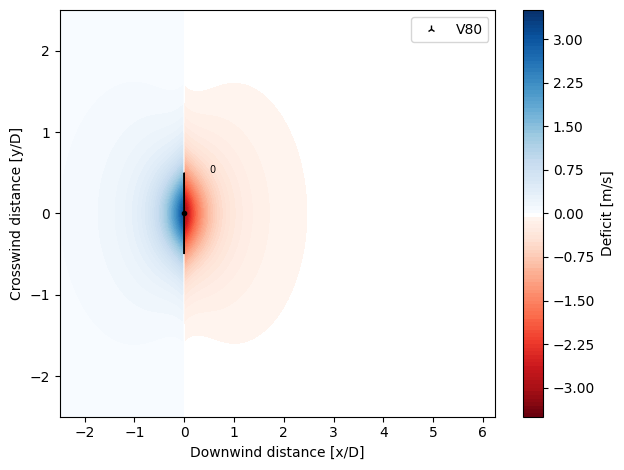

In [4]:
from py_wake.deficit_models import SelfSimilarityDeficit
plot_blockage_deficit_map(SelfSimilarityDeficit())

### SelfSimilarityDeficit2020

This is an updated version of [N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137). The new features are found in the radial and axial functions:

1. Radially Eq. (13) is replaced by a linear fit, which ensures the induction half width, `r12`, to continue to diminish approaching the rotor. This avoids unphysically large lateral induction tails, which could negatively influence wind farm simulations.
2. The value of gamma in Eq. (8) is revisited. Now gamma is a function of CT and axial coordinate to force the axial induction to match the simulated results more closely. The fit is valid over a larger range of thrust coefficients and the results of the constantly loaded rotor are excluded in the fit.

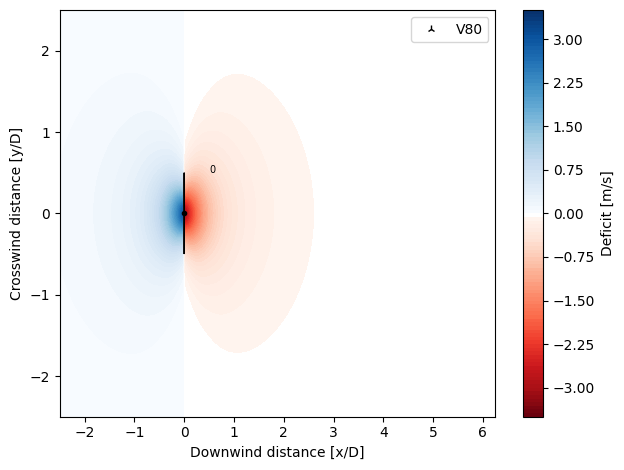

In [5]:
from py_wake.deficit_models import SelfSimilarityDeficit2020
plot_blockage_deficit_map(SelfSimilarityDeficit2020())

### FugaDeficit

The FugaDeficit model calculates the wake deficit based on a set op look-up tables computed by a linearized RANS solver. The look-up tables be created in advance using the [Fuga GUI](https://orbit.dtu.dk/en/publications/developments-of-the-offshore-wind-turbine-wake-model-fuga).

The FugaDeficit models the near wake, far wake and blockage deficit effects.

Note, the present look-up table generator introduces some unphysical wriggles in the blockage deficit/speed-up.

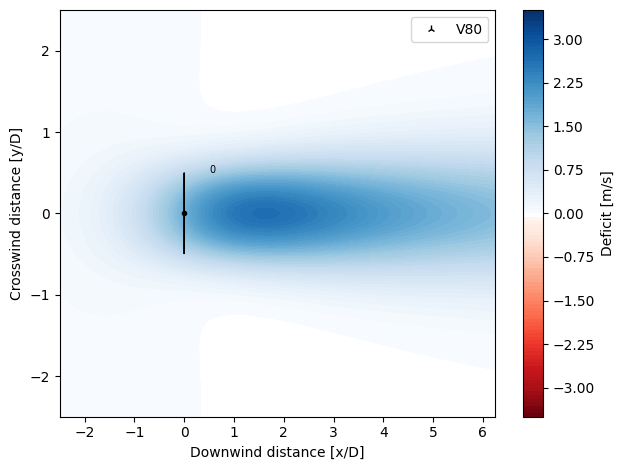

In [6]:
from py_wake.deficit_models import FugaDeficit
plot_blockage_deficit_map(FugaDeficit())

### VortexCylinder

Induced velocity from a semi-infinite cylinder of tangential vorticity, extending along the x axis.

This model is an adapted version of the one published by Emmanuel Branlard at https://github.com/ebranlard/wiz/blob/master/wiz/VortexCylinder.py

References:

- E. Branlard, M. Gaunaa, Cylindrical vortex wake model: right cylinder, Wind Energy, 2014, https://onlinelibrary.wiley.com/doi/full/10.1002/we.1800
- E. Branlard, Wind Turbine Aerodynamics and Vorticity Based Method, Springer, 2017
- E. Branlard, A. Meyer Forsting, Using a cylindrical vortex model to assess the induction zone in front of aligned and yawed rotors, in Proceedings of EWEA Offshore Conference, 2015, https://orbit.dtu.dk/en/publications/using-a-cylindrical-vortex-model-to-assess-the-induction-zone-inf

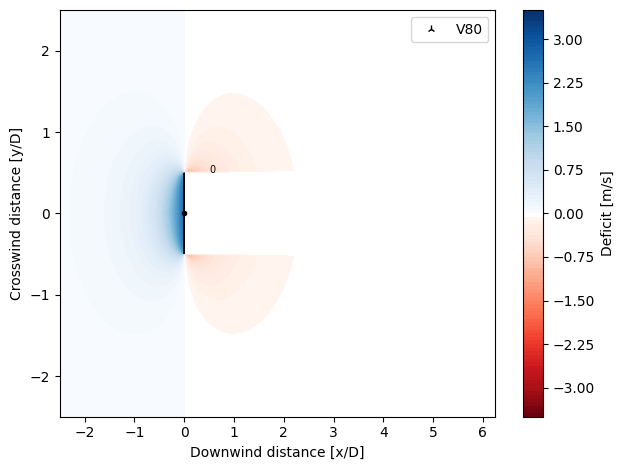

In [7]:
from py_wake.deficit_models import VortexCylinder
plot_blockage_deficit_map(VortexCylinder())

### VortexDipole

The vorticity originating from a wind turbine can be represented by a vortex dipole line (see Appendix B in [2]). The induction estimated by such a representation is very similar to the results given by the more complex vortex cylinder model in the far-field r/R > 6 [1,2]. The implementation follows the relationships given in [1,2]. This model is an adapted version of the one published by Emmanuel Branlard: https://github.com/ebranlard/wiz/blob/master/wiz/VortexDoublet.py

References:
- [1] Emmanuel Branlard et al 2020 J. Phys.: Conf. Ser. 1618 062036
- [2] Branlard, E, Meyer Forsting, AR. Wind Energy. 2020; 23: 2068– 2086.  https://doi.org/10.1002/we.2546

In [8]:
from py_wake.deficit_models import VortexDipole
plot_blockage_deficit_map(VortexDipole())

### RankineHalfBody

A simple induction model using a Rankine Half Body to represent the induction introduced by a wind turbine. The source strength is determined enforcing 1D momentum balance at the rotor disc.

References:

- B Gribben, G Hawkes - A potential flow model for wind turbine induction and wind farm blockage - Technical Paper, Frazer-Nash Consultancy, 2019

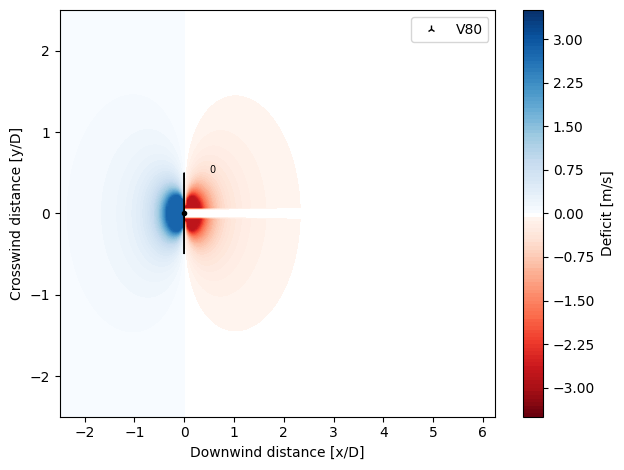

In [9]:
from py_wake.deficit_models import RankineHalfBody
plot_blockage_deficit_map(RankineHalfBody())

### HybridInduction
The idea behind this model originates from [2,3], which advocates to combine near-rotor and farfield approximations of a rotor's induced velocities. Whereas in [1,2] the motivation is to reduce the computational effort, here the already very fast self-similar model [1] is combined with the vortex dipole approximation in the far-field, as the self-similar one is optimized for the near-field (r/R > 6, x/R < 1) and misses the acceleration around the wake for x/R > 0. The combination of both allows capturing the redistribution of energy by blockage. Location at which to switch from near-rotor to far-field can be altered though by setting switch_radius.

References:
1. N. Troldborg, A.R. Meyer Fortsing, Wind Energy, 2016
2. Emmanuel Branlard et al 2020 J. Phys.: Conf. Ser. 1618 062036
3. Branlard, E, Meyer Forsting, AR. Wind Energy. 2020; 23: 2068– 2086. https://doi.org/10.1002/we.2546

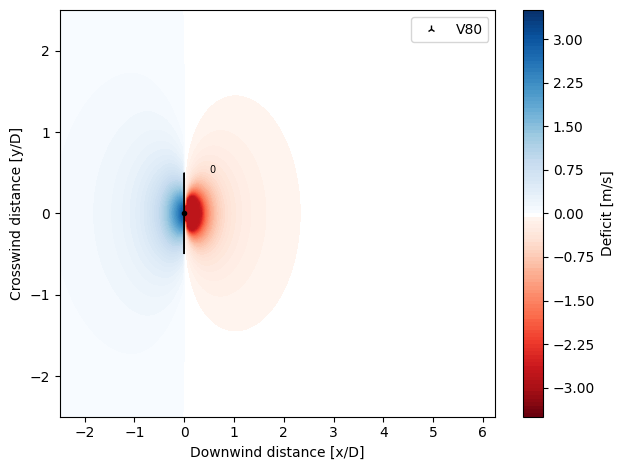

In [10]:
from py_wake.deficit_models import HybridInduction
plot_blockage_deficit_map(HybridInduction())

### Rathmann

Ole Sten Rathmann (DTU) developed in 2020 an approximation to the vortex cylinder solution (E. Branlard and M. Gaunaa, 2014). In speed it is comparable to the vortex dipole method, whilst giving a flow-field nearly identical to the vortex cylinder model for x/R < -1. Its centreline deficit is identical to the vortex cylinder model, whilst using a radial shape function that depends on the opening of the vortex cylinder seen from a point upstream. To simulate the speed-up downstream the deficit is mirrored in the rotor plane with a sign change.

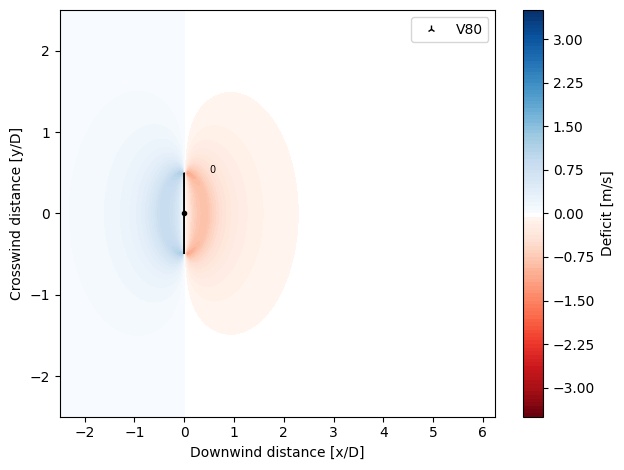

In [11]:
from py_wake.deficit_models import Rathmann
plot_blockage_deficit_map(Rathmann())

### Comparing different blockage deficit models

In [12]:
from py_wake.utils.model_utils import get_models
from py_wake.deficit_models.deficit_model import BlockageDeficitModel

blockage_deficitModels = get_models(BlockageDeficitModel, exclude_None=True)
for deficitModel in blockage_deficitModels:
    print (deficitModel.__name__)

FugaDeficit
FugaMultiLUTDeficit
FugaYawDeficit
HybridInduction
SelfSimilarityDeficit2020
VortexDipole
RankineHalfBody
Rathmann
RathmannScaled
SelfSimilarityDeficit
VortexCylinder


**1) Deficit along center line**

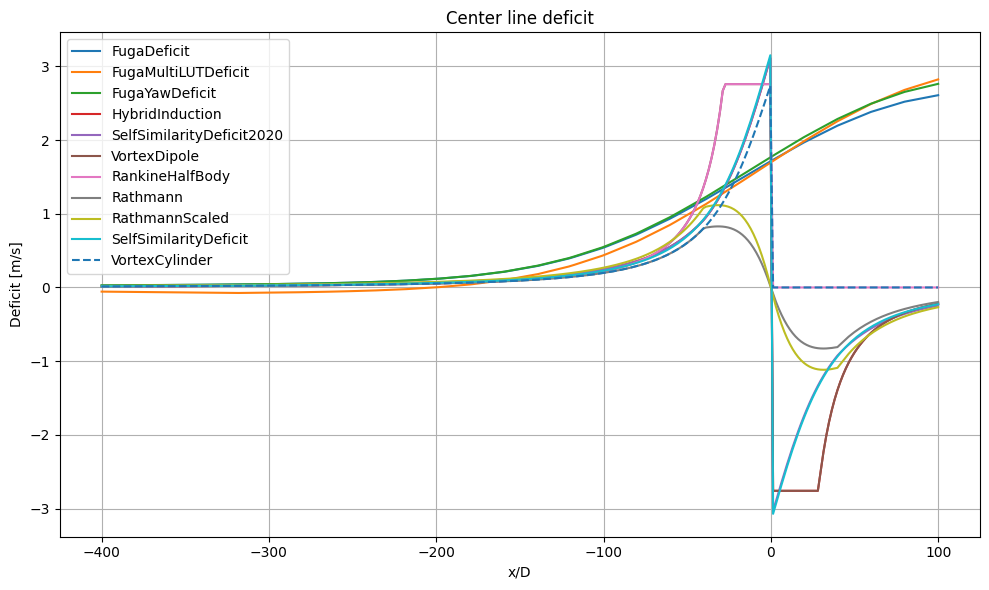

In [13]:
plt.figure(figsize=((10,6)))
for i, deficitModel in enumerate(blockage_deficitModels):
    fm = get_flow_map(deficitModel(), XYGrid(x=np.linspace(-400,100,300), y=0))
    plt.plot(fm.x, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
setup_plot(title="Center line deficit", xlabel='x/D', ylabel='Deficit [m/s]')

**2) Deficit profile 1 up- and downstream**

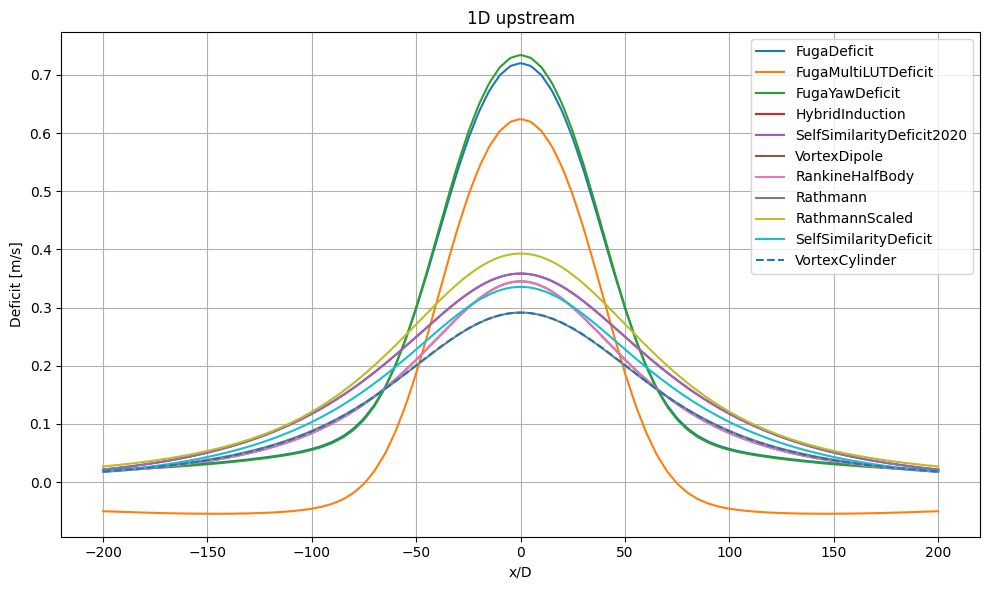

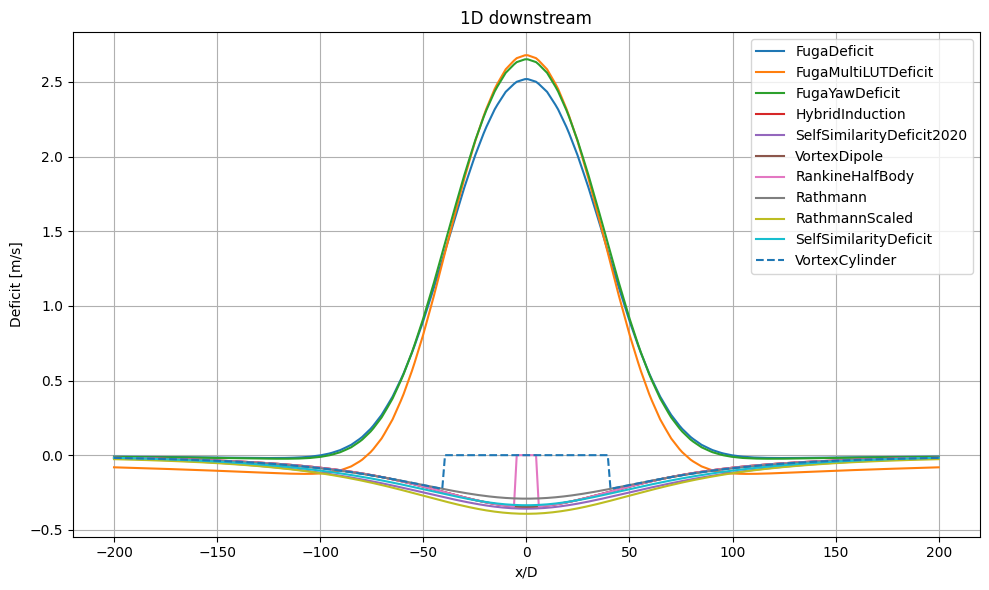

In [14]:
for d in [-1,1]:
    plt.figure(figsize=((10,6)))
    for i, deficitModel in enumerate(blockage_deficitModels):
        fm = get_flow_map(deficitModel(), XYGrid(x=d*D, y=np.linspace(-200,200,300)))
        plt.plot(fm.y, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
    setup_plot(title="%sD %sstream"%(abs(d),('down','up')[d<0]), xlabel='x/D', ylabel='Deficit [m/s]')

# Updates log

## PyWake 2.5 (February 15, 2023)

### New Features and API changes
- PyWake conda package available. Install by `conda install -c https://conda.windenergy.dtu.dk/channel/open py_wake`
- Before `RotorAvgModel` was an input to the WindFarmModel. This is ambigious as the rotor average models may be applied to both wake deficit, blockage deficit and turbulence. Instead the `RotorAvgModel` is now an input option to `WakeDeficitModel`, `BlockageDeficitModel` and `TurbulenceModel`
- Before the an area overlapping rotor average model was integrated into the `NOJDeficit` Model. These models have now been separated. The default behaviour is unchanged as the default rotor average model of `NOJDeficit` is set to `AreaOverlapAvgModel`
- The `IEA37SimpleBastankhahGaussian` wind farm model is deprecated. Please use the `IEA37CaseStudy1` model from py_wake.literature.iea37_case_study1 instead
- Notebook with verification of the TurbOPark model from Ørsted
- New netcdf-based Fuga look-up table format. The function `dat2netcdf` py_wake.utils.fuga_utils can be used to convert files from the old deprecated format to the new format.
- Wind turbine positions may now depend on wind direction and wind speed (e.g. floating wind turbines or multirotors)
- Before `All2AllIterative` took an input `initialize_with_PropagateDownwind` which defaulted to True to decide whether the effective wind speed in `All2AllIterative` should start with the free stream value or the effective wind speed computed by `PropagateDownwind` (i.e. without blockage). This input has been replaced with the optional input argument `WS_eff`. If `WS_eff=None`(default) then the initial effective wind speed is obtained from `PropagateDownwind`. Alternatively, the initial effective wind speed can be set to the free wind by `WS_eff=0` or directly to a custom value by `WS_eff=effective wind speed`. Note, however, that bypassing some iterations by setting the "correct" effective wind speed may result in wrong gradients
- `All2AllIterative` will now return after first iteration if `convergence_tolerance` is set to `None`. This only makes sense if CT and the deficit are independent of the effective wind speed, like the IEA37CaseStudy1 setup.
- The default behaviour of `StraightDistance` is now to use the reference wind direction
- New method to avoid deficit and turbulence from wind turbines on themselves. This allows flow maps without discontinuties at the wind turbines
- New `InputModifierModel` type that capable of modifying inputs before or during the simulations. This enables simulation of multirotor and floating wind turbines


### New models and functions
- DeficitModels
  - FugaMultiLUTDeficit, which allows different wind turbine types
  - XRDeficitModel for deficit models based on xarray.dataarray look-up table (with linear interpolation)
- RotorAvgModels
  - GaussianOverlap. The model is based on a lookup table with numerically integrated overlap factors based on normalized input of downstream rotor diamter and crosswind distance.
- TurbulenceModels
  - XRTurbulenceModel for turbulence models based on xarray.dataarray look-up table (with linear interpolation)
- Predefined WindFarmModels
  - TurbOPark. A setup very similar to the original Ørsted implementation
- InputModifierModels
  - MultiRotor. Model to change the position of the rotors on a multirotor wind turbine depending on the wind direction
- ISONoiseModel. Simple noise propagation model, see https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/Noise.html
- InputModifierModel. New model type that allows to modify inputs before or during the simulations. This allows multirotor 
- Functions
  - New `circular` method in py_wake.utils.layouts to generate circular layouts
  


### Bug fixes
- Fix a bug  in `WindFarmModel.aep` that ignored the `n_cpu`, `wd_chunks` and `ws_chunks` arguments and always computed on only one CPU.
- Fix `NOJLocalDeficit`. Before a layout term was precalculated, but in the local version this term depends on the effective TI which was unknow at this stage
- Fix error `ModuleNotFoundError: No module named 'xarray.plot.plot'` occurring with newer version of xarray
- Fix parallel executino with FugaDeficit
- and many more

## PyWake 2.4 (July 6, 2022)
### New features and API changes
- Before, the `Mirror` ground model used linear superposition of the above- and below-ground wind turbines while `MirrorSquaredSum` used squared sum. In this version the `MirrorSquaredSum` has been removed and `Mirror` is now using the superposition model of the wind farm model to calculate the sum. I.e. `Mirror` behaves as before if the superposition model is `LinearSum` and as the previuos `MirrorSquaredSum` if the superposition model is `SquaredSum`.
- Easy chunkification and parallelization via the arguments `n_cpu`, `wd_chunks` and `ws_chunks`, see https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/RunWindFarmSimulation.html#Chunkification-and-parallelization and https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/Optimization.html#Chunkify-and-Parallelization.
- Change dAEPdxy to automatically compute gradients of aep wrt. the concatenated list of x,y which is faster than computing first wrt. x then y.
- `py_wake.utils.layouts` contains functions to create rectangular and square wind turbine layouts.
- New approach to switch numpy backend (used when switching to `autograd.numpy`, `Numpy32` (see below, etc.). The new approach requires all modules to import np from py_wake, i.e. `from py_wake import np`.
- Easy way to switch between double presicion (standard numpy) and single precision (`Numpy32`), see https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/gradients_parallellization.html#Precision.
- New function `floris_yaml_to_pywake_turbine` (see https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/utils/floris_wrapper.py). This function creates a PyWake WindTurbine object from a Floris wind turbine yaml file and allows more direct comparison.
- Previuosly, `LocalWind` (returned by `site.localWind`) was an xarray `Dataset` subclass. Due to issues with autograd and cupy, this has been changed such that `LocalWind` is now a `dict` subclass with numpy arrays, `{'WS_ilk': np.array([...])}`. Xarray DataArrays are created by `LocalWind` when requesting attributes without `_ilk`, e.g. `localWind.WS`.
- Long list of bug and issue fixes.

### New models
- RotorAvgModels
  - New WSPowerRotorAvg, which computes the rotor average deficit by, $deficit = WS - \sqrt[\alpha]{\frac{1}{N} \sum_{i}{\left(WS - deficit_i\right)}^\alpha}$. Note that `WS` is the rotor center wind speed and thus shear and terrain-dependent inflow variation are not taken into account when computing the rotor average deficit.
- Power/Ct functions
  - New `DensityCompensation` which scales the wind speed wrt. air density. In most cases this model is more realistic than the existing alternative model, `DensityScale`, which scales the power and ct wrt. air density.

## PyWake 2.3 (March 18, 2022)
### New features and API changes
- `GroundModel` is now an input to `DeficitModel` instead of `WindFarmModel`. This means that a ground model can be applied to the blockage or wake, only.
- PyWake can now compute gradients via finite differnece, complex step and automatic differentiation, see https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/gradients_parallelization.html#Gradients. Most models supports all three methods, while a few do not work yet.
- Flow maps can be computed in both the vertical downwind and crosswind plane.


### New models
- WakeDeficitModels
  - CarbajofuertesGaussianDeficit 
  - TurboNOJDeficit 
  - TurboGaussianDeficit
- BlockageDeficitModels
  - RathmannScaled
- DeflectionModels
  - GCLHillDeflection 
  - JimenezWakeDeflection (extended with vertical deflection due to rotor tilt)
- WeightModels (to be used with the STF2005 and STF2017 TurbulenceModels)
  - FrandsenWeight (the previous implementation)
  - IECWeight (weight as specified in the IEC standard)  
- SiteModels
    - GlobalWindAtlasSite (site with data from online global wind atlas)
    - DistanceModels
      - JITStreamlineDistance (compute distances between wind turbines along streamlines)
    - ShearModels
      - LogShear

## PyWake 2.2 (March 26, 2021)
### New features and API changes
- All DeficitModels should inherit either `WakeDeficitModel` or `BlockageDeficitModel`.
- All Sites are now subclasses of XRSite.
- WeightedSum SuperpositionModel reimplemented to be more efficient.
- TurbulenceModels now take a RotorAvgModel as optional input. This allows PyWake to use different RotorAvgModels for wake and turbulence.
- Validation feature updated, see [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/exercises/Validation.html).
- The Power/Ct curve functionality of `WindTurbines` has been updated to support multidimensional Power and Ct curves, e.g. curves depending on turbulence intensity, air density, yaw misalignment, operational mode etc. This means that instantiating `WindTurbines` and `OneTypeWindTurbines` with the old set of arguments, i.e. `name, diameter, hub_height, ct_func, power_func, power_unit`, is deprecated. Use the the new `WindTurbine` and `Windturbines` classes with the arguments `name, diameter, hub_height, powerCtFunction` instead, see [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/WindTurbines.html). Backward compatibility is ensured (with runtime warning) for most use cases.
The `powerCtFunction` can be one of the classes from py_wake.wind_turbines.power_ct_functions, i.e.
    - `PowerCtFunction`
    - `PowerCtTabular`
    - `PowerCtFunctionList`
    - `PowerCtNDTabular`
    - `PowerCtXr`
    - `CubePowerSimpleCt`
- Support for time series of wd and ws, see [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/RunWindFarmSimulation.html#Time-series). Possible use cases:
    - Time-dependent inflow, e.g. measurements of wd, ws, ti, shear, density, etc.
    - Time-dependent operation, e.g. periods of failure or maintaince of a wind turbine
- Added support for load surrogates to predict wind turbine loads.

### New models
- BlockageDeficitModels (see [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/EngineeringWindFarmModels.html#Blockage-deficit-models))
    - SelfSimilarityDeficit2020
    - HybridInduction
    - RankineHalfBody
    - VortexCylinder
    - VortexDipole
    - Rathmann
- DeflectionModels
    - FugaDeflection (requires Fuga look-up tables, `UL`, `UT`, `VL`, `VT`)
- GroundModels
    - Mirror
    - MirrorSquaredSum

## PyWake 2.1 (September 14, 2020)


### New features and API changes
- New xarray data structure
    - LocalWind, SimulationResult and FlowMap are now `xarray.Dataset`-objects with some additional methods and attributes.
    - `simulationResult.aep()` now returns a `xarray.DataArray` with aep for all wind turbines, wind directions and wind speeds. To get the total AEP as before, use `simulationResult.aep().sum()`.
    - New general XRSite where the site is defined as an xarray with the following structure:
        - Required data variables: 
            - P(probability) or f(sector frequency), A(Weibull scale), k(Weibull shape)
        - Optional data variables: 
            - WS(defaults to reference wind speed, ws), TI(turbulence intensity), SpeedUp, Turning
        - All data variables may be constant or dependent on any of:
            - ws (reference wind speed)
            - wd (reference wind direction)
            - position in terms of
                - gridded 2D position, (x,y)
                - gridded 3D position, (x,y,z)
                - wt position, (i)
- [Include effects of neighbouring wind farms](Site.ipynb#wake-effects-from-neighbouring-wind-farms) in site (wind resource) to speed up optimization of a wind farm with neighbouring farms.
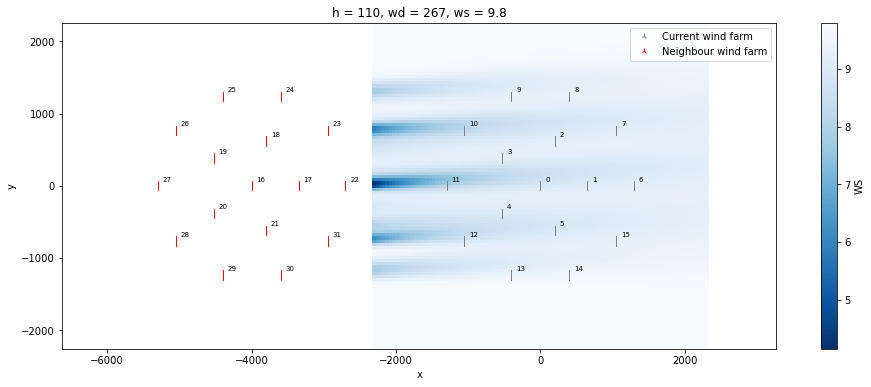
- Vertical flow map via the [YZGrid](RunWindFarmSimulation.ipynb#YZGrid).
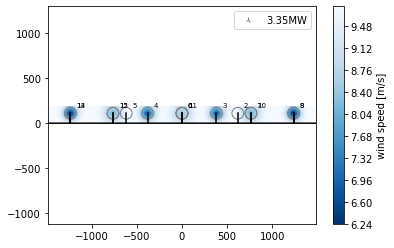


### New models

- New `RotorAverageModel`, see [here](EngineeringWindFarmModels.ipynb#Rotor-average-models). The default model, `RotorCenter`, behaves as before as it estimates the rotor-average wind speed from the wind speed at the rotor center. Other models, however, provide a more accurate estimate based on multiple points on the cost of computation. The `CGIRotorAvg(4)` and `CGIRotorAvg(7)` with 4 and 7 points, respectively, provide good compromises between accuracy and computational cost.
- Deficit model: 
    - [GCLDeficit](EngineeringWindFarmModels.ipynb#GCLDeficit): The Gunner Larsen semi-analytical wake model.
- Superposition model:
    - WeightedSum A weighted sum approach taking wake convection velocity into account. The model is so far only applicable to the gaussian models. The model is based on "A momentum-conserving wake superposition method for wind farm power prediction" by Haohua Zong and Fernando Porté-Agel, J. Fluid Mech. (2020), vol. 889, A8; doi:10.1017/jfm.2020.77.


## PyWake 2.0 (April 15, 2020)

- New structure
    - Purpose:
        - Easier combination of different models for flow propagation, wake and blockage deficit, superposition, wake deflection and turbulence.
        - More consistent interface to and support for engineering models and PyWake-Rans.
    - Changes
        - `WakeModel` class refactored mainly into the `WindFarmModel`s `EngineeringWindFarmModel` and `PropagateDownwind`.
        - `WindFarmModel`s, e.g. `NOJ`, `Fuga`, `BastankhahGaussian` returns a `SimulationResult` containing the results as well as an AEP and a flow_map method. See the QuickStart tutorial,
        - and many more.
    - Backward compatibility
        - AEP Calculator works as before, but is now deprecated.
        - Lower level interfaces and implementations has changed.
- New documentation matching the new structure.
- Optional blockage deficit models and implementation of the SelfSimilarity model.
- Optional wake deflection models and implementation of a model by Jimenez.

# Deflection Models

**The deflection models calculate the deflection of the wake due to yaw-misalignment, sheared inflow etc.**

Note, this is one of the four effects of skew inflow that is handled in PyWake, see [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/YawMisalignment.html).

The deflection models take as input the downwind and crosswind distances between the source wind turbines and the destination wind turbines/sites and calculate a new set of deflected downwind and crosswind distances. This type of model is important for simulations where the turbine experiences a change in angle between the incoming flow and the rotor, for example in active yaw control or wake steering optimization.

In PyWake, there are three different wake deflection models:

- [JimenezWakeDeflection](#JimenezWakeDeflection)
- [FugaDeflection](#FugaDeflection)
- [GCLHillDeflection](#GCLHillDeflection)

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

First we create a simple function to plot the different deflection models available in PyWake.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# import and setup site and windTurbines
import py_wake
from py_wake import BastankhahGaussian
from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.examples.data.hornsrev1 import V80

site = IEA37Site(16)
x, y = [0, 400, 800], [0, 0, 0]
windTurbines = V80()
D = windTurbines.diameter()

In [12]:
def plot_deflection(deflectionModel):
    
    wfm = BastankhahGaussian(site, windTurbines, deflectionModel=deflectionModel)

    yaw = [-20,20,0]
    D = windTurbines.diameter()

    plt.figure(figsize=(14,4))
    fm = wfm(x, y, yaw=yaw, tilt=0, wd=270, ws=10).flow_map()
    fm.plot_wake_map(normalize_with=D)
    center_line = fm.min_WS_eff()
    plt.plot(center_line.x/D, center_line/D,'--k')
    plt.grid()

### JimenezWakeDeflection

The `JimenezWakeDeflection` model is implemented according to Jiménez, Á., Crespo, A. and Migoya, E. (2010), Application of a LES technique to characterize the wake deflection of a wind turbine in yaw. Wind Energ., 13: 559-572. doi:10.1002/we.380.

It is the most common wake deflection model used in PyWake and has proved to result in a decent representation of the skewed inflow behind the turbine rotor. In the study, the authors carried out a Large Eddy Simulation (LES) to characterize the turbulence behind a wind turbine given the wake deflection created by different yaw angle and thrust coefficient settings.

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

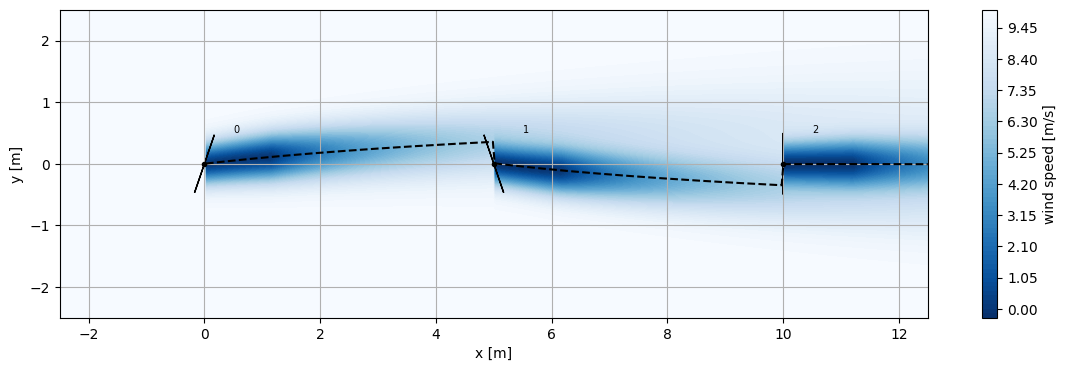

In [13]:
from py_wake.deflection_models import JimenezWakeDeflection
plt.figure()
plot_deflection(JimenezWakeDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### FugaDeflection

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

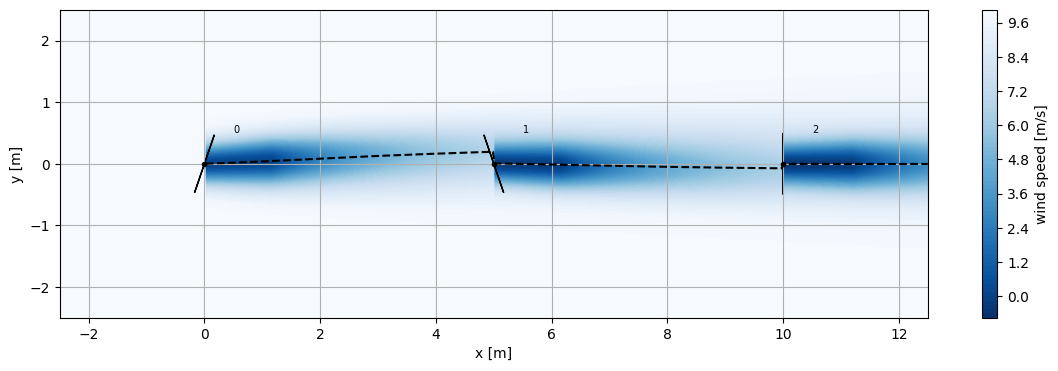

In [14]:
from py_wake.deflection_models import FugaDeflection
plt.figure()
plot_deflection(FugaDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### GCLHillDeflection

Deflection model based on Hill's ring vortex theory.

Implemented according to: Larsen, G. C., Ott, S., Liew, J., van der Laan, M. P., Simon, E., R.Thorsen, G., & Jacobs, P. (2020). Yaw induced wake deflection - a full-scale validation study. Journal of Physics - Conference Series, 1618, [062047]. https://doi.org/10.1088/1742-6596/1618/6/062047.
    
Note, this model uses the wake centerline deficit magnitude to calculate the deflection. Hence non-gaussian-shaped wake deficit models as well as deficit models with improper near wake fields, e.g. NOJDeficit, BastankhahGaussianDeficit, NiayifarGaussianDeficit, should be avoided.

As default the model uses the `WakeDeficitModel` specified for the `WindFarmModel` to calculate the magnitude of the deficit, but a separate model can be specified.

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

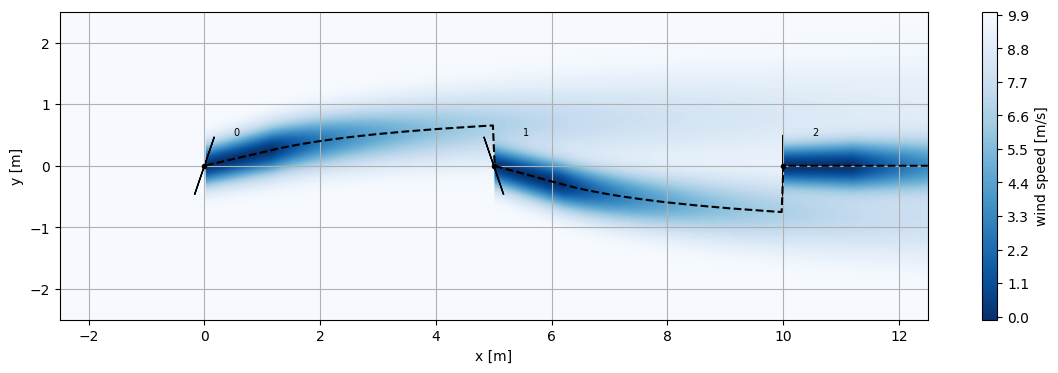

In [15]:
from py_wake.deflection_models import GCLHillDeflection
plt.figure()
plot_deflection(GCLHillDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### You can also implement your own deflection models

Deficit models must subclass `DeficitModel` and thus must implement the `calc_deflection` method and a class variable, `args4deflection` specifying the arguments required by its calc_deflection method.

```python

class DeflectionModel(ABC):
    args4deflection = ["ct_ilk"]

    @abstractmethod
    def calc_deflection(self, dw_ijl, hcw_ijl, **kwargs):
        """Calculate deflection

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deflection

        See documentation of EngineeringWindFarmModel for a list of available input arguments

        Returns
        -------
        dw_ijlk : array_like
            downwind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        hcw_ijlk : array_like
            horizontal crosswind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        """
```

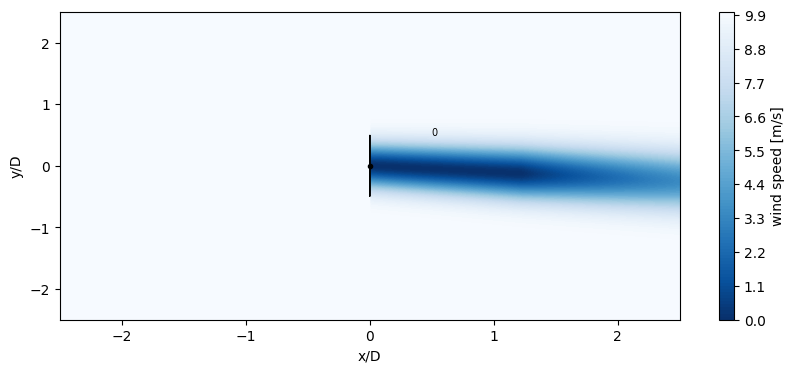

In [18]:
from py_wake.deflection_models import DeflectionModel
from numpy import newaxis as na
from py_wake import BastankhahGaussian

class MyDeflectionModel(DeflectionModel):

    def calc_deflection(self, dw_ijlk, hcw_ijlk, **_):
        hcw_ijlk =hcw_ijlk + .1*dw_ijlk       # deflect 1/10 of the downstream distance
        dh_ijlk =np.zeros_like(hcw_ijlk)      # no vertical deflection
        return dw_ijlk, hcw_ijlk, dh_ijlk

iea_my_deflection = BastankhahGaussian(site, windTurbines, deflectionModel=MyDeflectionModel())

plt.figure(figsize=(10,4))
iea_my_deflection(x=[0], y=[0], wd=270, ws=10).flow_map().plot_wake_map(normalize_with=D)
plt.xlabel('x/D')
plt.ylabel('y/D');

# Engineering Wind Farm Models Object

PyWake contains three general engineering wind farm models, namely [PropagateDownwind](#PropagateDownwind), [All2AllIerative](#All2AllIterative) and [PropagateUpDownIterative](#PropagateUpDownIterative). 

The table below compares their properties:

/ | `All2AllIterative` | `PropagateDownwind` | `PropagateUpDownIteartive` |
-- | -- | -- | --|
Includes wakes | Yes | Yes | Yes
Includes blockage | Yes | No | Yes
Memory requirement | High | Low | Low |
Simulation speed | Slow | Fast | Medium


In addition different [pre-defined models}(#Predefined-Wind-Farm-Models) exits. The predefined models covers often-used model combinations and models from the literature. I.e. they instantiates one of the above-mentioned wind farm models with a combination of wake deficit models, superposition models, turbulence models, etc. However, these are easily customizable to study the impact of different models on the results.

### PropagateDownwind

The `PropagateDownwind` wind farm model is very fast as it only performs a minimum of deficit calculations. It iterates over all turbines in downstream order. In each iteration it calculates the effective wind speed at the current wind turbine as the free stream wind speed minus the sum of the deficit from upstream sources. Based on this effective wind speed, it calculates the deficit caused by the current turbine on all downstream destinations. Note, that this procedure neglects upstream blockage effects.

```python
for wt in wind turbines in downstream order:
    ws_eff[wt] = ws[wt] - superposition(deficit[from_upstream_src,to_wt])
    ct = windTurbines.ct(ws_eff[wt])
    deficit[from_wt,to_downstream_dst] = wakeDeficitModel(ct, distances[from_wt,to_downstream_dst], ...)
```

The proceedure is illustrated in the animation below:

- **Iteration 1:** WT0 sees the free wind (10m/s). Its deficit on WT1 and WT2 is calculated.
- **Iteration 2:** WT1 sees the free wind minus the deficit from WT0. Its deficit on WT2 is calculated and the effective wind speed at WT2 is updated.

![PropagateDownwind](../_static/PropagateDownwind.png)

In PyWake, the class is represented as follows:

In [ ]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [6]:
from py_wake.wind_farm_models import PropagateDownwind
help(PropagateDownwind.__init__)

Help on function __init__ in module py_wake.wind_farm_models.engineering_models:

__init__(self, site, windTurbines, wake_deficitModel, superpositionModel=<py_wake.superposition_models.LinearSum object at 0x000002E1940F4E90>, deflectionModel=None, turbulenceModel=None, rotorAvgModel=None, inputModifierModels=[])
    Initialize flow model
    
    Parameters
    ----------
    site : Site
        Site object
    windTurbines : WindTurbines
        WindTurbines object representing the wake generating wind turbines
    wake_deficitModel : DeficitModel
        Model describing the wake(downstream) deficit
    rotorAvgModel : RotorAvgModel, optional
        Model defining one or more points at the down stream rotors to
        calculate the rotor average wind speeds from.
    
        if None, default, the wind speed at the rotor center is used
    superpositionModel : SuperpositionModel
        Model defining how deficits sum up
    deflectionModel : DeflectionModel
        Model describin

`site` and `windTurbines` and `wake_deficitModel` are required inputs. By default, the class uses the `LinearSum` superposition model to add the wakes from upstream turbines.

### All2AllIterative

The `All2AllIterative` wind farm model is slower but is capable of handling blockage effects. It iterates until the effective wind speed converges or it reaches the max number of iterations (number of turbines). The converge tolerance is an input parameter. In each iteration it sums up the deficit from all wind turbine sources and calculates the deficit caused by the all wind turbines turbine on all wind turbines.

```python
while ws_eff not converged:
    ws_eff[all] = ws[all] - superposition(deficit[from_all,to_all])
    ct[all] = windTurbines.ct(ws_eff[all])
    deficit[from_all,to_all] = wakeDeficitModel(ct[all], distances[from_all,to_all], ...)
```

The proceedure is illustrated in the animation below:

- **Iteration 1:** All three WT see the free wind (10m/s) and their CT values and resulting deficits are therefore equal.
- **Iteration 2:** The local effective wind speeds are updated taking into account the wake and blockage effects of the other WT. Based on these wind speeds the CT and deficits are recalculated.
- **Iteration 3:** Repeat until the flow field has converged.

<img src="../_static/All2AllIterative.png" width="50%">

In PyWake, the class is represented as follows:

In [8]:
from py_wake.wind_farm_models import All2AllIterative
help(All2AllIterative.__init__)

Help on function __init__ in module py_wake.wind_farm_models.engineering_models:

__init__(self, site, windTurbines, wake_deficitModel, superpositionModel=<py_wake.superposition_models.LinearSum object at 0x000002E1940F4F90>, blockage_deficitModel=None, deflectionModel=None, turbulenceModel=None, convergence_tolerance=1e-06, rotorAvgModel=None, inputModifierModels=[])
    Initialize flow model
    
    Parameters
    ----------
    site : Site
        Site object
    windTurbines : WindTurbines
        WindTurbines object representing the wake generating wind turbines
    wake_deficitModel : DeficitModel
        Model describing the wake(downstream) deficit
    rotorAvgModel : RotorAvgModel, optional
        Model defining one or more points at the down stream rotors to
        calculate the rotor average wind speeds from.
    
        if None, default, the wind speed at the rotor center is used
    superpositionModel : SuperpositionModel
        Model defining how deficits sum up
    

In addition to the parameters specified in the `PropagateDownwind` class, here we determine a convergence tolerance in terms of the maximum accepted change in `WS_eff_ilk` in m/s. In this case, the blockage deficit model is set to `None` as default, but this should be changed depending on the engineering wind farm model used.

As default, the `All2AllIterative` simulation runs a `PropagateDownwind` simulation during initialization and uses the resulting effective wind speed as starting condition for its own iterative process.

### PropagateUpDownIterative
The `PropagateUpDownIterative` wind farm model combines the approaches of `PropagateDownwind` and `All2AllIterative`

- **Iteration 1 (Propagate wake down):**
  - **Iteration 1.1:** WT0 sees the free wind (10m/s). Its wake deficit on WT1 and WT2 is calculated.
  - **Iteration 1.2:** WT1 sees the free wind minus the wake deficit from WT0. Its wake deficit on WT2 is calculated and the effective wind speed at WT2 is updated.

![PropagateUpDownIterative1](../_static/PropagateUpDownIterative1.png)

- **Iteration 2 (Propagate blockage up)**
  - **Iteration 2.1:** All wind turbines see the free wind speed minus the wake deficit obtained in iteration 1. WT2 sees 6.73m/s and its blockage deficit on WT1 and WT0 is calculated.
  - **Iteration 2.2:** WT1 sees the free wind speed minus the wake deficit obtained in iteration 1 and the blockage deficit from WT2. Its blockage deficit on WT0 is calculated and the effective wind speed at WT0 is updated.

![PropagateUpDownIterative2](../_static/PropagateUpDownIterative2.png)

- **Iteration 3 (Propagate wake down):**
  - **Iteration 3.1:** All wind turbines see the free wind minus the blockage obtained in iteration 2. WT0 seees 9.94 m/s and its wake deficit on WT1 and WT2 is calculated.
  - **Iteration 3.2:** WT1 sees the free wind minus the blockage deficit obtained in iteration 2 and the wake deficit from WT0. Its wake deficit on WT2 is calculated and the effective wind speed at WT2 is updated.

![PropagateUpDownIterative3](../_static/PropagateUpDownIterative3.png)

- **Iteration 4 (Propagate blockage up)**
  - **Iteration 4.1:** All wind turbines see the free wind speed minus the wake deficit obtained in iteration 3. WT2 sees 6.74m/s and its blockage deficit on WT1 and WT0 is calculated.
  - **Iteration 4.2:** WT1 sees the free wind speed minus the wake deficit obtained in iteration 3 and the blockage deficit from WT2. Its blockage deficit on WT0 is calculated and the effective wind speed at WT0 is updated.

![PropagateUpDownIterative4](../_static/PropagateUpDownIterative4.png)

The constructor of `PropagateUpDownIterative` is very similar to the constructor of `All2AllIterative`:

In [14]:
from py_wake.wind_farm_models import PropagateUpDownIterative
help(PropagateUpDownIterative.__init__)

Help on function __init__ in module py_wake.wind_farm_models.engineering_models:

__init__(self, site, windTurbines, wake_deficitModel, superpositionModel=<py_wake.superposition_models.LinearSum object at 0x000002E1940F4E10>, blockage_deficitModel=None, deflectionModel=None, turbulenceModel=None, rotorAvgModel=None, inputModifierModels=[], convergence_tolerance=1e-06)
    Initialize flow model
    
    Parameters
    ----------
    site : Site
        Site object
    windTurbines : WindTurbines
        WindTurbines object representing the wake generating wind turbines
    wake_deficitModel : DeficitModel
        Model describing the wake(downstream) deficit
    rotorAvgModel : RotorAvgModel, optional
        Model defining one or more points at the down stream rotors to
        calculate the rotor average wind speeds from.
    
        if None, default, the wind speed at the rotor center is used
    superpositionModel : SuperpositionModel
        Model defining how deficits sum up
    

### Predefined Wind Farm Models

The pre-defines wind farm models are adapted from the literature, where their corresponding default superposition model, turbulence model and calibration parameters are taken from the paper describing each model.

**The engineering wind farm models comprise:**

| Reference | Name | WindFarm Model | Wake Deficit Model | Blockage Deficit Model | Superposition Model | Turbulence Model |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| [1](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/noj.py) | Jensen_1983 | [PropagateDownwind](#PropagateDownwind) | [NOJDeficit](WakeDeficitModels.ipynb#NOJDeficit) | - | [SquaredSum](SuperpositionModels.ipynb#SquaredSum) | - |
| [2](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/fuga.py) | Ott_Nielsen_2014 | [PropagateDownwind](#PropagateDownwind) | [FugaDeficit](WakeDeficitModels.ipynb#FugaDeficit) | - | [LinearSum](SuperpositionModels.ipynb#LinearSum) | - |
 [3](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/fuga.py) | Ott_Nielsen_2014_Blockage | [All2AllIterative](#All2AllIterative) | [FugaDeficit](WakeDeficitModels.ipynb#FugaDeficit) | [FugaDeficit](WakeDeficitModels.ipynb#FugaDeficit) | [LinearSum](SuperpositionModels.ipynb#LinearSum) | - |
 [4](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/gaussian_models.py) | Bastankhah_PorteAgel_2014 | [PropagateDownwind](#PropagateDownwind) | [BastankhahGaussianDeficit](WakeDeficitModels.ipynb#BastankhahGaussianDeficit) | - | [SquaredSum](SuperpositionModels.ipynb#SquaredSum) | - |
 [5](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/iea37_case_study1.py) | IEA37CaseStudy1 | [PropagateDownwind](#PropagateDownwind) | [IEA37SimpleBastankhahGaussianDeficit](WakeDeficitModels.ipynb#IEA37SimpleBastankhahGaussianDeficit) | - | [SquaredSum](SuperpositionModels.ipynb#SquaredSum) | - |
 [6](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/gaussian_models.py) | Niayifar_PorteAgel_2016 | [PropagateDownwind](#PropagateDownwind) | [NiayifarGaussianDeficit](WakeDeficitModels.ipynb#NiayifarGaussianDeficit) | - | [LinearSum](SuperpositionModels.ipynb#LinearSum) | [CrespoHernandez](TurbulenceModels.ipynb#CrespoHernandez) |
 [7](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/gaussian_models.py) | Zong_PorteAgel_2020 | [PropagateDownwind](#PropagateDownwind) | [ZongGaussianDeficit](WakeDeficitModels.ipynb#ZongGaussianDeficit) | - | [WeightedSum](SuperpositionModels.ipynb#WeightedSum) | [CrespoHernandez](TurbulenceModels.ipynb#CrespoHernandez) |
 [8](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/turbopark.py) | Nygaard_2022 | [PropagateDownwind](#PropagateDownwind) | [TurboGaussianDeficit](WakeDeficitModels.ipynb#TurboGaussianDeficit) | - | [SquaredSum](SuperpositionModels.ipynb#SquaredSum) | - |
 [9](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/blob/master/py_wake/literature/gaussian_models.py) | Blondel_Cathelain_2020 | [PropagateDownwind](#PropagateDownwind) | [BlondelSuperGaussianDeficit2020](WakeDeficitModels.ipynb#SuperGaussianDeficit) | - | [LinearSum](SuperpositionModels.ipynb#LinearSum) | - |

- Default rotor-average model: `RotorCenter`
- Default turbulence model: `None`

All models require a `Site` and a `WindTurbine` object to run, and each of them may require additional inputs such as calibration parameters. The parameters shown are the default and used in the literature, but if necessary, they can be modified to better suit a particular case study.

In the case of Fuga, a file with look up tables is needed; the file is created by specifying the turbine's rotor diameter, hub height and roughness length of the site to study.

For information on the calculation of the velocity deficit for each model, please refer to the [Wake Deficit Models](WakeDeficitModels.ipynb) notebook.

Below are some examples of different wind farm models under the `PropagateDownwind` base class. The full set of pre-defined wind farm models can be found in PyWake's repository under the [literature](https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake/-/tree/master/py_wake/literature) folder.

**1) Bastankhah Gaussian**
    
```python
class Bastankhah_PorteAgel_2014(PropagateDownwind):
def __init__(self, site, windTurbines, k=0.0324555, ceps=.2, ct2a=ct2a_madsen, use_effective_ws=False,
                 rotorAvgModel=None, superpositionModel=SquaredSum(),
                 deflectionModel=None, turbulenceModel=None, groundModel=None):
```

**2) Niayifar Gaussian**

```python
class Niayifar_PorteAgel_2016(PropagateDownwind):
def __init__(self, site, windTurbines, a=[0.38, 4e-3], ceps=.2, superpositionModel=LinearSum(),
                 deflectionModel=None, turbulenceModel=CrespoHernandez(), rotorAvgModel=None, groundModel=None,
                 use_effective_ws=True, use_effective_ti=True):
```

**3) Zong Gaussian**

```python
class Zong_PorteAgel_2020(PropagateDownwind):
def __init__(self, site, windTurbines, a=[0.38, 4e-3], deltawD=1. / np.sqrt(2), lam=7.5, B=3,
                 rotorAvgModel=None, superpositionModel=WeightedSum(), deflectionModel=None,
                 turbulenceModel=CrespoHernandez(), groundModel=None, use_effective_ws=True, use_effective_ti=True):
```

**3) TurbOPark**

```python
class Nygaard_2022(PropagateDownwind):
def __init__(self, site, windTurbines):

        wake_deficitModel = TurboGaussianDeficit(
            ct2a=ct2a_mom1d,
            groundModel=Mirror(),
            rotorAvgModel=GaussianOverlapAvgModel())
```

**4) Fuga**
```python
class Ott_Nielsen_2014(PropagateDownwind):
    def __init__(self, LUT_path, site, windTurbines,
                 rotorAvgModel=None, deflectionModel=None, turbulenceModel=None, remove_wriggles=False):
```

In addition, Fuga's wind farm model comes with the possibility of modeling blockage. For this, the `All2AllIterative` base class is used.

```python
class Ott_Nielsen_2014_Blockage(All2AllIterative):
    def __init__(self, LUT_path, site, windTurbines, rotorAvgModel=None,
                 deflectionModel=None, turbulenceModel=None, convergence_tolerance=1e-6, remove_wriggles=False):
```

# Gradients, Parallelization and Precision

This section describes how to obtain gradients for more efficient optimization and how to speedup execution via parallelization.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

## Gradients

PyWake supports three methods for computing gradients:


| Method               | Pro                                  | Con |
| :------               | :---                                  | :--- |
| Finite difference (`fd`)   | - Works out of the box in most cases<br>- Fast for small problems | - Less accurate <br>- Sensitive to stepsize<br>- Requires `n+1` function evaluation |
| Complex step (`cs`)        | - More accurate<br>- Works out of the box or with a few minor changes<br> - Fast for small problems | - Requires `n` function evaluations
| Automatic differentiation (`autograd`)           | - Exact result<br>- Requires 1 smart function evaluation | - `numpy` must be replaced with `autograd.numpy`<br>- Often code changes and debugging is required<br>- Debugging is very hard<br>- Gradient functions (e.g. using `fd` or `cs`) must be specified if `autograd` fails



**Example problem**

To demonstrate the three methods we first define an example function, `f(x)`, with one input vector of three elements, `x = [1,2,3]`

$f(x)=\sum_x{2x^3\sin(x)}$

In [2]:
%load_ext py_wake.utils.notebook_extensions
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.sum((2 * x**3) * np.sin(x))

def df(x):
    # analytical gradient used for comparison
    return 6*x**2 * np.sin(x)  + 2*x**3 * np.cos(x)

x = np.array([1,2,3], dtype=float)

**Plot variation+gradients of** `f` **with respect to** $x_0, x_1, x_2$

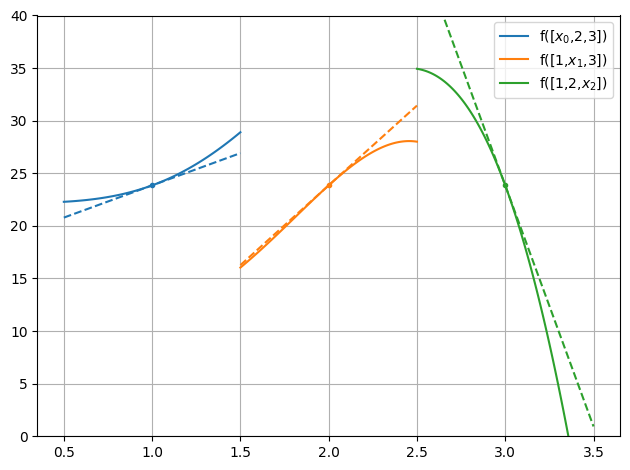

In [3]:
dx_lst = np.linspace(-.5,.5,100)

import matplotlib.pyplot as pltq
from py_wake.utils.plotting import setup_plot

for i in range(3):
    label="f([1,2,3])".replace(str(i+1),f"$x_{i}$")
    c = plt.plot(x[i] + dx_lst, [f(x + np.roll([dx,0,0],i)) for dx in dx_lst], label=label)[0].get_color()
    plt.plot(x[i]+[-.5,.5], f(x) + df(x)[i]*np.array([-.5,.5]), '--', color=c)
    plt.plot(x[i], f(x), '.', color=c)
setup_plot(ylim=[0,40])
plt.legend()

**In PyWake, gradients can be calculated via three methods: finite difference, complex step, and automatic diferentiation (AD) or autograd.**

Below is the theoretical background of each method, followed by a comparison made between the three methods in terms of simulation time required.

### Finite difference `fd`

$\frac{d f(x)}{dx} = \frac{f(x+h) - f(x)}{h}$

Finite difference applied to the example function:


In [4]:
print ("Analytical gradient:", list(df(x)))
h = 1e-6
for i in range(3):
    print (f"Finite difference gradient wrt. x{i}:", (f(x+np.roll([h,0,0],i)) - f(x))/h)

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Finite difference gradient wrt. x0: 6.129437970514573
Finite difference gradient wrt. x1: 15.164782510623809
Finite difference gradient wrt. x2: -45.839169114714196


In  this example the gradients are accurate to 4th or 5th decimal. The accuracy, however, is highly dependent on the step size, `h`. If the step size is too small the result becomes inaccurate due to nummerical issues. If the step size, on the other hand, becomes too big, then the result represents the gradient of a neighboring point.

This compromize is illusated below:

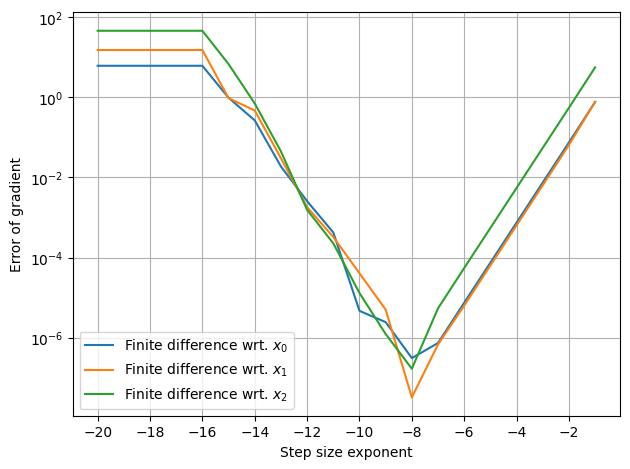

In [5]:
h_lst = 10.**(-np.arange(1,21)) # step sizes [1e-1, ..., 1e-20]

for i in range(3):
    # Plot error compared to analytical gradient, df(x)
    plt.semilogy(np.log10(h_lst), [np.abs(df(x)[i] - (f(x+np.roll([h,0,0],i))-f(x))/h) for h in h_lst], 
                 label=f'Finite difference wrt. $x_{i}$')
plt.xticks(np.arange(-20,-1,2))
setup_plot(ylabel='Error of gradient', xlabel='Step size exponent')

### Complex step

The complex step method is described [here](https://blogs.mathworks.com/cleve/2013/10/14/complex-step-differentiation/).

It utilizes that 

$\frac {d f(x)}{x}= \frac{\operatorname{Im}(f(x+ih))}{h}+O(h^2)$

Applied to the example function, the result is accurate to the 15th decimal.

In [6]:
print ("Analytical gradient:", list(df(x)))
h = 1e-10

for i in range(3):
    print (f"Finite difference gradient wrt. x{i}:", np.imag(f(x+np.roll([h*1j,0,0],i)))/h)

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Finite difference gradient wrt. x0: 6.129430520583658
Finite difference gradient wrt. x1: 15.164788859062082
Finite difference gradient wrt. x2: -45.83911438119122


Furthermore, the result is much less sensitive to the step size as seen below

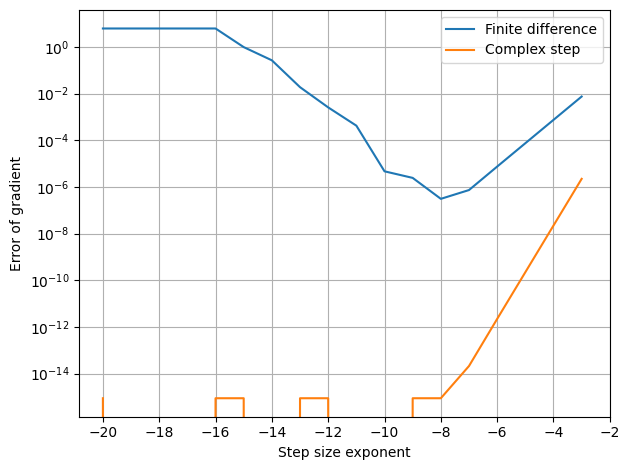

In [7]:
h_lst = 10.**(-np.arange(3,21))

plt.semilogy(np.log10(h_lst), [np.abs(df(x)[0] - (f(x+[h,0,0])-f(x))/h) for h in h_lst], label='Finite difference')
plt.semilogy(np.log10(h_lst), [np.abs(df(x)[0] - np.imag(f(x+[h*1j,0,0]))/h) for h in h_lst], label='Complex step')
plt.xticks(np.arange(-20,-1,2))
setup_plot(ylabel='Error of gradient', xlabel='Step size exponent')

**Common code changes**

The complex step method calls the function with a complex number, i.e. all intermediate functions and routines must support  complex number. A few `numpy` functions have different or undefined behaviour for complex numbers, so often a few changes is required. In PyWake, the module `py_wake.utils.gradients` contains a set of replacement functions that supports complext number, e.g.:

- `abs`
  - For a real value, `x`, `abs(x)` returns the positive value, while for a complex number, it returns the distance from 0 to z, $abs(a+bi)= \sqrt{a^2+b^2}$. 
  - In most cases `abs` should therefore be replaced by `gradients.cabs`, which returns `np.where(x<0,-x,x)`
- `np.hypot(a,b)`
  - `np.hypot` does not support complex numbers
  - replace with `gradients.hypot`, which returns `np.sqrt(a\*\*2+b\*\*2)` if `a` or `b` is complex
- `np.interp(xp,x,y)`
  - replace with `gradients.interp(xp,x,y)`
- `np.logaddexp(x,y)`
  - replace with  `gradients.logaddexp(x,y)` 
  
Furthermore, the imaginary part must be preserved when creating new arrays, i.e.
- `np.array(x,dtype=float)` -> `np.array(x,dtype=(float, np.complex128)[np.iscomplexobj(x)])`


### Automatic Differentiation (Autograd)

[Autograd](https://github.com/HIPS/autograd) is a python package that can automatically differentiate native Python and Numpy code.

Autograd performs a two step automatic differentiation process.

First the normal result is calculated and during this process autograd setups up a calculation tree where each element in the tree holds the associated gradient functions:

<center><img src="../_static/autograd_calculation.svg" width="400"/></center>

For most numpy functions, the associated gradient function is predefined when using `autograd.numpy` instead of `numpy`. You can see the autograd module that defines the gradients of numpy functions [here](https://github.com/HIPS/autograd/blob/master/autograd/numpy/numpy_vjps.py#L32) and the functions used in the example is shown here:

```python
defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
                        lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
defvjp(anp.add,         lambda ans, x, y : unbroadcast_f(x, lambda g: g),
                        lambda ans, x, y : unbroadcast_f(y, lambda g: g))
defvjp(anp.power,
    lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
    lambda ans, x, y : unbroadcast_f(y, lambda g: g * anp.log(replace_zero(x, 1.)) * x ** y))
defvjp(anp.sin,    lambda ans, x : lambda g: g * anp.cos(x))
```

In the second step, the gradients are calculated by backward propagation

<center><img src="../_static/autograd_differentiation.svg" width="400"/></center>

**Applied to the example function,** `autograd`, **gives the exact results.**

In [8]:
from py_wake import np
from py_wake.utils.gradients import autograd

def f(x):
    return np.sum((2 * x**3) * np.sin(x))

print ("Analytical gradient:", list(df(x)))
print (f"Autograd gradient:", list(autograd(f)(x)))

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Autograd gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]


Note, autograd needs its own numpy, `autograd.numpy`, to work. In PyWake, the `autograd` wrapper defined in `py_wake.utils.gradients`, handles this numpy replacement automatically. All it requires is to use `from py_wake import np` instead of the standard `import numpy as np`. This approach also allows an easy switch to single precision for faster simulation.

**Common code changes**

- `x[m] = 0` -> `x = np.where(m,0,x)`
  - Item assignment not supported
  

### Comparison - Scalability of example problem
As seen in the examples, autograd computed the gradients with respect to all input elements in one smart (but slow) function evaluation, while finite difference and complex step required `n + 1` and `n` function evaluations, respectively.

This difference has a high impact on the performance of large scale problems. The plot below shows the time required to compute the gradients as a function of the number of elements in the input vector. In this example the `fd`, `cs` and `autograd` functions from `py_wake.utils.gradients` is utilized.

    from py_wake.utils.gradients import fd, cs, autograd
    from py_wake.tests.check_speed import timeit

    n_lst = np.arange(1,3500,500)
    x_lst = [np.random.random(n) for n in n_lst]

    def get_gradients(method,x):
        return method(f, vector_interdependence=True)(x)

    for method in  [fd, cs, autograd]:
        plt.plot(n_lst, [np.mean(timeit(get_gradients, min_time=.2)(method,x)[1]) for x in x_lst], label=method.__name__)
    setup_plot(title='Time to compute gradients of f(x)', xlabel='Number of elements in x', ylabel='Time [s]')

![image1.png](images/Optimization_gradient_methods.png)

### Gradients in PyWake

As described above, PyWake, contains a module, `py_wake.utils.gradients` which defines the three methods, `fd`, `cs` and `autograd`, as well as a number of helper functions and constructs.

With only a few exceptions, all PyWake models, turbines and sites support the three gradient methods.

Unfortunately, autograd is not working very well with xarray, i.e. the normal xarray `SimulationResult` must be bypassed. This mean that you can compute gradients of the [AEP](#Gradients-of-AEP) or [WS, TI, Power and custom functions](#Gradients-of-WS,-TI,-Power-and-custom-functions) by setting the argument `return_simulationResult=False` when running the wind farm model:  `WindFarmModel(..., return_simulationResult=False)`.

Below we show a simple example with the Hornsrev1 Site and turbines while using the ZongGaussian wake model.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import Hornsrev1Site, HornsrevV80
from py_wake.utils.gradients import fd, cs, autograd
from py_wake.utils.profiling import timeit
from py_wake.utils.plotting import setup_plot
from py_wake.literature.gaussian_models import Zong_PorteAgel_2020, Bastankhah_PorteAgel_2014
from py_wake.deflection_models.jimenez import JimenezWakeDeflection
from py_wake.turbulence_models.crespo import CrespoHernandez
from py_wake.superposition_models import LinearSum
from py_wake.utils.layouts import rectangle

In [18]:
site = Hornsrev1Site()
wt = HornsrevV80()
wfm = Zong_PorteAgel_2020(site, wt, deflectionModel=JimenezWakeDeflection(), superpositionModel= LinearSum())

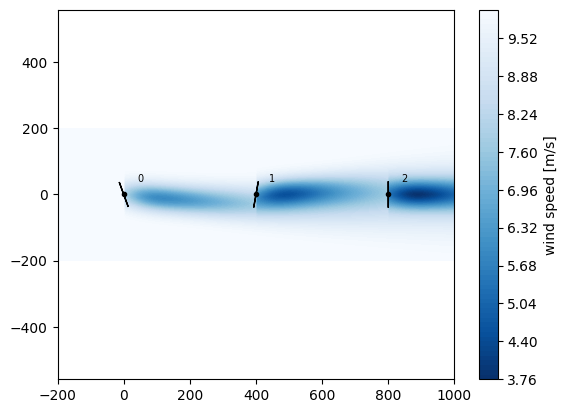

In [19]:
x,y = rectangle(3,3, wt.diameter()*5)
wfm(x,y,wd=[270],ws=10, yaw=[20,-10,0], tilt=0).flow_map().plot_wake_map()

#### Gradients of AEP
The gradients of the AEP can be computed by the `aep_gradients` method of `WindFarmModel` with respect to most of the input arguments. 

In [20]:
for wrt_arg in ['x','y',['x','y'],'h']:
    daep = wfm.aep_gradients(gradient_method=autograd, wrt_arg=wrt_arg)(x=x,y=y, h=[69,70,71], yaw=[20,-10,1], tilt=0)
    print (f"Gradients of AEP wrt. {wrt_arg}", daep)

Gradients of AEP wrt. x [array([-0.00127428, -0.0001223 ,  0.00139658])]
Gradients of AEP wrt. y [array([ 0.00021054, -0.00043951,  0.00022897])]
Gradients of AEP wrt. ['x', 'y'] [array([-0.00127428, -0.0001223 ,  0.00139658]), array([ 0.00021054, -0.00043951,  0.00022897])]
Gradients of AEP wrt. h [array([-2.43899073e-04, -8.14497165e-06,  2.52044045e-04])]


**AEP gradients with respect to (x,y) or (xy)**

When computing gradients with autograd, a significant speed up (40-50%) can be obtained by computing the gradients with respect to both `x` and `y` in one go:

```
wfm.aep_gradients(gradient_method=autograd, wrt_arg=['x','y'])(x,y)
```

Instead of first computing with respect to `x` and then with respect to `y`,

```
wfm.aep_gradients(gradient_method=autograd, wrt_arg='x')(x,y)
wfm.aep_gradients(gradient_method=autograd, wrt_arg='y')(x,y)
```

Functionality to do this automatically under the hood has been implemented in the autograd function.

For finite difference and complex step, the speed is similar.

    from tqdm.notebook import tqdm
    wfm = BastankhahGaussian(site, wt)

    def get_aep(wrt_arg_lst, method):
        return lambda x,y: [wfm.aep_gradients(gradient_method=method, wrt_arg=wrt_arg)(x,y) for wrt_arg in wrt_arg_lst]

    N_lst = np.arange(100,600,100) # number of wt
    D = wt.diameter()
    method=autograd
    res = [(wrt_arg_lst,method, [np.mean(timeit(get_aep(wrt_arg_lst, method=method), min_runs=1)(*rectangle(N,5,D*5))[1]) 
                                 for N in tqdm(N_lst)])
           for wrt_arg_lst in (['x','y'],[['x','y']])]

    ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
    ax1.plot(N_lst, res[0][2], label=f"Wrt. (x), (y), {res[0][1].__name__}")[0].get_color()
    ax1.plot(N_lst, res[1][2], label=f"Wrt. (x, y), {res[1][1].__name__}")
    ax2.plot(N_lst, (np.array(res[0][2]) - res[1][2])/res[0][2]*100)

    setup_plot(ax=ax1, title='Time to compute AEP gradients', ylabel='Time [s]', xlabel='Number of wind turbines')
    setup_plot(ax=ax2, title="Speedup of (xy) compared to (x,y)", ylabel='Speedup [%]', xlabel='Number of wind turbines', ylim=[0,60])

![image2.png](images/Optimization_xy.svg)

**Gradients of WS, TI, Power and custom functions**

The normal `WindFarmModel.__call__` method, which is invoked by `wfm(x,y,...)` returns a xarray Dataset SimulationResult. This step breaks the autograd data flow. We therefore need to specify the argument `return_simulationResult=False`.

The relevant output is:

    WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk, *_ = WindFarmModel(..., return_simulationResult=False)

**Below are a two basic examples**

**1) Mean power wrt (x,y) - 2 x 1D inputs, one output**

Compute the gradients of the mean power with respect to both x and y.

Note, there is no need to convert it to a one-merged-input function, as the autograd method in PyWake does this under the hood

In [ ]:
def mean_power(x,y):
    power_ilk = wfm(x=x, y=y, yaw=0, tilt=0, return_simulationResult=False)[2] # index 2 = power_ilk
    return power_ilk.mean()

mean_power_gradients_function = autograd(mean_power,vector_interdependence=True, argnum=[0,1])
d_aep = mean_power_gradients_function(x, y)

print ('AEP Gradients:',d_aep)
print (np.shape(d_aep))

**2) Power per wind speed wrt. x - 1D input, 1D output**

Compute the gradients of the power per wind speed (i.e. power meaned over wind turbine and direction) with respect to x.

In [ ]:
def ws_power(x):
    power_ilk = wfm(x=x, y=y, yaw=0, tilt=0, return_simulationResult=False)[2] # index 2 = power_ilk
    return power_ilk.mean((0,1)) # mean power pr wind speed

ws_power_gradients_function = autograd(ws_power,vector_interdependence=True)
np.shape(ws_power_gradients_function(x))

**Manual gradient functions for autograd**

Autograd can be supplemented with custom gradient functions, that bypass the automatic differentiation process and returns the gradients directly.
This is usefull for functions that cannot be analytically differentiated by autograd, e.g. interpolation functions. Some commonly used functions have been implemented in `py_wake.utils.gradients`, e.g.

- trapz (np.trapz)
- interp (np.interp)
- PchipInterpolator (scipy.PchipInterpolator)
- UnivariateSpline (scipy.UnivariateSpline)


Specifying the gradient functions and ensuring that they return the gradients in the right dimensions is, however, not trivial. 

It was expected that the computational time could be reduced by specifying maually-implemented gradient functions of some time-critical functions. An example is shown below, where functions to calculate the gradients of `calc_deficit` of the `BastankhahGaussianDeficit` with respect to all inputs are implemented.

In [ ]:
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.utils.gradients import set_vjp
from py_wake.utils.model_utils import method_args
import warnings

class BastankhahGaussianDeficitGradients(BastankhahGaussianDeficit):
    def __init__(self, k=0.0324555, ceps=.2, use_effective_ws=False):
        BastankhahGaussianDeficit.__init__(self, k=k, ceps=ceps, use_effective_ws=use_effective_ws)
        self._additional_args = method_args(self.calc_deficit)
        self.use_effective_ws = use_effective_ws
        self.calc_deficit = set_vjp([self.get_ddeficit_dx(i) for i in range(6)])(self.calc_deficit)

    @property
    def additional_args(self):
        return BastankhahGaussianDeficit.additional_args.fget(self) | self._additional_args

    def calc_deficit(self, WS_ilk, WS_eff_ilk, D_src_il, dw_ijlk, cw_ijlk, ct_ilk, **kwargs):
        return BastankhahGaussianDeficit.calc_deficit(self, D_src_il, dw_ijlk, cw_ijlk, ct_ilk,
                                                      WS_ilk=WS_ilk, WS_eff_ilk=WS_eff_ilk, **kwargs)

    def get_ddeficit_dx(self, argnum):
        import numpy as np  # override autograd.numpy
        from numpy import newaxis as na

        def ddeficit_dx(ans, WS_ilk, WS_eff_ilk, D_src_il, dw_ijlk, cw_ijlk, ct_ilk, **kwargs):
            _, _, _, K = np.max([dw_ijlk.shape, cw_ijlk.shape, WS_ilk[:, na].shape], 0)
            eps = 0
            WS_ref_ilk = (WS_ilk, WS_eff_ilk)[self.use_effective_ws]
            ky_ilk = self.k_ilk(**kwargs)
            beta_ilk = 0.5 * (1 + 1 / np.sqrt(1 - ct_ilk))
            sigma_ijlk = ky_ilk[:, na] * dw_ijlk * (dw_ijlk > eps) + \
                .2 * D_src_il[:, na, :, na] * np.sqrt(beta_ilk[:, na])
            a_ijlk = ct_ilk[:, na] / (8. * (sigma_ijlk / D_src_il[:, na, :, na])**2)
            sqrt_ijlk = np.sqrt(np.maximum(0., 1 - a_ijlk))
            layout_factor_ijlk = WS_ref_ilk[:, na] * (dw_ijlk > eps) * np.exp(-0.5 * (cw_ijlk / sigma_ijlk)**2)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if argnum == 0:
                    dWS = ans / WS_ref_ilk[:, na]
                elif argnum == 1:
                    dWS_eff = ans / WS_eff_ilk[:, na]
                elif argnum == 2:
                    dD_sqrt_pos = (a_ijlk * (1 / D_src_il[:, na, :, na] - 0.2 * np.sqrt(beta_ilk[:, na]) / sigma_ijlk) / sqrt_ijlk +
                                   (1 - sqrt_ijlk) * (cw_ijlk**2 / sigma_ijlk**3) * .2 * np.sqrt(beta_ilk[:, na])) * layout_factor_ijlk
                    dD_sqrt_neg = (cw_ijlk**2 / sigma_ijlk**3) * .2 * np.sqrt(beta_ilk[:, na]) * layout_factor_ijlk
                    dD = np.where(sqrt_ijlk == 0, dD_sqrt_neg, dD_sqrt_pos)
                elif argnum == 3:
                    ddw_sqrt_pos = (-a_ijlk / sqrt_ijlk + (1 - sqrt_ijlk) * (cw_ijlk / sigma_ijlk)**2) * \
                        ky_ilk[:, na] / sigma_ijlk * layout_factor_ijlk
                    ddw_sqrt_neg = (cw_ijlk / sigma_ijlk)**2 * ky_ilk[:, na] / sigma_ijlk * layout_factor_ijlk
                    ddw = np.where(sqrt_ijlk == 0, ddw_sqrt_neg, ddw_sqrt_pos)
                elif argnum == 4:
                    dcw = ans * (- cw_ijlk / (sigma_ijlk**2))
                elif argnum == 5:
                    dsigmadct_ilk = 0.2 * D_src_il[:, :, na] / (8 * np.sqrt(beta_ilk * (1 - ct_ilk)**3))
                    dct_sqrt_pos = (a_ijlk * (1 / (2 * ct_ilk[:, na]) - dsigmadct_ilk[:, na] / sigma_ijlk) / sqrt_ijlk +
                                    (1 - sqrt_ijlk) * (cw_ijlk**2 / sigma_ijlk**3) * dsigmadct_ilk[:, na]) * layout_factor_ijlk
                    dct_sqrt_neg = (cw_ijlk**2 / sigma_ijlk**3) * dsigmadct_ilk[:, na] * layout_factor_ijlk
                    dct = np.where(sqrt_ijlk == 0, dct_sqrt_neg, dct_sqrt_pos)

            def dWS_ilk(g):
                r = g * dWS[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                ilk = (slice(None), j)
                return r[ilk]

            def dWS_eff_ilk(g):
                r = g * dWS_eff[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                ilk = (slice(None), j)
                return r[ilk]

            def dD_src_il(g):
                r = g * dD[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                k = np.r_[np.where(g)[3], 0][0]
                il = (slice(None), j, slice(None), k)
                return r[il]

            def ddw_ijlk(g):
                r = g * ddw[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                if dw_ijlk.shape[-1] == 1 and K > 1:
                    # If dw_ijlk is independent of ws, i.e. last dimension is 1 while len(ws)>1
                    # then we need to sum the gradients wrt. wind speeds
                    r = r.sum(3)[:, :, :, na]
                return r[:, :, :, 0:dw_ijlk.shape[3]]

            def dcw_ijlk(g):
                r = g * dcw[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                if cw_ijlk.shape[-1] == 1 and K > 1:
                    # If cw_ijlk is independent of ws, i.e. last dimension is 1 while len(ws)>1
                    # then we need to sum the gradients wrt. wind speeds
                    r = r.sum(3)[:, :, :, na]
                return r[:, :, :, 0:cw_ijlk.shape[3]]

            def dct_ilk(g):
                r = g * dct[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                ilk = (slice(None), j)
                return r[ilk]

            return [dWS_ilk, dWS_eff_ilk, dD_src_il, ddw_ijlk, dcw_ijlk, dct_ilk][argnum]
        return ddeficit_dx


In this example, however, the model with manual gradient functions performs worse than the original where autograd derives the gradient functions automatically.

In [ ]:
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.examples.data.hornsrev1 import wt16_x, wt16_y

wfm_autograd = PropagateDownwind(site, wt, BastankhahGaussianDeficit())
wfm_manual = PropagateDownwind(site, wt, BastankhahGaussianDeficitGradients())

ws = np.arange(4,26)
x,y = wt16_x, wt16_y
ref, t_auto = timeit(lambda: wfm_autograd.aep_gradients(gradient_method=autograd, wrt_arg=['x','y'])(x, y, ws=ws))()
res, t_manual = timeit(lambda: wfm_manual.aep_gradients(gradient_method=autograd, wrt_arg=['x','y'])(x, y, ws=ws))()
np.testing.assert_array_almost_equal(res, ref, 4)

print ("Time, automatic gradients", np.mean(t_auto))
print ("Time, manual gradients", np.mean(t_manual))

### Comparison - Scalability of AEP gradients

As seen in the previous comparison of scalability example, the autograd scales much better with the number of input variables than finite difference and complex step. 

When considering large wind farms, autograd is convincingly outperforming both finite difference and complex step, but it also requires much more memory.

**The following plots are based on simulation performance on the Sophia HPC cluster.**

In [ ]:
data = {
    "fd":((10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150,200, 250, 300),
          [0.89, 3.06, 7.13, 14.77, 24.46, 41.06, 64.46, 105.98, 140.76, 171.53, 590.46, 1501.62, 2957.65, 4904.31],
          [14.1, 31.9, 58.8, 92.2, 135.3, 184.2, 240.6, 303.1, 373.6, 450.7, 946.5, 1620.8, 2470.1, 3500.5]),   
"cs":((10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250),
      [1.18, 4.9, 12.44, 25.58, 44.56, 72.82, 115.46, 171.42, 245.15, 312.9, 960.64, 2883.04, 5345.27],
      [22.3, 55.7, 107.6, 171.0, 244.1, 338.7, 442.7, 566.9, 690.9, 839.0, 1787.4, 3088.9, 4742.4]),
"autograd":((10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            [0.32, 0.78, 1.52, 2.49, 3.75, 5.33, 7.14, 9.12, 11.43, 14.02, 32.35, 53.73, 84.94, 130.53, 169.34, 229.62, 270.19, 342.01],
            [26.7, 92.9, 196.4, 340.0, 525.9, 749.6, 1011.1, 1312.2, 1656.0, 2039.7, 4555.0, 8066.8, 12569.9, 18072.6, 24568.2, 32069.6, 40558.9, 50036.6]),
       }
ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
for k,(n,t,m) in data.items():
    ax1.plot(n,np.array(t)/60, label=k)
    ax2.plot(n,np.array(m)/1024, label=k)
setup_plot(ax1, xlabel='Number of wind turbines', ylabel='Time [min]')
setup_plot(ax2, xlabel='Number of wind turbines', ylabel='Memory usage [GB]')
plt.savefig('test.png', dpi=600)
import os
os.getcwd()

## Chunkify and Parallelization

PyWake makes it easy to chunkify the run wind farm simulations see also section [Run Wind Farm Simulation](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/RunWindFarmSimulation.html).

This construct is also available and usefull when computing gradients to reduce the memory usage and/or speed up the computation by parallel execution.

The arguments, `wd_chunks`, `ws_chunks` and `n_cpu` are available in the `WindFarmModel.aep(...)`, `WindFarmModel(...)` and `WindFarmModel.aep_gradients(...)` methods.


In [ ]:
from py_wake import np
import matplotlib.pyplot as plt

from py_wake.literature.noj import Jensen_1983
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, HornsrevV80, wt_x, wt_y, wt16_x, wt16_y
from py_wake.utils.profiling import timeit
import multiprocessing
from py_wake.utils.gradients import autograd, fd
from py_wake.utils.plotting import setup_plot

In [ ]:
site = Hornsrev1Site()
wt = HornsrevV80()
wfm = Jensen_1983(site, wt)
x,y = wt16_x,wt16_y

### AEP

Computing AEP in parallel chunks.

Setting `n_cpu=None`, splits the problem into `N` wind direction chunks which is computed in parallel on `N` CPUs, where `N` is the number of CPUs on the machine. Alternatively, a number can be specified.

In [ ]:
print('Total AEP: %f GWh'%wfm.aep(x, y, n_cpu=None))

### WS, TI, Power and custom functions

Computing mean power in parallel chunks

In [ ]:
def mean_power(x,y):
    power_ilk = wfm(x=x, y=y, n_cpu=None, return_simulationResult=False)[2] # index 2 = power_ilk
    return power_ilk.mean()

print('Mean Power: %f MW'%(mean_power(x,y)/1e6))

### AEP gradients

In the previous section, [Gradients of AEP](#Gradients-of-AEP), the `aep_gradients` method was used like this:

```python
gradient_function = wfm.aep_gradients(fd, wrt_arg='xy')
daep = gradient_function(x=x,y=y)
```

When dealing with chunkification and/or parallelization, the `aep_gradients` must be used in a slightly different way:

In [ ]:
daep = wfm.aep_gradients(autograd, wrt_arg=['x','y'], n_cpu=None, x=x, y=y)

Note, in this case, the arguments normally passed to `wfm.aep` (here `x` and `y`) are passed directly to the `wfm.aep_gradients` method as keyword arguments and the method returns the gradients results instead of a function.

**The plot below shows the time it takes to compute the gradients of AEP with respect to x and y plotted as a function of number of wind turbines and CPUs**

    from py_wake.utils import layouts 
    from py_wake.utils.profiling import timeit
    from tqdm.notebook import tqdm

    n_lst = np.arange(100,600,100)

    def run(n, n_cpu):
        x,y = layouts.rectangle(n,20,5*wt.diameter())
        return (n, n_cpu, np.mean(timeit(wfm.aep_gradients)(autograd, ['x','y'], n_cpu=n_cpu, x=x,y=y)[1]))

    res = {f'{n_cpu} CPUs': np.array([run(n, n_cpu=n_cpu) for n in tqdm(n_lst)]) for n_cpu in [1, 4, 16, 32]}

    ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
    for k,v in res.items():
        n,n_cpu,t = v.T
        ax1.plot(n, t, label=k)
        ax2.plot(n, res['1 CPUs'][:,2]/n_cpu/t*100, label=k)
    setup_plot(ax=ax1,xlabel='No. wind turbines',ylabel='Time [s]')
    setup_plot(ax=ax2,xlabel='No. wind turbines',ylabel='CPU utilization [%]')
    plt.savefig('images/Optimization_time_cpuwt.svg')

**Result precomputed on the Sophia HPC cluster on a node with 32 CPUs.**



**Parallelization of gradients of WS, TI, Power and custom functions is not implemented yet**

## Precision

**As default, PyWake simulates in double precision, i.e. 64 bit floating point values.**

In some cases, however, single precision, i.e. 32 bit floating point values, may be sufficient and faster. 

In PyWake, the `Numpy32` context manager makes switching to single precition is very easy:

In [ ]:
from py_wake.utils.numpy_utils import Numpy32

with Numpy32():
    print (np.array([1.,2,3]).dtype)
    print (np.sin([1,2,3]).dtype)

In [ ]:
# same with out context manager
print (np.array([1.,2,3]).dtype)
print (np.sin([1,2,3]).dtype)

    from py_wake.utils import layouts 
    from py_wake.utils.profiling import timeit
    from tqdm.notebook import tqdm

    n_lst = np.arange(50,550,50)
    xy_lst = [layouts.rectangle(n,20,5*wt.diameter()) for n in n_lst]

    t_lst_64 = [np.mean(timeit(wfm.aep, min_runs=10)(x,y)[1]) for x,y in tqdm(xy_lst)]

    with Numpy32():
        t_lst_32 = [np.mean(timeit(wfm.aep, min_runs=10)(x,y)[1]) for x,y in tqdm(xy_lst)]

    ax1, ax2 = plt.subplots(1,2,figsize=(12,4))[1]
    ax1.plot(n_lst, t_lst_64, label='Double precision')
    ax1.plot(n_lst, t_lst_32, label='Single precision')
    setup_plot(ax=ax1, ylabel='Time [s]',xlabel='No. wind turbines')
    ax2.plot(n_lst, np.array(t_lst_64) / t_lst_32)
    setup_plot(ax=ax2, ylabel='Speedup',xlabel='No. wind turbines')
    plt.savefig('images/Optimization_precision.svg')

**Result precomputed on the Sophia HPC cluster.**

![image1.png](images/Optimization_precision.svg)

# Ground Models

The ground models in PyWake are used to model the effects that the ground has on the inflow and wake.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

### Mirror
The Mirror ground model allows enforcing a slip boundary condition (zero wall normal velocity) at the ground level. This is achieved by mirroring the turbine in the ground plane, an approach from potential flow theory.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Here it is shown for a turbine with wake and blockage. 

Text(0, 0.5, 'y [m]')

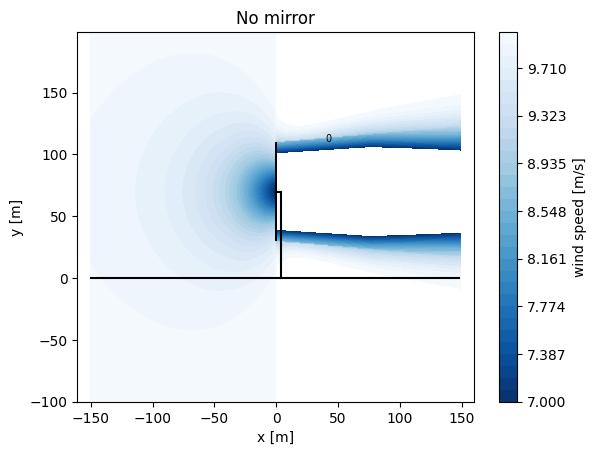

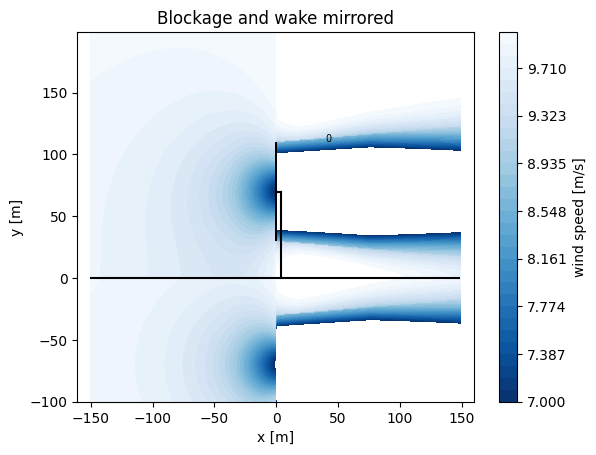

In [3]:
from py_wake.ground_models import Mirror
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import SelfSimilarityDeficit2020, NiayifarGaussianDeficit
from py_wake.turbulence_models import CrespoHernandez
from py_wake.flow_map import YZGrid

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

#----------
wfm = All2AllIterative(site, windTurbines, 
                       wake_deficitModel=NiayifarGaussianDeficit(), 
                       blockage_deficitModel=SelfSimilarityDeficit2020(),
                       turbulenceModel=CrespoHernandez())
plt.figure()
plt.title('No mirror')
ws = 10.
levels = np.linspace(7., 10., 32)
x, y, z = 0, np.arange(-150, 150, 1), np.arange(-100, 200)
wfm([0], [0], wd=180., ws=ws).flow_map(YZGrid(x=x, y=y + .1, z=z)).plot_wake_map(levels=levels)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

#----------
wfm = All2AllIterative(site, windTurbines, 
                       wake_deficitModel=NiayifarGaussianDeficit(groundModel=Mirror()), 
                       blockage_deficitModel=SelfSimilarityDeficit2020(groundModel=Mirror()),
                       turbulenceModel=CrespoHernandez())

plt.figure()
plt.title('Blockage and wake mirrored')
wfm([0], [0], wd=180., ws=ws).flow_map(YZGrid(x=x, y=y + .1, z=z)).plot_wake_map(levels=levels)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

However, many wake models have been calibrated including ground effects and thus do usually not requiere a ground model. In fact this can lead to double counting, leading to excessive deficits. 
Blockage models on the other hand are usually calibrated without ground effects and need a ground model. This is why in PyWake one can set the ground model for blockage and wakes independantly. 

Text(0, 0.5, 'y [m]')

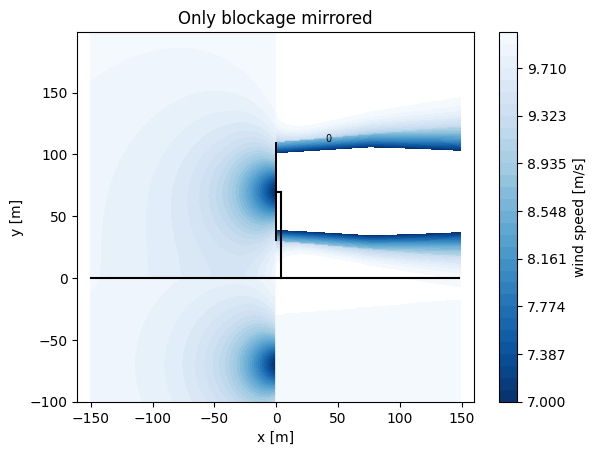

In [4]:
#----------
wfm = All2AllIterative(site, windTurbines, 
                       wake_deficitModel=NiayifarGaussianDeficit(), 
                       blockage_deficitModel=SelfSimilarityDeficit2020(groundModel=Mirror()),
                       turbulenceModel=CrespoHernandez())

plt.figure()
plt.title('Only blockage mirrored')
wfm([0], [0], wd=180., ws=ws).flow_map(YZGrid(x=x, y=y + .1, z=z)).plot_wake_map(levels=levels)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### MultiMirror

To model additional blocking effect from relatively low and strong temperature inversions in the atmoshperic boundary layer - something first proposed by the Offshore Wind Accelerator (OWA) - another mirror plane could be added above the turbine.

The following scripts runs the `SelfSimilarity2020()` blockage model with different ground models. Either without any mirrors, with the usual ground mirror and the `MultiMirror()` class. It takes the height of the mirror aloft as an input and how many times the extra mirrors should be reflected in each other. By default only the ground and mirror aloft are enforced,  (`n_mirrors = 2 + n_reps`). Be aware that the number of turbines grows quickly, such that for a single turbine the actual number becomes `n_turbines = 2^(n_mirrors)`. There is also a verification setup where the imaginary turbines are explicity defined and placed in the horizontal plane instead (only equivalent to `n_reps=0`).   

Compared are contours of normalised deficit in very close proximity to the rotor. The thrust is set very high,`ct=1.`, and the mirror plane just above the rotor to emphasize changes.   

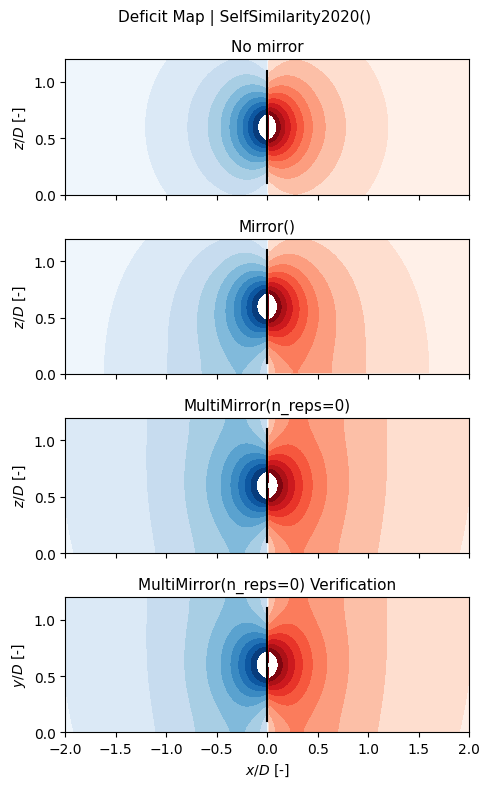

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.ground_models import MultiMirror
from py_wake.flow_map import XYGrid, XZGrid
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.site._site import UniformSite

# create dummy sites and turbine
class Dummy(WindTurbine):
    def __init__(self, name='dummy', ct=1.0, D=1., zh=1.5):
        WindTurbine.__init__(self, name=name, diameter=D,
                             hub_height=zh, powerCtFunction=PowerCtTabular([-100, 100], [0, 0], 'kW', [ct, ct]))

class BastankhahSite(UniformSite):
    def __init__(self, ws=1., ti=0.1):
        UniformSite.__init__(self, ti=ti, ws=ws)


ct = 1.
D = 1.
hub_height = 0.6 * D
mirror_height = 1.2 * D

x = np.linspace(-2.* D, 2. * D, 401)
y = np.linspace(0., 1.2 * D, 201)
hgrid = XYGrid(x=x, y=y)
vgrid = XZGrid(0.0, x=x, z=y)

bmodels = {
           "No mirror" : SelfSimilarityDeficit2020(),
           "Mirror()" : SelfSimilarityDeficit2020(groundModel=Mirror()),
           "MultiMirror(n_reps=0)" : SelfSimilarityDeficit2020(groundModel=MultiMirror(mirror_height, n_reps=0)),
           "MultiMirror(n_reps=0) Verification" : SelfSimilarityDeficit2020(),
}
wfms = []
for name, bmodel in bmodels.items():
    wfms.append(All2AllIterative(BastankhahSite(), Dummy(ct=ct, D=D, zh=hub_height), 
                                 wake_deficitModel=NoWakeDeficit(), 
                                 blockage_deficitModel=bmodel))   

fms = []
for i in range(len(wfms) - 1):
    fms.append(wfms[i](x=[0], y=[0], wd=270., ws=1.).flow_map(vgrid))
wt_y = [hub_height, 
        -hub_height, 
        mirror_height + (mirror_height - hub_height), 
        mirror_height + (mirror_height - hub_height) + 2 * hub_height]
fms.append(wfms[-1](x=[0, 0, 0, 0], y=wt_y, 
                    wd=270., ws=1.).flow_map(hgrid))


cmap = np.r_[cm.Reds_r(np.linspace(-0,1,127)),[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))]
levels=np.linspace(-0.35, 0.35, 21)
fig, ax = plt.subplots(len(fms), 1, sharex=True, sharey=True, figsize=(5, 8))

for i, (name, model) in enumerate(bmodels.items()):
    if i < len(bmodels) - 1:
        ax[i].contourf(fms[i].x / D, fms[i].h / D, 1. - np.squeeze(fms[i].WS_eff), 
                    cmap=ListedColormap(cmap), levels=levels)
        ax[i].plot([0, 0], [-D / 2. + hub_height, D / 2. + hub_height], 'k-')
        ax[i].set_ylabel('$z/D$ [-]')
    else:
        ax[i].contourf(fms[i].x / D, fms[i].y / D, 1. - np.squeeze(fms[i].WS_eff), 
                    cmap=ListedColormap(cmap), levels=levels)
        ax[i].plot([0, 0], [-D / 2. + hub_height, D / 2. + hub_height], 'k-')
        ax[i].set_ylabel('$y/D$ [-]')
    
    ax[i].set_title(name, fontsize=11)
    
ax[-1].set_xlabel('$x/D$ [-]')
fig.suptitle('Deficit Map | SelfSimilarity2020()', fontsize=11)
fig.tight_layout()

# Noise

PyWake contains a simple noise-progagation model, `ISONoise`, which models the sound-pressure level from a number of sound sources (wind turbines) at a number of receivers taking into account:

- Spherical geometrical spreading (DSF/ISO/DIS 9613-2)
- Ground reflection/absorption (DSF/ISO/DIS 9613-2)
- Atmospheric absorption (DS/ISO 9613-1:1993)


The model is based on the iso standards:

```
DSF/ISO/DIS 9613-2
Acoustics – Attenuation of sound during propagation – Part 2:
Engineering method for the prediction of sound pressure levels outdoors
```

and

```
DS/ISO 9613-1:1993
Akustik. Måling og beskrivelse af ekstern støj. Lydudbredelsesdæmpning udendørs. Del 1:
Metode til beregning af luftabsorption
```

The implementation and interface is preliminary and may be subject to changes

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from py_wake.noise_models.iso import ISONoiseModel

from py_wake.deficit_models.gaussian import ZongGaussian
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models.crespo import CrespoHernandez
from py_wake.site._site import UniformSite
from py_wake.examples.data.swt_dd_142_4100_noise.swt_dd_142_4100 import SWT_DD_142_4100
from py_wake.utils.layouts import rectangle
from py_wake.utils.plotting import setup_plot

## Sound source

To model the emitted sound from the wind turbine sources, the `WindTurbine` object must contain a `sound_power_level`-function.

An example wind turbine, `SWT_DD_142_4100`, is implemented in `py_wake.examples.data.swt_dd_142_4100_noise.swt_dd_142_4100` based on power, ct and noise data from the wind turbine catalogue in [WindPro](https://www.emd-international.com/software/) (demo version).

This wind turbine are able to operate at 7 different modes with reduced power and noise.

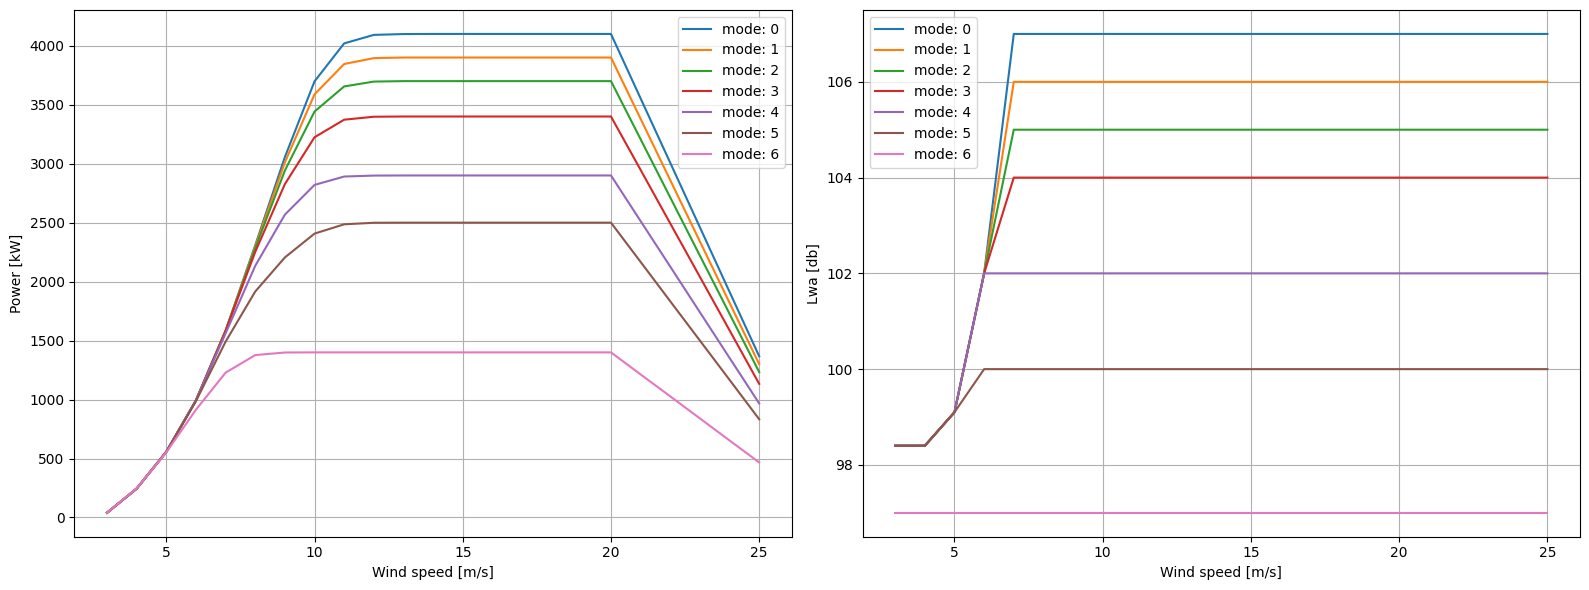

In [3]:
wt = SWT_DD_142_4100()

ax1,ax2 = plt.subplots(1,2,figsize=(16,6))[1]
ws = np.arange(3, 26)
for m in range(7):
    ax1.plot(ws, wt.power(ws, mode=m) / 1000, label=f'mode: {m}')
    ax2.plot(ws, wt.ds.LwaRef.sel(mode=m, ws=ws), label=f'mode: {m}')

setup_plot(ax=ax1, xlabel='Wind speed [m/s]', ylabel='Power [kW]')
setup_plot(ax=ax2, xlabel='Wind speed [m/s]', ylabel='Lwa [db]')

Furthermore, the sound-power level is available as a function of mode, wind speed and frequency  

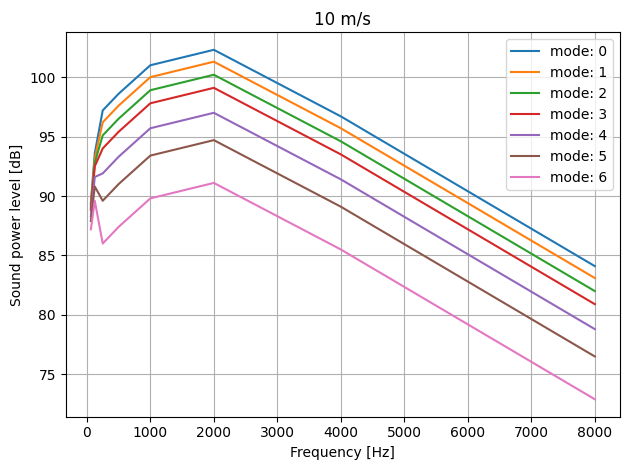

In [4]:
for m in range(7):
    freq, sound_power = wt.sound_power_level(ws=10, mode=m)
    plt.plot(freq, sound_power[0], label=f'mode: {m}')
setup_plot(xlabel='Frequency [Hz]', ylabel='Sound power level [dB]', title="10 m/s")

## Noise at receivers
To model the noise at specific receiver positions, we first need to setup a `WindFarmModel´ and run a simulation

In [5]:
wt = SWT_DD_142_4100()
wfm = ZongGaussian(UniformSite(), wt, turbulenceModel=CrespoHernandez())
x, y = rectangle(5, 5, 5 * wt.diameter())
sim_res = wfm(x, y, wd=270, ws=8, mode=[0,0,6,0,0])

C:\mmpe\programming\python\Topfarm\PyWake\py_wake\deficit_models\gaussian.py:403: UserWarning: The ZongGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Zong_PorteAgel_2020 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Zong_PorteAgel_2020')


In this case the wind farm consist of 5 wind turbines in a row aligned with the wind. 
Wind turbines, 0,1 and 3,4 operate in mode 0 while wind turbin 2 is running in the most derated and silent mode. 

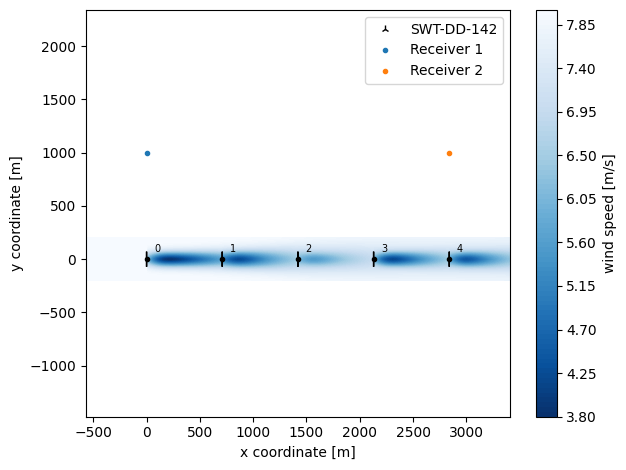

In [6]:
sim_res.flow_map().plot_wake_map()
plt.plot([x[0]], [1000], '.', label='Receiver 1')
plt.plot([x[-1]], [1000], '.', label='Receiver 2')
setup_plot(grid=False, xlabel='x coordinate [m]', ylabel='y coordinate [m]')

We can no model the sound pressure level at the two recievers. In this case the upstream wind turbines operates at higher wind speed than the down wind turbines, and therefore a higher sound pressure level will be reveived at receiver 1. 

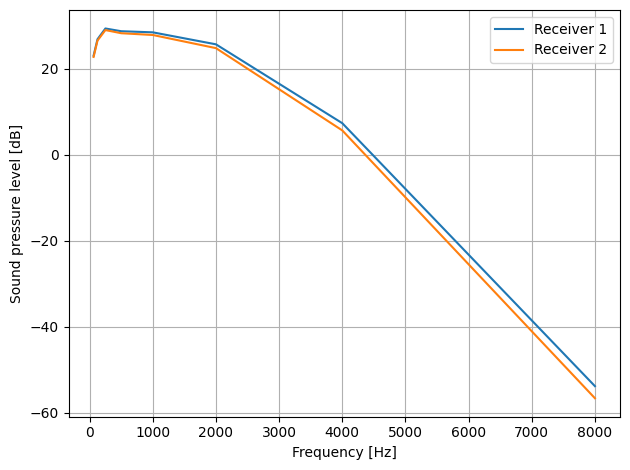

In [8]:
nm = sim_res.noise_model()
total_sp_jlk, spl_jlkf = nm(rec_x=[x[0], x[-1]], rec_y=[1000, 1000], rec_h=2, patm=101325, Temp=20, RHum=80, ground_type=0.0)
plt.plot(nm.freqs, spl_jlkf[0, 0, 0], label='Receiver 1')
plt.plot(nm.freqs, spl_jlkf[1, 0, 0], label='Receiver 2')
setup_plot(xlabel='Frequency [Hz]', ylabel='Sound pressure level [dB]')

Finally, a sound map can be generated

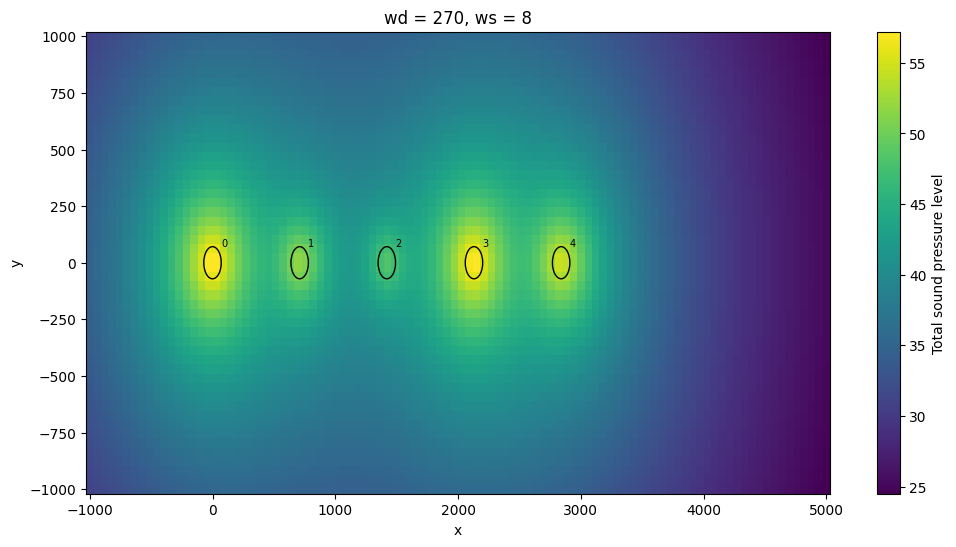

In [9]:
plt.figure(figsize=(12,6))
nmap = sim_res.noise_map(grid=XYGrid(x=np.linspace(-1000, 5000, 100), y=np.linspace(-1000, 1000, 50), h=2))
nmap['Total sound pressure level'].squeeze().plot()
wt.plot(x, y)

# Optimization with TOPFARM

This section describes two optimization examples: a layout optimization with AEP and power production optimization with a de-ratable wind turbine.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In the following sections the examples are optimized using [TOPFARM](https://topfarm.pages.windenergy.dtu.dk/TopFarm2/), an open source Python package developed by DTU Wind Energy to help with wind-farm optimizations. It has a lot of nice built-in features and wrappers.

**Install TOPFARM if needed**

In [2]:
# Install TopFarm if needed
try:
    import topfarm
except ImportError:
    !pip install topfarm --user

C:\Anaconda3_2019_10\envs\py39\lib\site-packages\openmdao\utils\general_utils.py:128: OMDeprecationWarning:simple_warning is deprecated. Use openmdao.utils.om_warnings.issue_warning instead.
C:\Anaconda3_2019_10\envs\py39\lib\site-packages\openmdao\utils\notebook_utils.py:157: UserWarning:Tabulate is not installed. Run `pip install openmdao[notebooks]` to install required dependencies. Using ASCII for outputs.
C:\Anaconda3_2019_10\envs\py39\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


### Example 1 - Optimize AEP wrt. wind turbine position (x,y)

In this example we optimize the AEP of the IEAWind Task 37 Case Study 1.

As TOPFARM already contains a cost model component, `PyWakeAEPCostModelComponent`, for this kind of problem, setting up the problem is really simple.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing

#setting up pywake models
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37WindTurbines
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.utils.gradients import autograd, fd, cs
from py_wake.utils.plotting import setup_plot

#setting up topfarm models
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.constraint_components.boundary import CircleBoundaryConstraint, XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver

#wind farm model for the IEA 37 site
def IEA37_wfm(n_wt, n_wd):
    site = IEA37Site(n_wt)
    site.default_wd = np.linspace(0,360,n_wd, endpoint=False)
    wt = IEA37WindTurbines()
    return IEA37SimpleBastankhahGaussian(site, wt)

#wind farm model for the Hornsrev1 site
Hornsrev1_wfm = Bastankhah_PorteAgel_2014(Hornsrev1Site(), V80(), k=0.0324555)

#function to create a topfarm problem, following the elements of OpenMDAO architecture
def get_topfarmProblem_xy(wfm, grad_method, maxiter, n_cpu):
    x, y = wfm.site.initial_position.T
    boundary_constr = [XYBoundaryConstraint(np.array([x, y]).T),
                       CircleBoundaryConstraint(center=[0, 0], radius=np.round(np.hypot(x, y).max()))][int(isinstance(wfm.site, IEA37Site))]
    
    return TopFarmProblem(design_vars={'x': x, 'y': y},
                          cost_comp=PyWakeAEPCostModelComponent(windFarmModel=wfm, n_wt=len(x),
                                                                grad_method=grad_method, n_cpu=n_cpu,
                                                                wd=wfm.site.default_wd, ws=wfm.site.default_ws),
                          driver=EasyScipyOptimizeDriver(maxiter=maxiter),
                          constraints=[boundary_constr,
                                       SpacingConstraint(min_spacing=2 * wfm.windTurbines.diameter())])

In [4]:
#we create a function to optimize the problem and plot the results in terms of AEP and simulation time
def optimize_and_plot(wfm, maxiter, skip_fd=False):
    for method, n_cpu in [(fd,1), (autograd,1), (autograd, multiprocessing.cpu_count())][int(skip_fd):]:
        tf = get_topfarmProblem_xy(wfm,method,maxiter,n_cpu)
        cost, state, recorder = tf.optimize(disp=True)
        t,aep = [recorder[v] for v in ['timestamp','AEP']]
        plt.plot(t-t[0],aep, label=f'{method.__name__}, {n_cpu}CPU(s)')
    n_wt, n_wd, n_ws = len(wfm.site.initial_position), len(wfm.site.default_wd), len(wfm.site.default_ws)
    
    setup_plot(ylabel='AEP [GWh]', xlabel='Time [s]',title = f'{n_wt} wind turbines, {n_wd} wind directions, {n_ws} wind speeds')
    plt.ticklabel_format(useOffset=False)

    optimize_and_plot(IEA37_wfm(16, n_wd=16), maxiter=3)

**Pre-computed result of the AEP during 100 iterations of optimization of the IEA task 37 case study 1 (16 wind turbines, 12 wind directions and one wind speed) plotted as a function of time.**

Autograd is seen to be faster than finite difference and for this relatively small problem, 1 CPU is faster than 32CPUs. 

![image3.png](images/Optimization_aep_iea37.png)

    optimize_and_plot(Hornsrev1_wfm, 100, skip_fd=True)

**Precomputed result of the AEP during 100 iterations of optimization of the Hornsrev 1 wind farm (80 wind turbines, 360 wind directions and 23 wind speed) plotted as a function of time.**

In this case the optimization with 32 CPUs is around 6 times faster than the optimization with 1 CPU. 
![image4.png](images/Optimization_aep_hornsrev1.png)

### Example 2 - Optimize WS, TI, Power and custom functions

To optimize some output, `y`, with respect to some input, `x`, you simply need to setup a function, `y = f(x)`.

In the examle below, we will use a wind turbine that can be de-rated.

#### De-ratable wind turbine

The relation between power and CT of the de-ratable wind turbine is obtained from 1D momentum theory.

In [5]:
import autograd.numpy as np
import matplotlib.pyplot as plt

from py_wake.wind_turbines._wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtFunction
from py_wake.utils.model_utils import fix_shape

def power_ct(ws, derating, run_only):
    derating = fix_shape(derating, ws)
    cp = 16 / 27 * (1 - derating)
    power = np.maximum(0, 1 / 2 * 1.225 * 50**2 * np.pi * cp * ws ** 3)

    # solve cp = 4 * a * (1 - a)**2 for a
    y = 27.0 / 16.0 * cp
    a = 2.0 / 3.0 * (1 - np.cos(np.arctan2(2 * np.sqrt(y * (1.0 - y)), 1 - 2 * y) / 3.0))
    ct = 4 * a * (1 - a)
    return [power, ct][run_only]

powerCtFunction = PowerCtFunction(input_keys=['ws', 'derating'], power_ct_func=power_ct, power_unit='w')
wt = WindTurbine(name="MyWT", diameter=100, hub_height=100, powerCtFunction=powerCtFunction)

The power and CT curves as a function wind speed is plotted below for 0, 5 and 10% derating.

(0.0, 1.0)

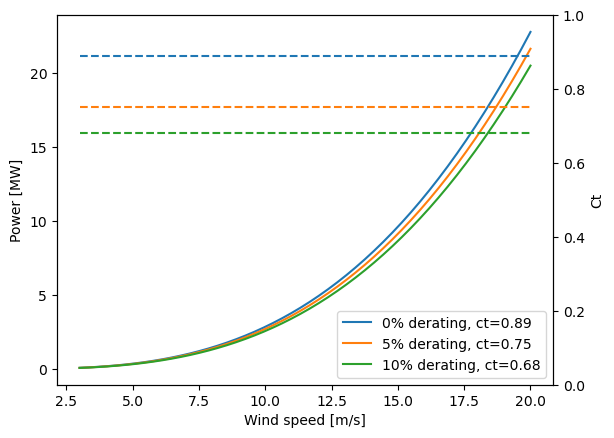

In [6]:
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ws = np.linspace(3, 20)
for derating in [0, .05, .1]:
    ct = wt.ct(ws, derating=derating)
    ax1.plot(ws, wt.power(ws, derating=derating) / 1e6, label='%d%% derating, ct=%.2f' % (derating * 100, ct[0]))
    ax2.plot(ws, ct,'--')

ax1.legend(loc='lower right')
ax1.set_xlabel('Wind speed [m/s]')
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('Ct')
ax2.set_ylim([0, 1])

#### Maximize mean power by optimizing de-rating factor and hub height

In this example we will maximize the mean power by optimizing the individual wind turbine hub height and derating factors.

First we setup the `WindFarmModel` and the function to maximize, `mean_power`, which takes the hub height and derating factors as input:

In [11]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.site import UniformSite
from py_wake.utils.gradients import autograd

from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver

n_wt = 5
wfm = IEA37SimpleBastankhahGaussian(site=UniformSite(p_wd=[1],ti=.1), windTurbines=wt)
wt_x = np.arange(n_wt) * 4 * wt.diameter()
wt_y = np.zeros_like(wt_x)

def mean_power(zhub, derating):
    power_ilk = wfm(x=wt_x, y=wt_y, h=zhub, wd=[270], ws=[10], derating=derating, return_simulationResult=False)[2] 
    return np.mean(power_ilk)

Setup the gradient function with respect to both arguments. 

Again the PyWake autograd method will, under the hood, calculate the gradients with respect to both inputs in one go.

In [12]:
dmean_power_dzhub_derating = autograd(mean_power,argnum=[0,1])

Initialize zhub and derating. The values are choosen to avoid zero gradients (e.g. if all wt has same hub height)

In [13]:
zhub = np.arange(n_wt)+100 # 100,101,102,...
derating=[0.1]*n_wt

In [14]:
print ('Mean power: %f MW'%(mean_power(zhub,derating)/1e6))
print ('Gradients:',dmean_power_dzhub_derating(zhub,derating))

Mean power: 1.429855 MW
Gradients: [array([-132.37798792,  -20.72030943,    9.44975613,   41.70595145,
        101.94258977]), array([   5539.55413631,  170225.9858809 ,  132322.76792935,
         39204.83341772, -234801.3362418 ])]


Next step is to setup the `CostModelComponent` and `TopFarmProblem`

In [15]:
cost_comp=CostModelComponent(input_keys=['zhub', 'derating'],
                              n_wt=n_wt,
                              cost_function=mean_power,
                              cost_gradient_function=dmean_power_dzhub_derating,
                              maximize=True # because we want to maximize the mean power
                             )

tf = TopFarmProblem(design_vars={
                        # (initial_values, lower limit, upper limit)
                        'zhub': ([100]*n_wt, 80, 130),
                        'derating': ([0] * n_wt, 0, .9)},  
                    n_wt=n_wt,
                    cost_comp=cost_comp,
                    expected_cost=1000, # expected cost impacts the size of the moves performed by the optimizer
                    )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


As seen above the gradient of the mean power wrt. hub height is zero when all wind turbines have the same height. This means that the optimizer "thinks" that the solution cannot be improved. We therefore need to initialize the optimization with slightly different hub heights.

Furthermore, the derating must be above zero to avoid inequality constraint failure.

In [16]:
#perform the optimization
cost, state, recorder = tf.optimize(state={'zhub':np.arange(n_wt)+100,   # 100,101,102,...
                                           'derating':[0.1]*n_wt         # 10% initial derating
                                          })
print ()
print ('Optimized mean power %f MW'% (cost/1e6))
print ('Optimized state', state)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1716.1873043790367
            Iterations: 38
            Function evaluations: 56
            Gradient evaluations: 36
Optimization Complete
-----------------------------------

Optimized mean power -1.716187 MW
Optimized state {'zhub': array([ 80., 130.,  80.,  80., 130.]), 'derating': array([0.08691683, 0.06260834, 0.19990203, 0.04530914, 0.        ])}


**Plotting the results**

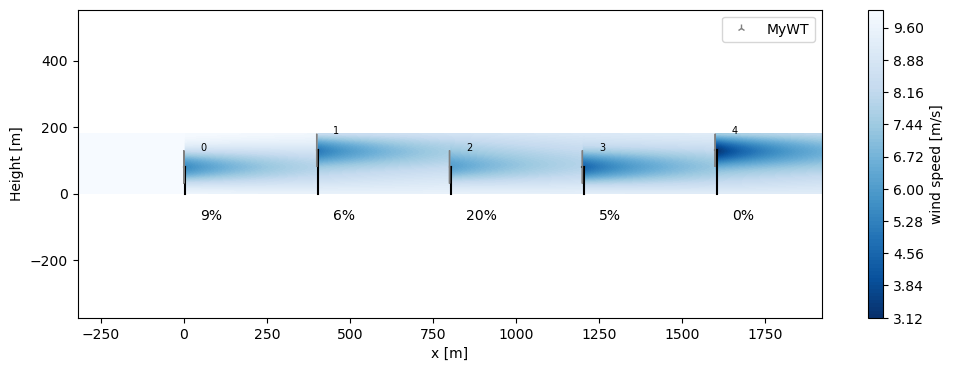

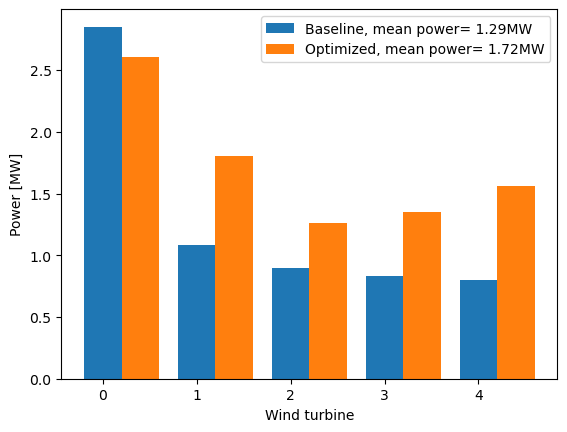

In [17]:
from py_wake import XZGrid
derating = state['derating']
h = state['zhub']

sim_res_ref = wfm(wt_x, wt_y, wd=[270], ws=[10], derating=[0] * n_wt)
sim_res_opt = wfm(wt_x, wt_y, h=h, wd=[270], ws=[10], derating=derating)
plt.figure(figsize=(12,4))
sim_res_opt.flow_map(XZGrid(y=0)).plot_wake_map()
for x_, d in zip(wt_x, derating):
    plt.text(x_ + 50, -80, "%d%%" % np.round(d * 100), fontsize=10)
plt.ylabel('Height [m]')
plt.xlabel('x [m]')

plt.figure()
for i, (sim_res, l) in enumerate([(sim_res_ref, 'Baseline'), (sim_res_opt, 'Optimized')]):
    plt.bar(np.arange(n_wt) + i * .4, sim_res.Power.squeeze() * 1e-6, width=.4,
            label='%s, mean power= %.2fMW' % (l, sim_res.Power.mean() * 1e-6))
plt.ylabel('Power [MW]')
plt.xlabel('Wind turbine')
plt.legend()
plt.show()

# Overview

PyWake is an open-source wind farm simulation tool used for studying the interaction between turbines within a wind farm and its influence on the farm’s flow field and power production. Based in Python, PyWake is capable of accurately computing the physics behind wind farms as well as obtaining their AEP. It provides a unified interface to wind farm models of different fidelities, e.g., different engineering models and CFD-RANS (commercial plugin). Given its heavy vectorization and use of numerical libraries, PyWake is a very fast tool that can handle many variables at once.

## The PyWake Philosophy

"Empowering users" underlines the formulation of PyWake. Its highly modular architecture (shown in the figure below) allows users to combine different AEP modelling blocks in all sorts of fashions - giving the flexibility to shape PyWake around the particularities of real-world problems more accurately. Yet with power also comes responsibility - the user needs to make an informed decision when combining the multitude of building blocks PyWake supplies. Essentially, everyone can build their *own* AEP model chain leveraging PyWake's flexibility, so there is not *one* PyWake solution either; users should thus ensure to report the particular PyWake building blocks they used to transparently communicate their results and methodology.

<center><img src="../_static/WF_Site_WindTurbines.svg"/></center>

The main object in PyWake’s architecture is the `WindFarmModel`, which is initialized with a `Site` and a `WindTurbines` object. It returns a `SimulationResult` object containing the calculated effective wind speed, power production, and thrust coefficient of individual turbines. In addition, it relies on methods to calculate the AEP and generate flow maps of entire wind farms.

- **Site**: for given turbine positions (x, y), reference wind speed (WS<sub>ref</sub>) and wind direction (WD<sub>ref</sub>), the Site object provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI), and the probability of each combination of wind direction and wind speed. Furthermore, the Site object is responsible for calculating the down-wind, cross-wind, and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).
- **WindTurbines**: for a given wind turbine type and effective wind speed (WS<sub>eff</sub>), the WindTurbines object provides the power curve, thrust coefficient (CT) curve, as well as the wind turbine’s hub height (h) and diameter (D). 


The **Tutorials** section provides examples on how to define both the WindTurbines and Site objects in PyWake.

## Engineering models

<center><img src="../_static/EngineeringModels.svg"/></center>

The engineering wind farm models (`EngineeringWindFarmModel`) in PyWake are composed of one or two wind farm models in combination with a wake deficit model, a superposition model, and optionally a blockage deficit and a turbulence model. The two main objects correspond to the `PropagateDownwind` and `All2AllIterative` objects. These two define the procedure that determines how wake and blockage deficits propagate in the wind farm. `PropagateDownwind` does not consider blockage effects whereas `All2AllIterative` does. The [Engineering Wind Farm Models](EngineeringWindFarmModels.ipynb) notebook depicts a much more detailed definition of these two.

Whereas a wake deficit model always needs to be selected, all other components are optional. Here is a quick overview of the different building blocks forming part of the engineering model setup:

- **Wake Deficit Model**: calculates the wake deficit from one turbine to downstream wind turbines or sites in the wind farm. A set of predefined wake models are available in PyWake, please refer to the [Wake Deficit Models](WakeDeficitModels.ipynb) notebook for more details.
    - `rotorAvgModel`: Option to select the way the wind speed is averaged on the turbine rotor.
    - `groundModel`: Option for modelling the ground effect.
    - `use_effective_ws`: Option for using the local wind speed at the rotor to compute the deficit.
    - `use_effective_ti`: Option for using the local turbulence intensity at the rotor to compute TI dependant quantities.
- **Blockage Deficit Model**: calculates the blockage deficit (speed-ups) from one wind turbine to upstream/downstream turbines or sites in the wind farm. Please refer to the [Blockage Deficit Models](BlockageDeficitModels.ipynb) notebook for more details.
- **Superposition Model**: defines how deficits from multiple sources add up. Please refer to the [Superposition Models](SuperpositionModels.ipynb) notebook for more details.
- **Rotor Average Model**: defines how the wind speeds are reaching the swept area of a turbine rotor and estimates the rotor-average wind speed. Please refer to the [Rotor Average Models](RotorAverageModels.ipynb) notebook for more details.
- **Deflection Model**: defines the wake deflection due to yaw misalignment, sheared inflow, etc. It does this by modifying the down- and cross- wind distances. Please refer to the [Deflection Models](DeflectionModels.ipynb) notebook for more details.
- **Turbulence Model**: calculates the added turbulence in the wake from one wind turbine to downstream wind turbines or sites in the wind farm. Please refer to the [Turbulence Models](TurbulenceModels.ipynb) notebook for more details.
- **Ground Models**: are used to model the effects that the ground has on the inflow and wake. Please refer to the [Ground Models](GroundModels.ipynb) notebook for more details.

This list should only serve as a rough overview of the different components constituting the `EngineeringWindFarmModel` and the available options - a more detailed description of each type of models can be found in the **Tutorials** section.

> **Disclaimer** 
>
> The specific implementation of the different models might differ from the respective published method, either due to practical reasons, to make it more versatile or to incorporate our own improvements.  

####  Available models in PyWake

| Wake Deficit Model | Blockage Deficit Model | Superposition Model | Turbulence Model | Rotor Average Model | Deflection Models
| :--- | :--- | :--- | :--- | :--- | :--- |
| [NOJ](WakeDeficitModels.ipynb#NOJDeficit) | [Fuga](BlockageDeficitModels.ipynb#FugaDeficit) | [Linear Sum](SuperpositionModels.ipynb#LinearSum) | [Steen Frandsen 2005](TurbulenceModels.ipynb#STF2005TurbulenceModel) | [Rotor Center](RotorAverageModels.ipynb#RotorCenter) | [Jimenez](DeflectionModels.ipynb#JimenezWakeDeflection)
| [Bastankhah Gaussian](WakeDeficitModels.ipynb#BastankhahGaussianDeficit) | [Self Similarity Deficit](BlockageDeficitModels.ipynb#SelfSimilarityDeficit) | [Squared Sum](SuperpositionModels.ipynb#SquaredSum) | [Steen Frandsen 2017](TurbulenceModels.ipynb#stf2017TurbulenceModel)  | [Grid Rotor Average](RotorAverageModels.ipynb#GridRotorAvg) | [Fuga](DeflectionModels.ipynb#FugaDeflection)
| [Zong Gaussian](WakeDeficitModels.ipynb#ZongGaussianDeficit) | [Vortex Cylinder](BlockageDeficitModels.ipynb#VortexCylinder) | [Max Sum](SuperpositionModels.ipynb#MaxSum) | [GCL](TurbulenceModels.ipynb#GCLTurbulence) | [Eq Grid Rotor Average](RotorAverageModels.ipynb#EqGridRotorAvg) | [GCL Hill](DeflectionModels.ipynb#GCLHillDeflection)
| [Niayifar Gaussian](WakeDeficitModels.ipynb#NiayifarGaussianDeficit) | [Vortex Dipole](BlockageDeficitModels.ipynb#VortexDipole) | [Sqr Max Sum](SuperpositionModels.ipynb#SqrMaxSum) | [Crespo Hernandez](TurbulenceModels.ipynb#CrespoHernandez) |  [GQ Grid Rotor Average](RotorAverageModels.ipynb#GQGridRotorAvg)
| [Turbo Gaussian](WakeDeficitModels.ipynb#TurboGaussianDeficit) | [Rankine Half Body](BlockageDeficitModels.ipynb#RankineHalfBody) | [Weighted Sum](SuperpositionModels.ipynb#WeightedSum) |  | [Polar Grid Rotor Average](RotorAverageModels.ipynb#PolarGridRotorAvg)
| [Turbo NOJ](WakeDeficitModels.ipynb#TurboNOJDeficit) | [Hybrid Induction](BlockageDeficitModels.ipynb#HybridInduction) | |  | [CGI Rotor Average](RotorAverageModels.ipynb#CGIRotorAvg)
| [Fuga](WakeDeficitModels.ipynb#FugaDeficit) | [Rathmann](BlockageDeficitModels.ipynb#Rathmann) |  |  |  |
| [Super Gaussian](WakeDeficitModels.ipynb#SuperGaussianDeficit) |  |  |  |
| [Carbajo Fuertes Gaussian](WakeDeficitModels.ipynb#CarbajofuertesGaussianDeficit) |  |  |  |
| [GCL](WakeDeficitModels.ipynb#GCLDeficit) | |  |  |

## EllipSys3D (RANS-CDF)

The EllipSys wind farm model is based on a Reynolds-Averaged Navier-Stokes method as implemented in the general purpose flow solver EllipSys3D, initially developed by Jess A. Michelsen at DTU Fluid Mechanics[1,2] and Niels N. Sørensen in connection with his PhD study[3].

EllipSys3D is a closed-source licensed software and it is based on Fortran and MPI. The EllipSys wind farm model uses PyEllipSys, which is a direct memory Python interface to the Fortran version of EllipSys3D. This means that it is possible to import EllipSys3D as a Python object and change flow variables during a simulation.

The wind turbines are represented by actuator discs (AD) and the inflow is an idealized atmospheric boundary layer including effects of Coriolis and atmospheric stability. The main setup uses flat terrain, with a homogeneous roughness length, but the EllipSys wind farm model can also be run with complex terrain. More information can be found here: https://topfarm.pages.windenergy.dtu.dk/cuttingedge/pywake/pywake_ellipsys/.


**Installation**

The EllipSys wind farm model only runs in a linux environment and it requires the
commercial cutting-edge plugin `py_wake_ellipsys`. Contact us if you are interested to get access to it.


**References**

1. Jess A. Michelsen, *Basis3D - a Platform for Development of Multiblock
   PDE Solvers*, AFM 92-05, Department of Fluid Mechanics, Technical University
   of Denmark, December 1994.
2. Jess A. Michelsen, Block structured Multigrid solution of 2D and 3D
   Elliptic PDEs, AFM 94-06, Department of Fluid Mechanics, Technical
   University of Denmark, May 1994.
3. Niels N. Sørensen, *General Purpose Flow Solver Applied to Flow Over Hills*,
   Risø-R-827, Risø National Laboratory, Roskilde, Denmark, 1995.


## General modelling considerations
*By Alexander Meyer Forsting (alrf@dtu.dk)*

The never ending stream of publications concerning wind farm flows nicely demonstrates the difficulty we are still facing in accurately modelling the aerodynamic phenomena within the field of wind energy. There is currently not a single accepted method that could possibly capture the extensive range of flow scales we are dealing with - from aerofoil boundary layers to farm-to-farm interactions - especially not one that is sufficiently cheap to allow AEP predictions. Engineering wind farm models present a reasonable balance between accuracy and costs for wind farm AEP simulations, yet they rely on multiple sub-models that need to be selected wisely according to the problem at hand. A certain model and parameter combination might work for one particular case but not another - as demonstrated in an endless number of published model comparisons/validations. PyWake's engineering wind farm models are therefore also completely modular, allowing to combine different single wake models with different superposition, blockage, turbulence and deflection models to simulate wind farm flows. Each respective model is also configurable and its parameters tunable.

The sheer amount of possible sub-model combinations and settings can be overwhelming, so here we would like to give a very general guidance on how to combine them and what choices to consider.

**1) Selection of the superposition model**

Here you mainly have to decide between `SquaredSum` or `LinearSum`. The former does not really have a clear physical foundation, but was found to give some promising results in deep-arrays, as it isolates the most severe deficits, much like `MaxSum`. Beware, though, that its successful application largely depends on how the deficits are calculated inside the farm. Depending on the control volume one considers, one could either use the wind farm free-stream wind speed (even for turbines inside the array) or the incoming wind speed at each turbine (if isolating individual turbines). When studying a single turbine, the deficits from upstream turbines (and blockage from upstream/downstream) is included. Whilst physically it is hard to argue for using the free-stream velocity inside the array, one could choose to do so, as many have done before; however, it is then imperative to avoid using `LinearSum`. Since PyWake uses the *effective wind speed* at each turbine to calculate the thrust, power and deficit, if the free-stream velocity is chosen as *effective wind speed* the deficits will be extremely large - even inside the array - and the flow speed can turn negative when summing them linearly. A more consistent approach (in line with using single wake models) is to use the turbine's incoming wind speed as *effective wind speed* by setting `use_effective_ws=True`. Then, the deficits are to be combined with the `LinearSum` model. Note that the `SquaredSum` actually leads to double counting (see [Park2 model description](https://backend.orbit.dtu.dk/ws/portalfiles/portal/151671395/Park2_Documentation_and_Validation.pdf) for details).

There is also the `WeightedSum` approach by Zong et al but it is only available for Gaussian wake deficit models so far, and tends towards the `LinearSum` results. It is an iterative method with high memory requirements and only differs from the `LinearSum` when combining extremely deep deficits. It should individually be judged whether its benefits outweigh the additional costs. A more lightweight alternative constitutes Bastankhah et al's `CumulativeWakeSum`, which was derived for the Gaussian wake models. Despite its theoretical foundation it ultimately still relies on empiricism and its accuracy is fully dependant on the optimal configuration of the underlying wake deficit model (same applies to the Zong superposition model performance). 

**2) Selection of the wake deficit model and its configuration**

Here the general recommendation is to use a Gaussian type model. They can conserve deficit momentum (in isolation) and avoid singular behavior (step changes). In addition, they are faster than the top-hat model. The available Gaussian model versions differ in their formulation of the streamwise wake expansion, which is governed by the initial wake diameter (at the wake origin) and its rate of expansion with downstream distance. The expansion can be constant (pre-set by user) or based on the *effective turbulence intensity (TI)*. Increasing TI leads to greater mixing and thus quicker expansion/deficit attenuation (users can change the coefficients if desired).

When using a **turbulence model**, the wake added turbulence in a farm is combined (the superposition of TI is another area of great uncertainty, but can also be modified by the user) and leads to spatially varying TI. As with the deficit, the user can choose to use the local TI at the rotor (`use_effective_ti=True`) or the free-stream TI. Whilst physically one might argue for using the local TI, this approach leads to excessive wake expansion deep inside the array when summing all contributions. Thus, the wake added turbulence is overestimated, making the free-stream TI a better reference for the wake expansion set up given the simplistic representation of turbulence by a single figure and its connection to wake expansion. The free-stream TI describes the atmospheric turbulence and thus also the larger scales contributing to wake-meandering and wake breakdown. On the other hand, the wake-added turbulence is small scale and dissipates quicker; therefore, it contributes differently to wake mixing and its superposition is not straight forward. For this reason, the Fuga and Dynamic Wake Meandering (DWM) models simulate only the free-stream TI governs wake expansion, as it is also the case in the more recent TurbOPark. One should also keep in mind that the Gaussian wake shape is a time-averaged solution, that incorporates meandering, shear-layer breakdown and mixing without differentiating between them.

Classically, Gaussian models are far-wake models, so the near-wake is rather crude. Shapiro et al introduced a smooth growth in the deficit, which also forms part of the Zong deficit model (not to be confused with the superposition model). The latter also sets the initial wake diameter by the near-wake length to capture the effect of TI and tip speed ratio on near-wake breakdown and subsequent far-wake onset. Other near-wake updates exist, yet their value is limited in AEP computations as turbines are usually placed outside this region in wind farms.

**3) Simulation of the ground effect**

In PyWake it is also possible to introduce a mirror plane to represent the **ground effect**, i.e turbines mirrored in the ground plane. This is a method commonly employed in vortex models, as it enforces zero wall normal velocity. However, while highly recommended for blockage modelling, it is less obvious whether to use a mirror plane for wakes. Wake models are generally tuned to measurement or simulation data that intrinsically contain the ground effect - so additional modelling could lead to double counting. This is also the reason why the `groundModel` can be set separately for blockage and wake models.

**4) Implementation of a wind turbine model**

PyWake uses power and CT curves, which can also be multi-dimensional (more suited to wind farm simulations), which need to be a function of the *free-stream* (reference) wind speed. In PyWake, a turbine's blockage and wake effects on itself, as well as its own mirror contributions (performance curves already include the ground effect), are zero. Thus, the wind speed at the rotor can be used to interpolate power and CT from the reference curves. The velocity at the rotor can be computed in different ways using the `rotorAvgModel` object. The default is extracting the velocity at the rotor-centre, however one can also opt for more rotor-equivalent wind speed quantities. Yet, one should consider that a turbine's performance curves are usually generated by using the rotor-centre velocity. The wind speed used for interpolation and deficit computation are always identical. As the power and CT curves are non-linear, users are advised to use higher-order splines in their interpolation (for instance `pchip`). A final issue relates to the often singular behaviour of power/thrust curves around cut-in and cut-out. Firstly, sudden jumps in production can occur around those wind-speeds as turbines are close to switch on/off, so even small changes in wind speed/direction can lead to strong relative changes. Secondly, in combination with blockage there is no definite solution, as some turbines might be on or off - either would be correct. This is mostly related to the downstream speed-up that blockage can cause in addition to upstream deficit. In the `All2AllIterative` model, on/off oscillations are avoided by tracking unstable turbines and switching them all off.

We hope the above recommendations will help you getting started with PyWake and enjoy exploring its flexibility in your own work. We are happy to receive any comments, suggestions and ideas for collaboration. 

**The PyWake Team**

# Quickstart

In this tutorial, the basic capabilities of PyWake are shown. Essentially, how to calculate a wind farm's AEP using the wind farm simulation tool and how to visualize and interpret the results. In addition, the use of flow maps is also shown.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

#### Import and set up of wind turbines, site, and flow model

There are many sites and wind turbines available in PyWake, some of them include:

- Hornsrev1 offshore wind farm
- Lillgrund offshore wind farm
- IEA Task 37 Site land-based wind farm
- Vestas V80 turbine
- IEA 3.4 MW turbine
- DTU 10MW reference turbine

For detailed information on the sites and wind turbine object features, please see the [Site](./Site.ipynb) and [Wind turbine](./WindTurbines.ipynb) examples.

In [1]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80, wt_x, wt_y, wt16_x, wt16_y
from py_wake import NOJ

#here we import the turbine, site and wake deficit model to use.
windTurbines = V80()
site = Hornsrev1Site()
noj = NOJ(site,windTurbines)

**Now we run the model using the initial positions of the wind farm**

For more information about the `SimulationResult` object and the paratemers included, please see the [wind farm simulation](./RunWindFarmSimulation.ipynb) example.

In [2]:
simulationResult = noj(wt16_x,wt16_y)

To calculate the AEP, we use the **simulationResult.aep()** command. This will show an xarray with the characteristics of the site, including the number of turbines and the wind speed and wind direction studied. In addition, it will show the AEP of each turbine for each flow case.

In [3]:
simulationResult.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 16, wd: 360, ws: 23)>
array([[[0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        ...,
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.99347385e-05, 1.42930180e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07]],

       [[0.00000000e+00, 3.22981375e-05, 1.07981910e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.51397497e-05, 1.13612781e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.82191783e-05, 1.19714904e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
...
        [0.00000000e+00, 3.71777590e-05, 9.99666402e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.71648787e-05, 9.98936103e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.74309185e-05, 1.00800249e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07]],

       [[0.00000000e+00, 3.71340563e-05, 1.05620267e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.88954661e-05, 1.12693592e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 4.08454658e-05, 1.19479314e-04, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        ...,
        [0.00000000e+00, 3.56657883e-05, 9.90388284e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.56485529e-05, 9.89644383e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07],
        [0.00000000e+00, 3.57746501e-05, 9.96806080e-05, ...,
         2.47780973e-06, 1.00529802e-06, 3.84203469e-07]]])
Coordinates:
  * wt       (wt) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
    x        (wt) float64 4.24e+05 4.24e+05 4.241e+05 ... 4.258e+05 4.259e+05
    y        (wt) float64 6.151e+06 6.151e+06 6.15e+06 ... 6.15e+06 6.15e+06
    h        (wt) float64 70.0 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0 70.0
    type     (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    Description:  Annual energy production [GWh]

To obtain the total AEP, we use the **.sum()** command.

In [4]:
print ("Total AEP: %f GWh"%simulationResult.aep().sum())

Total AEP: 143.151568 GWh


#### Plot AEP as function of wind turbines, wind direction and wind speed

There is also the possibility of plotting the individual AEP for each turbine for the flow cases studied. In addition, the AEP can be plotted against either the wind speed or wind direction.

Text(0.5, 1.0, 'AEP vs wind direction')

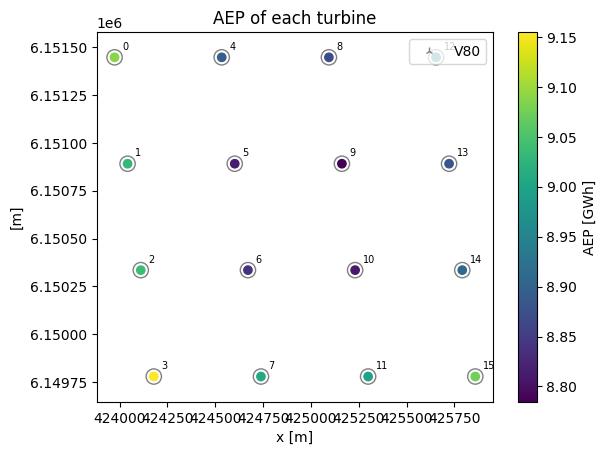

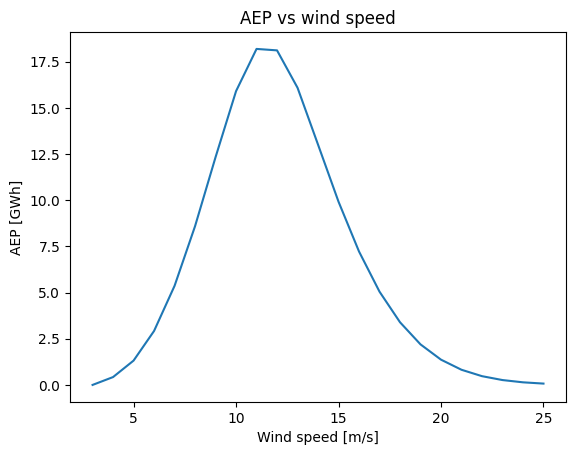

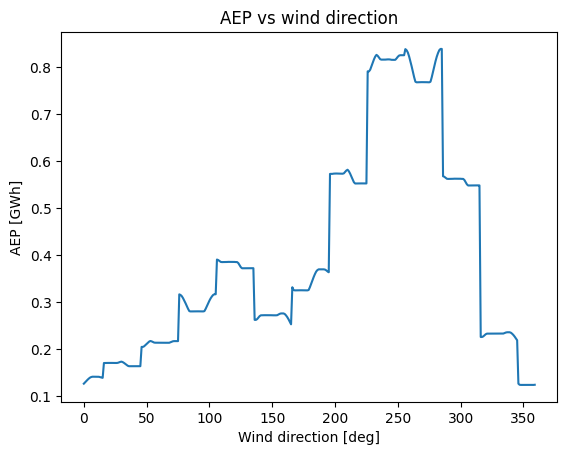

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
aep = simulationResult.aep() 
windTurbines.plot(wt16_x,wt16_y)
c =plt.scatter(wt16_x, wt16_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','wd']).plot()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind speed')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

#### Plot flow maps

It is also possible to plot the wind farm wake map. This shows the wake behavior for each turbine given the flow cases studied.

You can change the values of the wind speed and wind direction to visualize the wake maps for different flow cases.

Text(0.5, 1.0, 'Wake map for 10 m/s and 270 deg')

<Figure size 640x480 with 0 Axes>

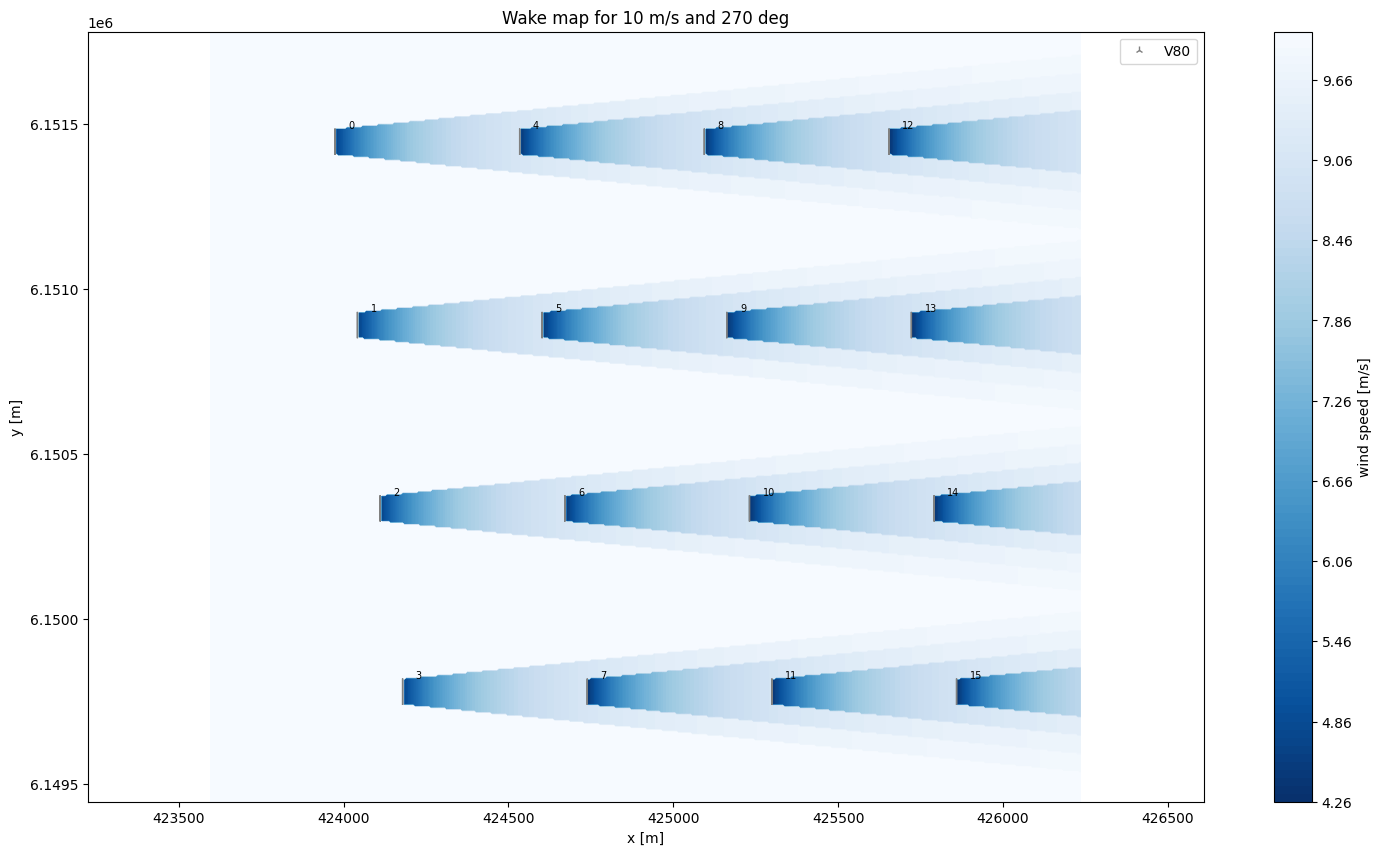

In [6]:
wind_speed = 10
wind_direction = 270

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

# Rotor Average Models

The rotor average model in PyWake defines one or more points at the turbine rotor to calculate a (weighted) rotor-average deficit. It includes:

- [RotorCenter](#RotorCenter): One point at the center of the rotor
- [GridRotorAvg](#GridRotorAvg): Custom grid in Cartesian coordinates'
- [EqGridRotorAvg](#EqGridRotorAvg): Equidistant N x N Cartesian grid covering the rotor
- [GQGridRotorAvg](#GQGridRotorAvg): M x N cartesian grid using Gaussian quadrature coordinates and weights
- [PolarGridRotorAvg](#PolarGridRotorAvg): Custom grid in polar coordinates  
- [CGIRotorAVG](#CGIRotorAvg): Circular Gauss Integration

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import and setup site and windTurbines
import py_wake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

In the plots below, it is clearly seen that the wind speed varies over the rotor, and that the the rotor-average wind speed is not well-defined by the wind sped at the rotor center.

Text(0, 0.5, 'Wind speed [m/s]')

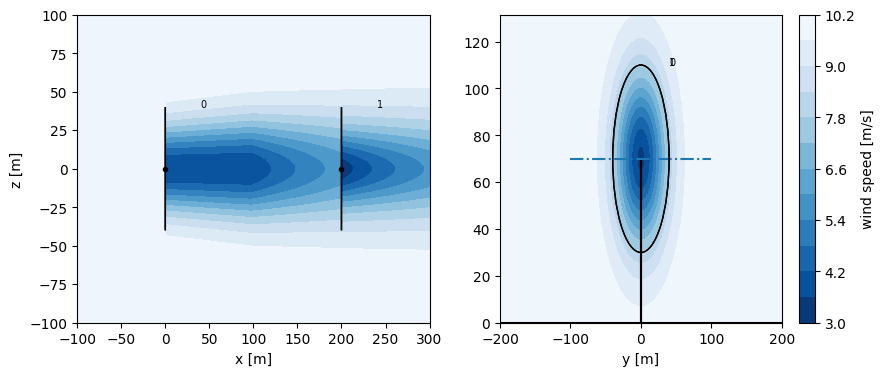

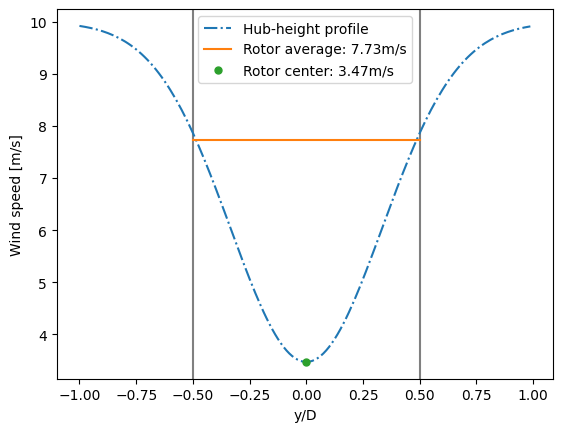

In [6]:
from py_wake.superposition_models import SquaredSum
from py_wake.flow_map import HorizontalGrid, YZGrid
from py_wake import BastankhahGaussian

D = 80
R = D/2
wfm = BastankhahGaussian(site, windTurbines, superpositionModel=SquaredSum())
sim_res = wfm([0,200],[0,0],wd=270,ws=10)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_xlabel("x [m]"), ax1.set_ylabel("y [m]")
sim_res.flow_map(HorizontalGrid(extend=.1)).plot_wake_map(10, ax=ax1, plot_colorbar=False)
sim_res.flow_map(YZGrid(x=199.99)).plot_wake_map(10, ax=ax2)
ax2.plot([-100,100],[70,70],'-.')
ax2.set_xlabel("y [m]"), ax1.set_ylabel("z [m]")

plt.figure()
flow_map = sim_res.flow_map(HorizontalGrid(x=[199.99], y=np.arange(-80, 80)))

for x in [-.5,.5]:
    plt.gca().axvline(x,color='grey')
plt.plot(flow_map.Y[:, 0]/D, flow_map.WS_eff_xylk[:, 0, 0, 0], '-.', label='Hub-height profile')
plt.plot([-.5,.5],[7.73,7.73],label='Rotor average: 7.73m/s')
rc_ws = flow_map.WS_eff_xylk[80, 0, 0, 0]
plt.plot(flow_map.Y[80, 0]/D, rc_ws,'.', ms=10, label='Rotor center: %.2fm/s'%rc_ws)
plt.legend()
plt.xlabel("y/D")
plt.ylabel('Wind speed [m/s]')

First we create a simple function to model all of the rotor-average models available in PyWake.

In [7]:
from py_wake.rotor_avg_models import RotorCenter, GridRotorAvg, EqGridRotorAvg, GQGridRotorAvg, CGIRotorAvg, PolarGridRotorAvg, PolarRotorAvg, polar_gauss_quadrature, GaussianOverlapAvgModel
from py_wake.flow_map import HorizontalGrid

R=D/2

def plot_rotor_avg_model(rotorAvgModel, name):
    plt.figure()
    m = rotorAvgModel
    wfm = BastankhahGaussian(site,windTurbines,rotorAvgModel=m)
    ws_eff = wfm([0, 200], [0, 0], wd=270, ws=10).WS_eff_ilk[1,0,0]
    plt.title(name)
    c = plt.scatter(m.nodes_x, m.nodes_y,c=m.nodes_weight,label="%.2fm/s"%(ws_eff))
    plt.colorbar(c,label='weight')
    plt.gca().add_artist(plt.Circle((0,0),1,fill=False))
    plt.axis('equal')
    plt.xlabel("y/R"); plt.ylabel('z/R')
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.legend()

### RotorCenter
Setting `rotorAvgModel=None` determines the rotor average wind speed from the rotor center point. Alternatively, you can use the `RotorCenter` model which is equivalent.

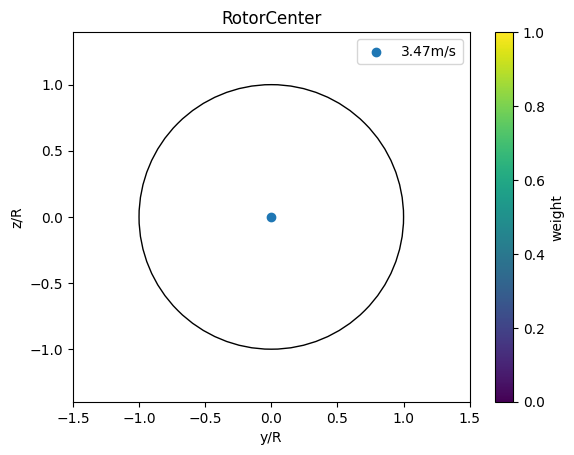

In [8]:
plot_rotor_avg_model(RotorCenter(), 'RotorCenter')

### GridRotorAvg

The `GridRotorAvg` defines a set of points in cartesian coordinates.

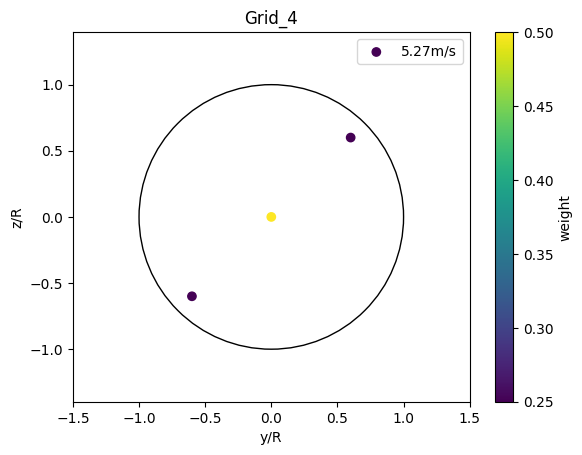

In [9]:
x = y = np.array([-.6, 0,.6])
plot_rotor_avg_model(GridRotorAvg(x,y,nodes_weight = [0.25,.5,.25]), 'Grid_4')

### EqGridRotorAvg

The `EqGridRotorAvg` defines a NxN equidistant cartesian grid of points and discards points outside the rotor.

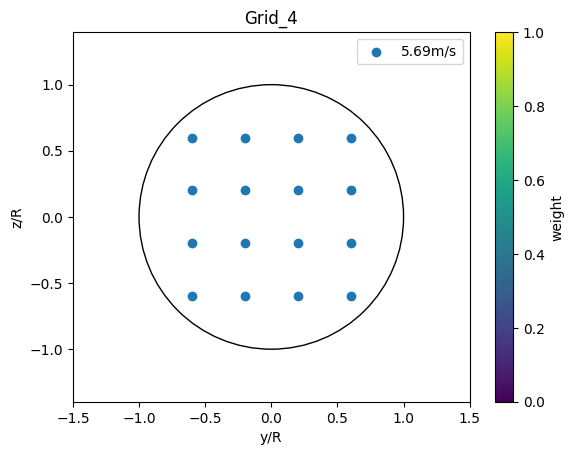

In [10]:
plot_rotor_avg_model(EqGridRotorAvg(4), 'Grid_4')

### GQGridRotorAvg

The `GQGridRotorAvg` defines a grid of M x N cartesian grid points using Gaussian quadrature coordinates and weights.

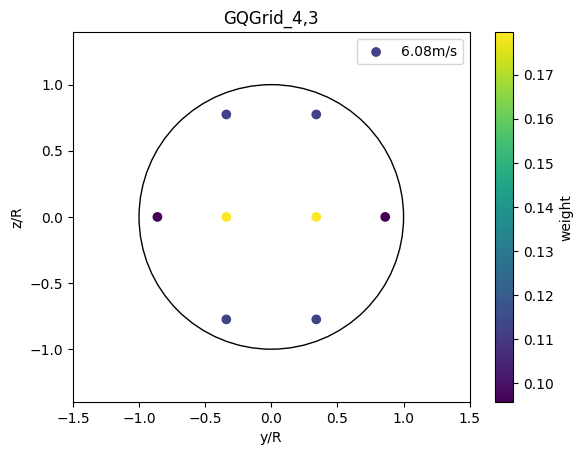

In [11]:
plot_rotor_avg_model(GQGridRotorAvg(4,3), 'GQGrid_4,3')

### PolarGridRotorAvg

The `PolarGridRotorAvg` defines a grid in polar coordinates.

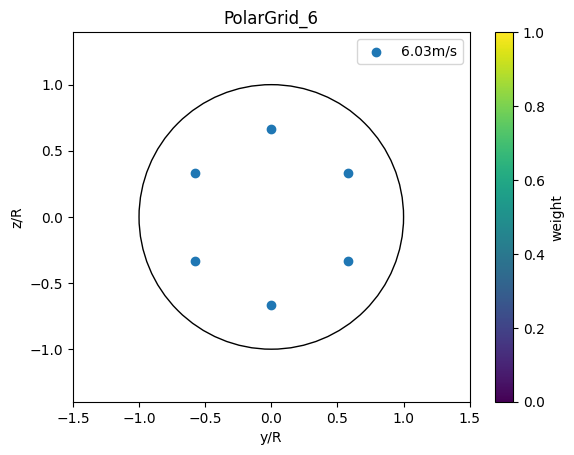

In [13]:
theta = np.linspace(-np.pi,np.pi,6, endpoint=False)
r = 2/3
plot_rotor_avg_model(PolarGridRotorAvg(r=r, theta=theta, r_weight=None, theta_weight=None), 'PolarGrid_6')

**The polar grid can be combined with Gaussian Quadrature.** 

This is similar to the implementation in FusedWake: https://gitlab.windenergy.dtu.dk/TOPFARM/FUSED-Wake/-/blob/master/fusedwake/gcl/fortran/GCL.f

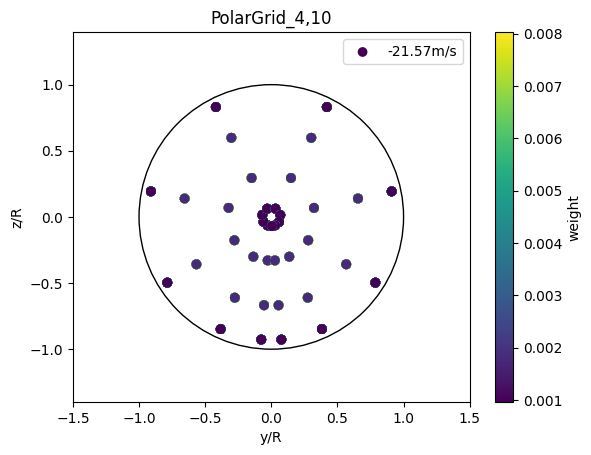

In [14]:
plot_rotor_avg_model(PolarGridRotorAvg(*polar_gauss_quadrature(4,10)), 'PolarGrid_4,10')

### CGIRotorAvg
Circular Gauss integration with 4,7,9 or 21 points as defined in Abramowitz M and Stegun A. Handbook of Mathematical Functions. Dover: New York, 1970.

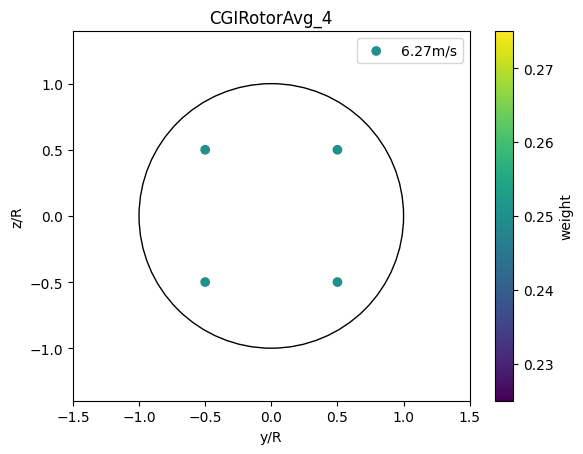

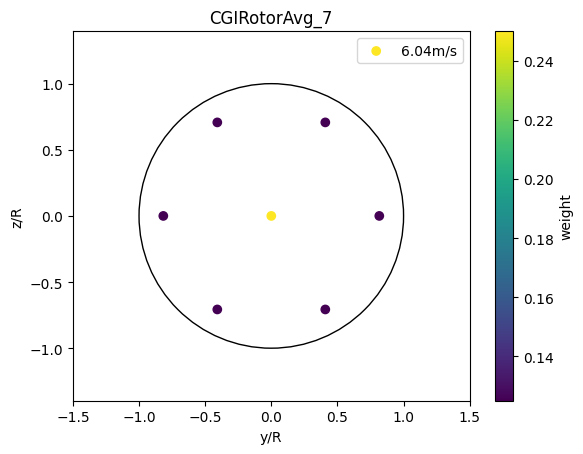

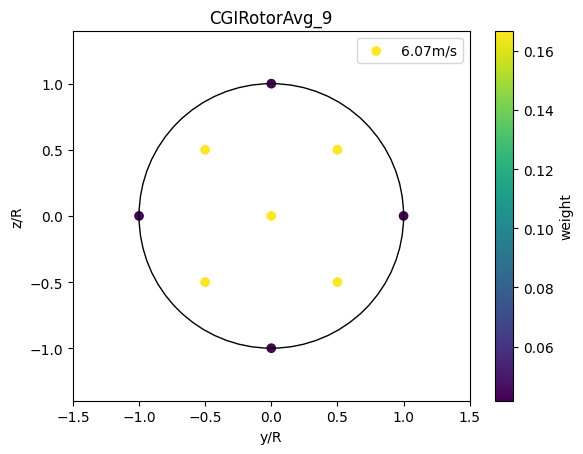

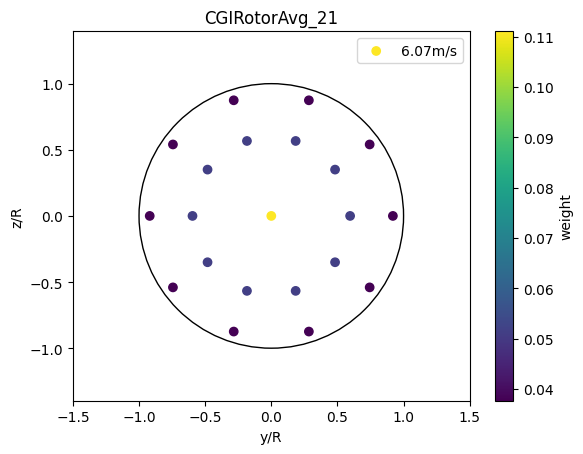

In [15]:
for n in [4,7,9,21]:
    plot_rotor_avg_model(CGIRotorAvg(n), 'CGIRotorAvg_%d'%n)

### AreaOverlapModel
The AreaOverlapModel calculates the fraction of the downstream rotor that is covered by the wake from an upstream wind turbine. This model makes sense for tophat wake deficit models only, e.g. NOJDeficit.


The calculation formula can be found in Eq. (A1) of  Feng, J., & Shen, W. Z. (2015). Solving the wind farm layout optimization problem using random search algorithm. Renewable Energy, 78, 182-192. https://doi.org/10.1016/j.renene.2015.01.005

<center><img src="images/AreaOverlap.svg" height="100"/></center>

### GaussianOverlapAvgModel

The GaussianOverlapModel computes the integral of the gaussian wake deficit over the downstream rotor. To speed up the computation, normalized integrals have been precalculated and stored in a look-up table. This model need the gaussian width parameter, $\sigma$, and therefore only applies to gaussian wake deficit models. 
See Appendix A in https://github.com/OrstedRD/TurbOPark/blob/main/TurbOPark%20description.pdf

<center><img src="images/GaussianOverlap.svg" height="100"/></center>

### Comparing rotor-average models
In general, the compuational cost and the accuracy of the estimate increases with the number of points, but the distribution of the points also has an impact.

The plot below shows the absolute error of the estimated rotor-average wind speed for the wind directions 
270 $\pm$ 30$^\circ$ (i.e. wind directions with more than 1% deficit) for a number of different rotor-average models.

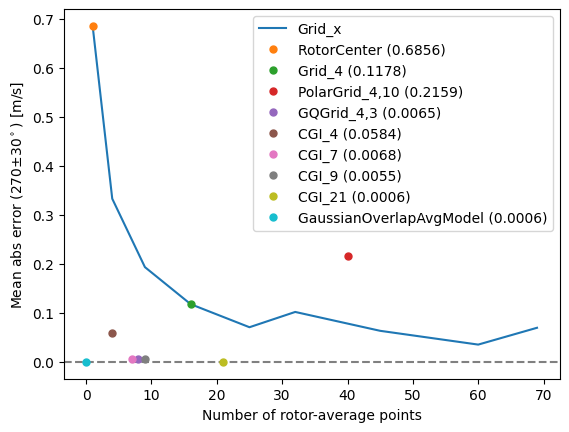

In [16]:
grid_models = [EqGridRotorAvg(i) for i in range(1,10)]
wd_lst = np.arange(240,301)

def get_ws_eff(rotorAvgModel):
    wfm = BastankhahGaussian(site,windTurbines,rotorAvgModel=rotorAvgModel)
    return wfm([0, 200], [0, 0], wd=wd_lst, ws=10).WS_eff_ilk[1,:,0]

ws_ref = get_ws_eff(EqGridRotorAvg(200)) # Use 200x200 points (31700 inside the rotor) to determine the reference value

def get_n_err(rotorAvgModel):
    ws_mean_err = np.abs(get_ws_eff(rotorAvgModel) - ws_ref).mean()
    return len(rotorAvgModel.nodes_x), ws_mean_err


plt.gca().axhline(0, color='grey',ls='--')
plt.plot(*zip(*[get_n_err(m) for m in grid_models]), label='Grid_x')
model_lst = [('RotorCenter', EqGridRotorAvg(1)),
             ('Grid_4', EqGridRotorAvg(4)),
             ('PolarGrid_4,10', PolarRotorAvg(*polar_gauss_quadrature(4,10))),
             ('GQGrid_4,3', GQGridRotorAvg(4, 3))] + \
            [('CGI_%d'%n, CGIRotorAvg(n)) for n in [4,7,9,21]]
for name, model in model_lst:
    n,err = get_n_err(model)
    plt.plot(n,err,'.',ms=10, label="%s (%.4f)"%(name,err))
goam_err = np.abs(get_ws_eff(GaussianOverlapAvgModel()) - ws_ref).mean()
plt.plot([0],[goam_err],'.', ms=10, label="GaussianOverlapAvgModel (%.4f)"%(goam_err))
plt.xlabel('Number of rotor-average points')
plt.ylabel(r'Mean abs error (270$\pm30^\circ$) [m/s]')
plt.legend()

# Wind Farm Simulation

In this example, a simple wind farm case is presented where the different capabilities of PyWake such as calculating AEP, extracting power values and plotting time series are shown.

**Install PyWake if needed**

In [ ]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

**First we import some basic Python elements**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

**Now we import the site, wind turbine and wake deficit model to use in the simulation**

In [2]:
# import and setup site and windTurbines
%load_ext py_wake.utils.notebook_extensions

from tqdm.notebook import tqdm
from py_wake.utils import layouts
from py_wake.utils.profiling import timeit, profileit
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.utils.plotting import setup_plot
xr.set_options(display_expand_data=False)

site = Hornsrev1Site()
x, y = site.initial_position.T
windTurbines = V80()

wf_model = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555)

#this allows you to see what type of engineering models you are simulating
print(wf_model)

BastankhahGaussian(PropagateDownwind, BastankhahGaussianDeficit-wake, SquaredSum-superposition)


## Simple simulation - all wind directions and wind speeds

To run the wind farm simulation, we must call the `WindFarmModel` (wf_model) element that was previously created. As default, the model will run for all wind directions and wind speeds defined. The default properties are:

- `site.default_wd`: 0-360$^\circ$ in bins of 1$^\circ$
- `site.default_ws`: 3-25 m/s in bins of 1 m/s

The default values for wind speeds and wind directions can be overwritten by either a scalar or an array.

In [3]:
sim_res = wf_model(x, y,     # wind turbine positions
                   h=None,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=None,  # Wind direction
                   ws=None,  # Wind speed
                  )

## Simulation Results

The `SimulationResult` object is a xarray dataset that provides information about the simulation result with some additional methods and attributes. 
It has the coordinates

- `wt`: Wind turbine number
- `wd`: Ambient reference wind direction
- `ws`: Ambient reference wind speed
- `x`,`y`,`h`: position and hub height of wind turbines

and data variables:

- `WD`: Local free-stream wind direction
- `WS`: Local free-stream wind speed
- `TI`: Local free-stream turbulence intensity
- `P`: Probability of flow case (wind direction and wind speed)
- `WS_eff`: Effetive local wind speed [m/s]
- `TI_eff`: Effective local turbulence intensity
- `power`: Effective power production [W]
- `ct`: Thrust coefficient
- `Yaw`: Yaw misalignment [deg]

where "effective" means "including wake effects"
 

In [4]:
#printing the simulation result from the wake model previously defined
sim_res

<xarray.SimulationResult>
Dimensions:           (wt: 80, wd: 360, ws: 23)
Coordinates:
  * wt                (wt) int32 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
  * wd                (wd) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * ws                (ws) int32 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
    x                 (wt) float64 4.24e+05 4.24e+05 ... 4.294e+05 4.295e+05
    y                 (wt) float64 6.151e+06 6.151e+06 ... 6.148e+06 6.148e+06
    h                 (wt) float64 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0
    type              (wt) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables: (12/16)
    WS_eff            (wt, wd, ws) float64 3.0 4.0 5.0 6.0 ... 22.87 23.88 24.89
    TI_eff            (wt, wd, ws) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 0.0 6.66e+04 1.54e+05 ... 2e+06 2e+06
    CT                (wt, wd, ws) float64 0.0 0.818 0.806 ... 0.06084 0.05377
    wd_bin_size       int32 1
    WS                (ws) int32 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
    ...                ...
    Weibull_A         (wd) float64 9.177 9.177 9.177 9.177 ... 9.177 9.177 9.177
    Weibull_k         (wd) float64 2.393 2.393 2.393 2.393 ... 2.393 2.393 2.393
    Sector_frequency  (wd) float64 0.001199 0.001199 ... 0.001199 0.001199
    P                 (wd, ws) float64 6.147e-05 8.559e-05 ... 2.193e-08
    tilt              int32 0
    yaw               int32 0

#### Selecting data

Data can be selected using the xarray `sel` method.

For example, the power production of wind turbine 3 when the wind is coming from the East (90deg) for all wind speeds bins:

In [5]:
sim_res.Power.sel(wt=3, wd=0)

<xarray.DataArray 'Power' (ws: 23)>
0.0 5.52e+04 1.309e+05 2.418e+05 3.947e+05 ... 2e+06 2e+06 2e+06 2e+06 2e+06
Coordinates:
    wt       int32 3
    wd       int32 0
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
    x        float64 4.242e+05
    y        float64 6.15e+06
    h        float64 70.0
    type     int32 0
Attributes:
    Description:  Power [W]

We can also get the total power of turbine 3 for the wind direction specified.

In [6]:
total_power = sim_res.Power.sel(wt=3, wd=0).sum().values/1e6
print('Total power: %f MW'%total_power)

Total power: 32.577250 MW


#### Plotting data

Data can be plotted using the xarray `plot` method.

For example, the power production of wind turbine 35 as a function of wind direction and wind speed.

Text(0.5, 0, 'x [m]')

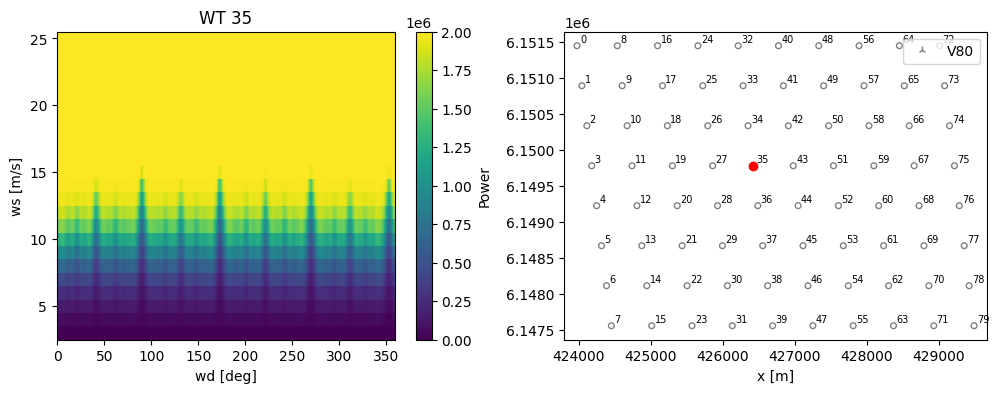

In [7]:
ax1, ax2 = plt.subplots(1,2, figsize=(12,4))[1]
sim_res.Power.sel(wt=35).T.plot(ax=ax1)
ax1.set_xlabel('wd [deg]')
ax1.set_ylabel('ws [m/s]')
ax1.set_title('WT 35')
windTurbines.plot(x,y, ax=ax2)
ax2.plot(x[35],y[35],'or')
ax2.set_xlabel('x [m]')

#### AEP calculation

Furthermore, `SimulationResult`, contains the method `aep` that calculates the Annual Energy Production. This can be done for all of the turbines as well as the total AEP of the wind farm, in GWh.

Here we can obtain the AEP of wind turbine 80 for all wind speed and wind directions:

In [8]:
sim_res.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 80, wd: 360, ws: 23)>
0.0 4.993e-05 0.0001429 0.0002968 ... 5.757e-06 2.478e-06 1.005e-06 3.842e-07
Coordinates:
  * wt       (wt) int32 0 1 2 3 4 5 6 7 8 9 10 ... 70 71 72 73 74 75 76 77 78 79
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
    x        (wt) float64 4.24e+05 4.24e+05 4.241e+05 ... 4.294e+05 4.295e+05
    y        (wt) float64 6.151e+06 6.151e+06 6.15e+06 ... 6.148e+06 6.148e+06
    h        (wt) float64 70.0 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0 70.0
    type     (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    Description:  Annual energy production [GWh]

**The total wind farm AEP is obtained using the** `sum` method.

In [9]:
print('Total power: %f GWh'%sim_res.aep().sum().values)

Total power: 682.040725 GWh


The `aep` method take an optional input, `with_wake_loss` (default is True), which can be used to e.g. calculate the wake loss of the wind farm.

In [10]:
aep_with_wake_loss = sim_res.aep().sum().data
aep_witout_wake_loss = sim_res.aep(with_wake_loss=False).sum().data
print('total wake loss:',((aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss))

total wake loss: 0.08332281558952935


## Time series

**Instead of simulating all wind speeds and wind directions, it is also possible to simulate time series of wind speed and wind directions.**

This allows simulation of time-dependent inflow conditions, e.g. combinations of wd, ws, shear, ti, density,etc. and turbine operation, e.g. periods where one or more wind turbines are stopped due to failure or maintenance.

Note, however, that PyWake considers the time series as discrete stationary conditions, i.e. a gust hits the whole wind farm at the same time.

In [11]:
# load a time series of wd, ws and ti
from py_wake.examples.data import example_data_path

d = np.load(example_data_path + "/time_series.npz")
n_days=30
wd, ws, ws_std = [d[k][:6*24*n_days] for k in ['wd', 'ws', 'ws_std']]
ti = np.minimum(ws_std/ws,.5)
time_stamp = np.arange(len(wd))/6/24

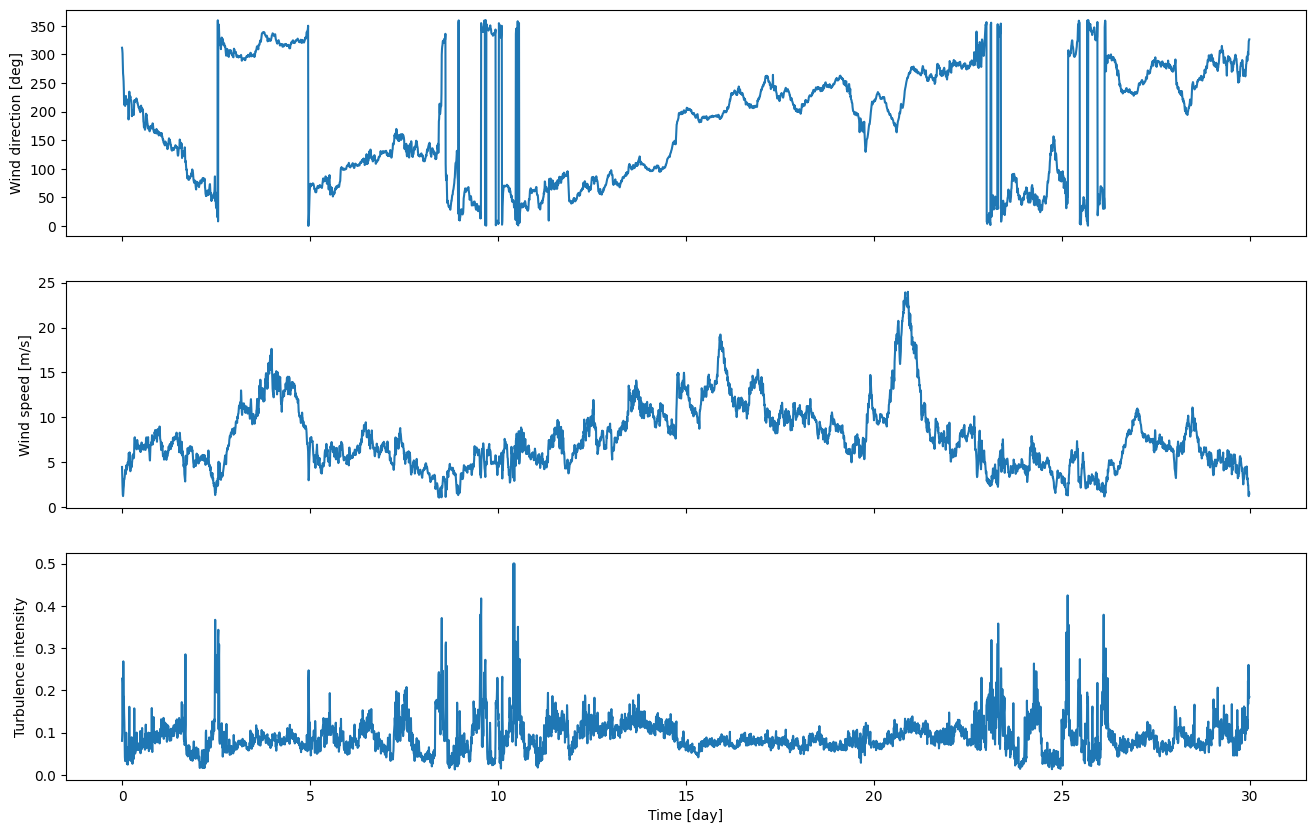

In [12]:
# plot time series
axes = plt.subplots(3,1, sharex=True, figsize=(16,10))[1]

for ax, (v,l) in zip(axes, [(wd, 'Wind direction [deg]'),(ws,'Wind speed [m/s]'),(ti,'Turbulence intensity')]):
    ax.plot(time_stamp, v)
    ax.set_ylabel(l)
_ = ax.set_xlabel('Time [day]')

**Time-dependent wind turbine operation**

Extend the wind turbine with a `operating` setting (0=stopped, 1=normal operation)

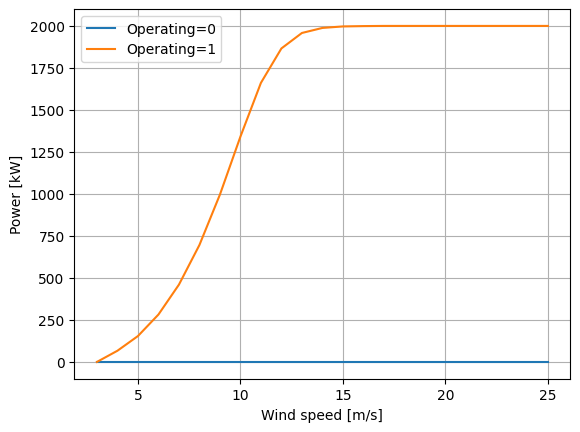

In [13]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList, PowerCtTabular

# replace powerCtFunction
windTurbines.powerCtFunction = PowerCtFunctionList(
    key='operating',
    powerCtFunction_lst=[PowerCtTabular(ws=[0, 100], power=[0, 0], power_unit='w', ct=[0, 0]), # 0=No power and ct
                         V80().powerCtFunction], # 1=Normal operation
    default_value=1)

# plot power curves
u = np.arange(3,26)
for op in [0,1]:
    plt.plot(u, windTurbines.power(u, operating=op)/1000, label=f'Operating={op}')
setup_plot(xlabel='Wind speed [m/s]', ylabel='Power [kW]')

**Make time-dependent operating variable**

In [14]:
operating = np.ones((len(x), len(time_stamp))) # shape=(#wt, #time stamps)
operating[0,(time_stamp>15)&(time_stamp<20)] = 0 # wt0 not operating from day 5 to 15

Call the wind farm model with the `time=time_stamp` and the time-dependent `operating` keyword argument.

In [15]:
# setup new WindFarmModel with site containing time-dependent TI and run simulation
wf_model = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555)

sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        TI=ti, # turbulence intensity time series
                        operating=operating # time dependent operating variable
                  )

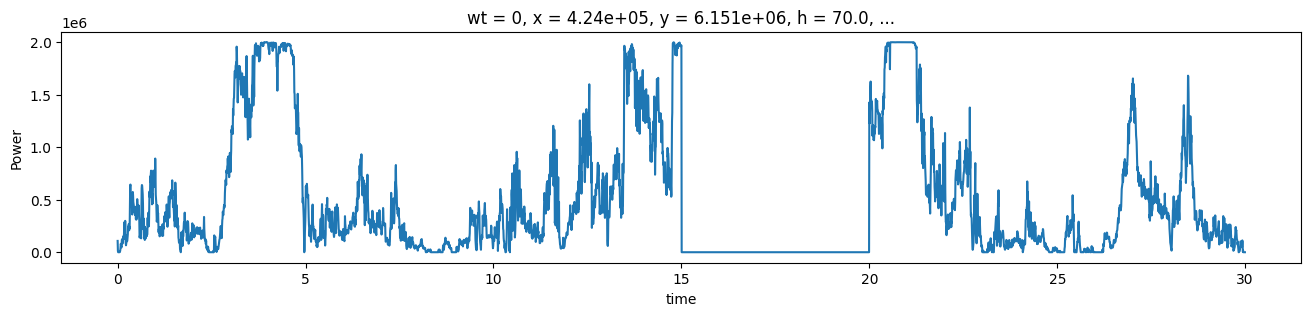

In [16]:
#here we plot the power time series of turbine 0
sim_res_time.Power.sel(wt=0).plot(figsize=(16,3))

In [17]:
sim_res_time.operating

<xarray.DataArray 'operating' (wt: 80, time: 4320)>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Coordinates:
  * wt       (wt) int32 0 1 2 3 4 5 6 7 8 9 10 ... 70 71 72 73 74 75 76 77 78 79
    wd       (time) float64 311.5 308.1 301.7 280.2 ... 310.6 323.3 324.4 326.1
    ws       (time) float64 4.47 3.181 2.215 1.391 ... 1.473 1.214 1.692 1.493
    x        (wt) float64 4.24e+05 4.24e+05 4.241e+05 ... 4.294e+05 4.295e+05
    y        (wt) float64 6.151e+06 6.151e+06 6.15e+06 ... 6.148e+06 6.148e+06
    h        (wt) float64 70.0 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0 70.0
    type     (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
  * time     (time) float64 0.0 0.006944 0.01389 0.02083 ... 29.98 29.99 29.99

In the no-operating periode time=5..15, the power is 0 as it should be

## Chunkification and Parallelization

PyWake makes it easy to split the wind farm simulation computation into smaller subproblems. This allows:

- Simulation of large wind farms or time series with less memory usage
- Parallel execution for faster simulation

**1) Chunkfication**

To split the simulation into smaller sub-tasks, just specify the desired number of `wd_chunks` and `ws_chunks`.

In [18]:
# split problem into 4x2 subtasks and simulate sequentially on one CPU
sim_res = wf_model(x, y,
                   wd_chunks=4,
                   ws_chunks=2)

Time series of (wd,ws)-flow cases is split into chunks, by specifying either `ws_chunks` or `wd_chunks`

In [19]:
sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        wd_chunks=4,
                  )

**Wind speed or wind direction chunks**

In [20]:
%%skip
n_lst = [1,2,4,8,16,23,32]
res = {'ws_chunks': np.array([(n,) + profileit(wf_model)(x, y, wd_chunks=1, ws_chunks=n)[1:] for n in tqdm(n_lst)]),
       'wd_chunks': np.array([(n,) + profileit(wf_model)(x, y, wd_chunks=n, ws_chunks=1)[1:] for n in tqdm(n_lst)])}

ax1,ax2 = plt.subplots(1,2,figsize=(12,4))[1]

for k, d in res.items():
    n,t,m = d.T
    ax1.plot(n,t, label=k)
    ax2.plot(n,m, label=k)
setup_plot(ax=ax1, ylabel='Time [s]', xlabel='Number of chunks')
setup_plot(ax=ax2, ylabel='Memory usage [MB]', xlabel='chunks')
plt.savefig('RunWindFarmSimuation_wdws_chunks.svg')

Cell skipped. Precomputed result shown below. Remove '%%skip' to force run. 


Result computed on the Sophia HPC cluster. Note that the number of wind speed chunks is limited to the number of wind speeds, in this case 23.


It is clearly seen that chunkification of wind directions are more efficient than chunkification of wind speeds with respect to both time and memory usage.

It is also seen that chunkification reduces the memory usage at the cost of computation time. With 32 wind direction chunks, the computational time is more than doubled, i.e. the speedup from running in parallel on a system with 32 CPUs is expected to be less than 16 times.

**2) Parallelization**

Running a wind farm simulation in parallel is just as easy - simply specify the number of CPUs to use to the input argument `n_cpu` or `None` to use all available CPUs.

As seen above, wind directions chunks are more efficient. Hence, the problem is as default split into `n_cpu` wind direction chunks, where `n_cpu` is the numbers of CPUs to use. 

As default, `n_cpu=1` (sequential execution), so to run in parallel, you need to specify a number of CPUs, e.g. `n_cpu=4`. Alternatively, `n_cpu=None` will use all available CPUs.

In [21]:
sim_res = wf_model(x, y,
                   n_cpu=None # run wind directions in parallel on all available CPUs
                  )

**CPU utilization**

The plot below shows the time used to calculate the AEP on 1-32 CPUs as a function of number of wind turbines.

In [22]:
%%skip
from py_wake.utils import layouts
from py_wake.utils.profiling import timeit
from tqdm.notebook import tqdm

n_lst = np.arange(100,600,100)

def run(n, n_cpu):
    x,y = layouts.rectangle(n,20,5*windTurbines.diameter())
    return (n, n_cpu, np.mean(timeit(wf_model, min_runs=5)(x,y,n_cpu=n_cpu)[1]))

res = {f'{n_cpu} CPUs': np.array([run(n, n_cpu=n_cpu) for n in tqdm(n_lst)]) for n_cpu in [1, 4, 16, 32]}

ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
for k,v in res.items():
    n,n_cpu,t = v.T
    ax1.plot(n, t, label=k)
    ax2.plot(n, res['1 CPUs'][:,2]/n_cpu/t*100, label=k)
setup_plot(ax=ax1,xlabel='No. wind turbines',ylabel='Time [s]')
setup_plot(ax=ax2,xlabel='No. wind turbines',ylabel='CPU utilization [%]')
plt.savefig('images/RunWindFarmSimulation_time_cpuwt.svg')

Cell skipped. Precomputed result shown below. Remove '%%skip' to force run. 


Result precomputed on the Sophia HPC cluster on a node with 32 CPUs.



The plot clearly shows that the time reduces with more CPUs. In this case, however, the gain from 16 to 32 CPUs is very limited. Note, this may highly dependend on the system architecture.

## Flow map

Finally, `SimulationResult` has a `flow_map` method which returns a `FlowMap` object. This allows the user to visualize the wake behind each turbine's rotor in the wind farm and represents the velocity deficit that occurs due to wake interactions in the wind farm.

In [23]:
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014

site = IEA37Site(16)
x, y = site.initial_position.T
windTurbines = IEA37_WindTurbines()

wf_model = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555)
sim_res = wf_model(x,y)

In [24]:
#change the wind speed and wind direction to visualize different flow cases
wsp = 9.8
wdir = 270
flow_map = sim_res.flow_map(grid=None, # defaults to HorizontalGrid(resolution=500, extend=0.2), see below
                            wd=wdir,
                            ws=wsp)

**To plot the wake map we call the plot_wake_map property**.

You can change the values of the wind speed and wind direction to see how different flow maps look like.

Text(0.5, 1.0, 'Wake map for 270 deg and 9.8 m/s')

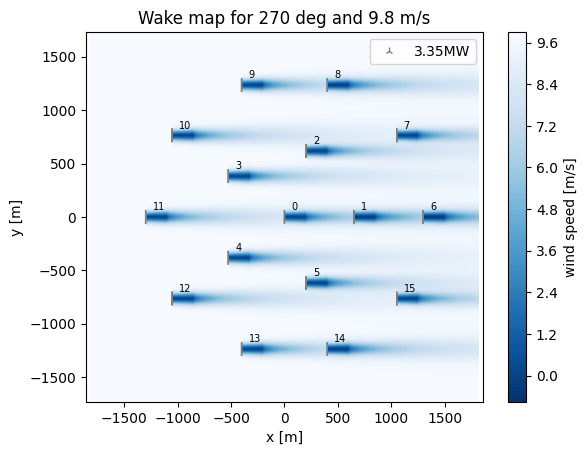

In [25]:
plt.figure()
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {wdir} deg and {wsp} m/s')

**The wake map can also be customized in terms of size and contour levels.**

Text(0, 0.5, 'y [m]')

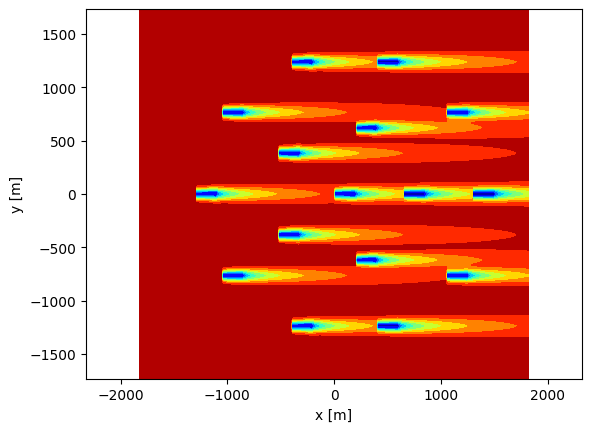

In [26]:
flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
                       cmap='jet', # color map
                       plot_colorbar=False,
                       plot_windturbines=False,
                       ax=None)
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

**There is also a Grid argument that can be set up to further customize the way the flow map is shown in different planes**

The grid argument should be either 

- a `HorizontalGrid`(same as `XYGrid`), `YZGrid` or 
- a tuple(X, Y, x, y, h) where X, Y is the meshgrid for visualizing the data and x, y, h are the flattened grid points

#### HorizontalGrid (XYGrid)

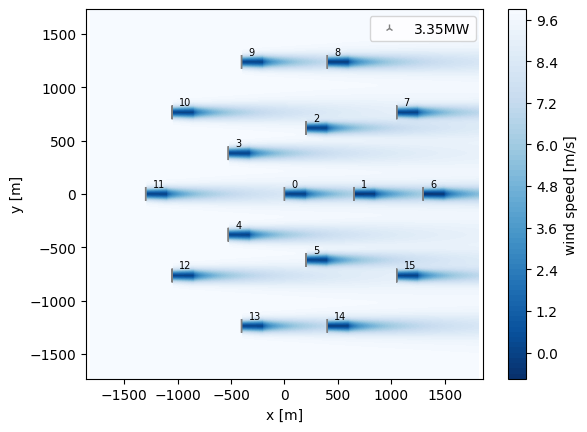

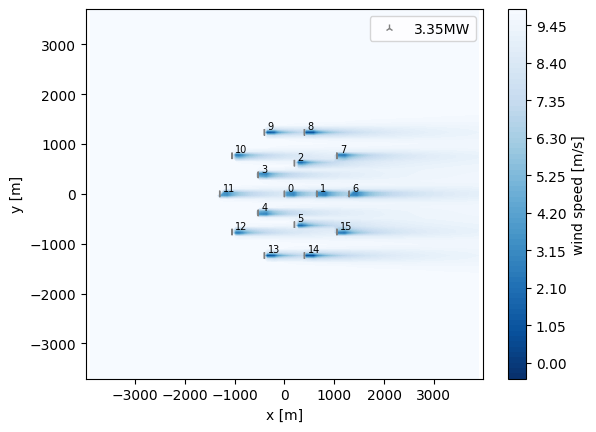

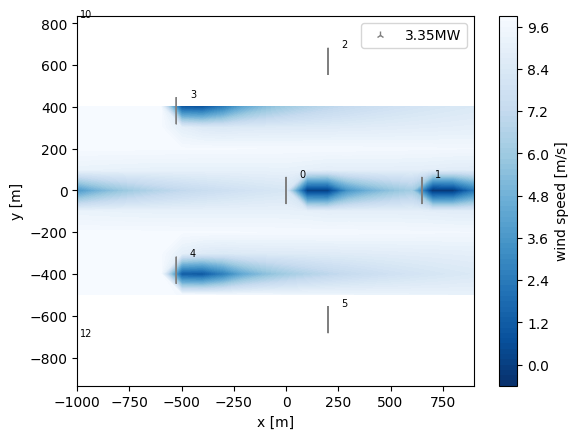

In [27]:
from py_wake import HorizontalGrid

for grid in [None,                                                     # defaults to HorizontalGrid(resolution=500, extend=0.2)
             HorizontalGrid(x=None, y=None, resolution=100, extend=1), # custom resolution and extend
             HorizontalGrid(x = np.arange(-1000,1000,100),
                            y = np.arange(-500,500,100))               # custom x and y
            ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=[9.8]).plot_wake_map()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')

#### YZGrid

Plotting the flow map in the vertical YZ plane through the red dashed line can be done using the `YZGrid`

![image3.png](images/RunWindFarmSimulation_yzgrid.png)


Text(0, 0.5, 'y [m]')

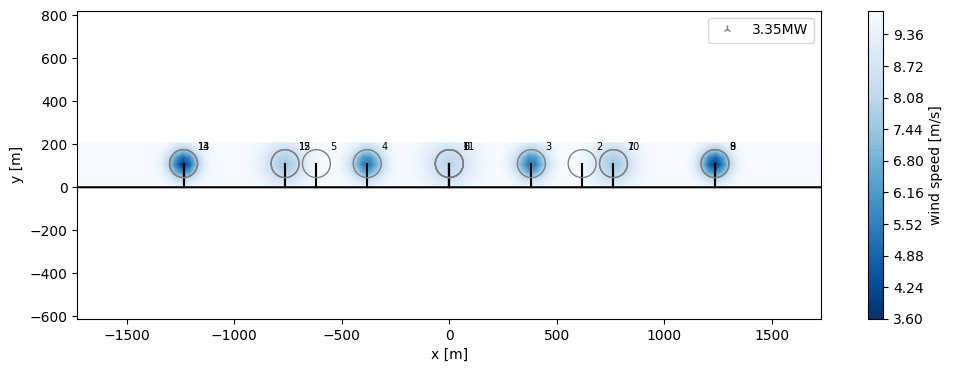

In [28]:
from py_wake import YZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(YZGrid(x=-100, y=None, resolution=100), wd=270, ws=None).plot_wake_map()
plt.xlabel('y [m]')
plt.ylabel('z [m]')

**3) XZGrid**

Plotting the flow map in the vertical XZ plane through the red dashed line can be done using the `XZGrid`

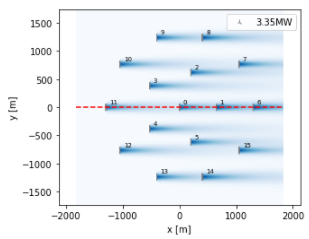


Text(0, 0.5, 'y [m]')

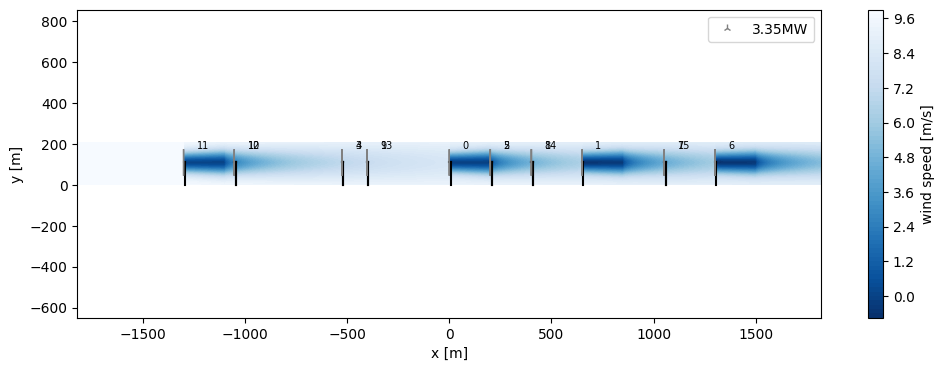

In [29]:
from py_wake import XZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(grid=XZGrid(y=0, resolution=1000), wd=270, ws=None).plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('z [m]')

# Site Object

For a given position, reference wind speed (WS<sub>ref</sub>) and wind direction (WD<sub>ref</sub>), `Site` provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI) and the probability of each combination of wind direction and wind speed. Furthermore, `Site` is responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).

**Intall PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

**Predefined example sites**

PyWake contains a few predefined sites of different complexities:

- **IEA37Site**: `UniformSite` (fix wind speed (9.8m/s), predefined wind sector probability).
- **Hornsrev1**: `UniformWeibullSite` (Weibull distributed wind speed, predefined wind sector propability, uniform wind a over flat wind area).
- **ParqueFicticioSite**: `WaspGridSite` (position-dependent Weibull distributed wind speed and sector probability. Terrain following distances over non-flat terrain). Loaded from a set of *.grd files exported from WAsP.

**First we import all sites and Python elements for later use**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite

sites = {"IEA37": IEA37Site(n_wt=16), 
         "Hornsrev1": Hornsrev1Site(), 
         "ParqueFicticio": ParqueFicticioSite()}

**PyWake also allows for user-defined sites**

You can define your own site using one of the `Site` classes:

- [UniformWeibullSite](#UniformWeibullSite): Site with uniform sector-dependent Weibull distributed wind speed.
- [WaspGridSite](#WaspGridSite): Site with gridded non-uniform inflow based on *.grd files exported from WAsP.
- [XRSite](#XRSite): The flexible general base class behind all Sites.

For more information on these classes, please see the [API reference on the Site object](https://topfarm.pages.windenergy.dtu.dk/PyWake/api/Site.html).

#### UniformWeibullSite

In [4]:
from py_wake.site import UniformWeibullSite

#specifying the necessary parameters for the UniformWeibullSite object
site = UniformWeibullSite(p_wd = [.20,.25,.35,.25],                         # sector frequencies
                          a = [9.176929,  9.782334,  9.531809,  9.909545],  # Weibull scale parameter
                          k = [2.392578, 2.447266, 2.412109, 2.591797],     # Weibull shape parameter
                          ti = 0.1                                          # turbulence intensity, optional
                         )

#### WaspGridSite

In [5]:
from py_wake.site import WaspGridSite
from py_wake.examples.data.ParqueFicticio import ParqueFicticio_path

site = WaspGridSite.from_wasp_grd(ParqueFicticio_path)

#### XRSite

The `XRSite` is the most general and flexible `Site`. For the input dataset there are some required and optional data variables, such as:

- Required data variables:
    - `P`: probability of flow case(s)

    or

    - `Weibull_A`: Weibull scale parameter(s)
    - `Weibull_k`: Weibull shape parameter(s)
    - `Sector_frequency`: Probability of each wind direction sector
    

- Optional data variables:

    - `WS`: Wind speed, if not present, the reference wind speed `ws` is used
    - `Speedup`: Factor multiplied to the wind speed
    - `Turning`: Wind direction turning
    - `TI`: Turbulence intensity
    - xxx: Custom variables needed by the wind turbines to compute power, ct or loads
    

- Each data variable may be constant or depend on a combination of the following inputs (Note, the input variables must be ordered according to the list, i.e. `P(wd,ws)` is ok, while `P(ws,wd)` is not):

    - `i`: Wind turbine position (one position per wind turbine)
    - `x`,`y`: Gridded 2d position
    - `x`,`y`,`h`: Gridded 3d position
    - `time`: Time
    - `wd`: Refernce wind direction
    - `ws` : Reference wind speed

In [6]:
from py_wake.site import XRSite
from py_wake.site.shear import PowerShear
import xarray as xr
import numpy as np
from py_wake.utils import weibull
from numpy import newaxis as na

f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

# Site with constant wind speed, sector frequency, constant turbulence intensity and power shear
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 10, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=100, alpha=.2))

# Site with wind direction dependent weibull distributed wind speed
uniform_weibull_site = XRSite(
    ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
                  coords={'wd': wd}))

# Site with a speedup and a turning value per WT
x_i, y_i = np.arange(5) * 100, np.zeros(5)  # WT positions

complex_fixed_pos_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': ('i', np.arange(.8, 1.3, .1)),
                   'Turning': ('i', np.arange(-2, 3)),
                   'P': ('wd', f)},
        coords={'i': np.arange(5), 'wd': wd}),
    initial_position=np.array([x_i, y_i]).T)

# Site with gridded speedup information
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.4, .1).reshape((3, 2))),
                   'P': ('wd', f)},
        coords={'x': [0, 500, 1000], 'y': [0, 500], 'wd': wd}))

# Site with ws dependent speedup and wd- and ws distributed probability
P_ws = weibull.cdf(np.array([3, 5, 7, 9, 11, 13]), 10, 2) - weibull.cdf(np.array([0, 3, 5, 7, 9, 11]), 10, 2)
P_wd_ws = P_ws[na, :] * np.array(f)[:, na]

complex_ws_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['ws'], np.arange(.8, 1.4, .1)),
                   'P': (('wd', 'ws'), P_wd_ws), 'TI': ti},
        coords={'ws': [1.5, 4, 6, 8, 10, 12], 'wd': wd}))

### Gridded non-uniform wind resources as time series with XRSite

This example creates a site with 2D non-uniform time series resources for wind speed (ws), wind direction (wd), and turbulence intensity (ti). The data is provided as arrays with dimensions corresponding to spatial coordinates (x, y) and time.

In [ ]:
site_x, site_y = np.meshgrid(np.arange(0.1, 1000, 100), np.arange(0.1, 2000, 100))
site_x, site_y = site_x.flatten(), site_y.flatten()
site_time = np.arange(100)
site_ws = np.random.uniform(3.0, 21.0, (len(site_x), len(site_y), len(site_time)))
site_wd = np.random.uniform(0.0, 360.0, (len(site_x), len(site_y), len(site_time)))
ds = xr.Dataset(
    data_vars=dict(
        WS=(["x", "y", "time"], site_ws),
        WD=(["x", "y", "time"], site_wd),
        TI=(["x", "y", "time"], np.ones_like(site_ws) * 0.1),  # hardcoded TI=0.1
        P=1,  # deterministic wind resource
    ),
    coords=dict(
        x=("x", site_x),
        y=("y", site_y),
        time=("time", site_time),
    ),
)
non_uniform_ts_site = XRSite(ds)
wss_at_mean_loc = non_uniform_ts_site.local_wind(
    site_x.mean(), site_y.mean(), time=site_time
)["WS_ilk"]
print(f"Mean wind speed at the mean location: {wss_at_mean_loc.mean():.2f} m/s")

# check the map of the mean wind speed at the site
mean_resource = ds.WS.mean(dim="time").values
plt.contourf(site_x, site_y, mean_resource)
plt.colorbar()
plt.title("Mean wind speed [m/s]")
plt.xlabel("x [m]")
_ = plt.ylabel("y [m]")

### Wake effects from neighbouring wind farms

In some cases, calculation of wake interaction between the wind farm to optimize and neighbouring wind farms considerably slow down an optimization work flow. To avoid this, a site, which includes wake effects from neighbouring wind farms, can be pre-generated and used for the optimization.

The speed up of this solution depends on the number of turbines in both the current and neighbouring wind farms, as well as the type of sites. If the original site is a uniform site, then a pre-generated site with wake effects from neighbouring wind farms may slow down the workflow as it adds interpolation of inflow characteristics in space.

Note also, that a pre-generated site with wake effects from neighbouring wind farms is only eqivalent to the full simulation  if the applied deficit model uses the effective wind speed (some models have an option to switch between effective and free-stream local wind speed). 

In [ ]:
# import and setup site and windTurbines
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.superposition_models import LinearSum

site = IEA37Site(16)

# setup current, neighbour and all positions
wt_x, wt_y = site.initial_position.T
neighbour_x, neighbour_y = wt_x-4000, wt_y
all_x, all_y = np.r_[wt_x,neighbour_x], np.r_[wt_y,neighbour_y]

windTurbines = WindTurbines.from_WindTurbine_lst([IEA37_WindTurbines(),IEA37_WindTurbines()])
windTurbines._names = ["Current wind farm","Neighbour wind farm"]
types = [0]*len(wt_x) + [1]*len(neighbour_x)

wf_model = PropagateDownwind(site, windTurbines,
                             wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                             superpositionModel=LinearSum())

# Consider wd=270 +/- 30 deg only
wd_lst = np.arange(240,301)


In [ ]:
#plotting the wake maps for the desired flow case
wsp = 9.8
wdir = 267

plt.figure(figsize=(16, 6))
wf_model(all_x, all_y, type=types, wd=wdir, ws=wsp, h=110).flow_map().plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {wdir} deg and {wsp} m/s')

**Now, we run the simulation of all wind turbines and calculate AEP of current wind farm**

In [ ]:
print("Total AEP: %f GWh"%wf_model(all_x, all_y, type=types, ws=[wsp], wd=wd_lst).aep().isel(wt=np.arange(len(wt_x))).sum())

**We can also calculate the AEP of the current wind farm by enclosing it in a flow box and setting up a new wind farm model**

In [ ]:
#making a flow box covering the area of interest (i.e the current wind farm + 100m)

ext = 1000
flow_box = wf_model(neighbour_x, neighbour_y, wd=wd_lst).flow_box(
    x=np.linspace(min(wt_x) - ext, max(wt_x) + ext, 101),
    y=np.linspace(min(wt_y) - ext, max(wt_y) + ext, 101),
    h=110)

#creating new site based on the flow box

from py_wake.site.xrsite import XRSite
wake_site = XRSite.from_flow_box(flow_box)

Now, we plot the "free-stream" inflow wind speed of the current wind farm.

In [ ]:
plt.figure(figsize=(16, 6))
wake_site.ds.WS.sel(wd=267).plot(y='y', cmap = 'Blues_r')
windTurbines.plot(all_x, all_y, types, wd=270)

Then, we setup a new wind farm model with the new pre-generated site and calculate the AEP.

In [ ]:
wf_model_wake_site = PropagateDownwind(wake_site, windTurbines,
                                       wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                                       superpositionModel=LinearSum())

In [ ]:
print("Total AEP: %f GWh"%wf_model_wake_site(wt_x, wt_y, ws=[wsp], wd=wd_lst).aep().sum())

Note that the AEP is not exactly equal due to interpolation errors. The discrepancy can be lowered by increasing the resolution of the flow box.

**Lastly, we plot the flow map of the current wind farm with the selected flow box.**

In [ ]:
plt.figure(figsize=(16, 6))
wf_model_wake_site(wt_x, wt_y, wd=wdir, ws=wsp, h=110).flow_map().plot_wake_map()
windTurbines.plot(neighbour_x, neighbour_y, type=1, wd=wdir)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

## Local wind
The method `local_wind` is used to calculate the local wind in a wind farm given certain turbine positions or coordinates. The class returns a `LocalWind`-dictionary.

In [ ]:
localWinds = {name: site.local_wind(x=site.initial_position[:,0],          # x position
                                    y = site.initial_position[:,1],        # y position
                                    h=site.initial_position[:,0]*0+70,     # height
                              ws=None,                                       # defaults to 3,4,..,25
                              wd=None,                                       # defaults to 0,1,...,360
                              ) for name, site in sites.items()}

`LocalWind.coords` contains the current coordinates, e.g.:

- i: Point number. Points can be wind turbine position or just points in a flow map
- wd: Ambient reference wind direction
- ws: Ambient reference wind speed
- x,y,h: position and height of points

while the dictionary itself contains some data variables:

- WD: Local wind direction
- WS: Local wind speed
- TI: Local turbulence intensity
- P: Probability of flow case (wind direction and wind speed)

The `IEA37` site has 16 wind turbines on a uniform site with a fixed wind speed of 9.8 m/s and the data variables therefore only depend on wind direction.

In [ ]:
print (localWinds['IEA37'].coords.keys())
localWinds['IEA37'].P

The `Hornsrev1` site has 80 wind turbines on a uniform site and the data variables therefore depend on wind direction and wind speed.

In [ ]:
localWinds['Hornsrev1'].P

Finally, the `ParqueFicticio` site has 8 turbines in a complex terrain and the data variables therefore depend on wind direction, wind speed, and position.

In [ ]:
localWinds['ParqueFicticio'].P

**Wind speeds at the wind turbines for reference wind speed of 3m/s (k=0):**

- `IEA37`: Constant wind speed of **9.8m/s**
- `Hornsrev1`: Constant wind speed over the site, **3 m/s**
- `ParqueFicticio`: Winds speed depends on both wind direction and position

In [ ]:
for name, lw in localWinds.items():
    print (name)
    print (lw.WS.values, 'm/s')
    print ("="*100)

The ParqueFicticio site models variations within the site, so the local wind speed varies over the area.

In [ ]:
s = sites["ParqueFicticio"]
x = np.linspace(262878,264778,300)
y = np.linspace(6504714,6506614,300)
X,Y = np.meshgrid(x,y)
lw = s.local_wind(X.flatten(),Y.flatten(),30, ws=[10],wd=[0])
Z = lw.WS_ilk.reshape(X.shape)
c = plt.contourf(X,Y,Z, levels=100)
plt.colorbar(c,label='Wind speed [m/s]')
plt.title("Local wind speed at 10m/s and 0deg")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')

## Distance
**We can also calculate the distance between points of a specific site for either flat or complex terrain.**

For the `IEA37Site` and the `Hornsrev1` sites the distances between points are straight line distances, as these sites are characterized by flat terrain.

For the `ParqueFicticioSite`, on the other hand, the down-wind distance is larger as it follows the non-flat terrain.

In [ ]:
wd = [0, 30,90] # wind direction at source

for name, site in sites.items():
    print ("------- %s -------"%name)
    wt_x, wt_y = site.initial_position[0]
    site.distance.setup(src_x_ilk=[wt_x, wt_x], src_y_ilk=[wt_y, wt_y-1000], src_h_ilk=[70,90], src_z_ilk=[0,0]) # wt2 1000m to the south
    dw_ijlk, cw_ijlk, dh_ijlk = site.distance(wd_l=wd, src_idx=[0], dst_idx=[[1,1,1]])
    

    print ('Wind direction: \t\t%d deg\t\t%d deg\t\t%d deg'%tuple(wd))
    print ('Down wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(dw_ijlk[0,0,:,0]))
    print ('Cross wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(cw_ijlk[0,0,:,0]))
    print ('Height difference [m]: \t\t%.1f\t\t%.1f\t\t%.1f'%tuple(dh_ijlk[0,0,:,0]))
    print()
    

## Wind resource distribution plots

The `Site` object has a few plot function to visualize its properties, mainly the wind resource given by the wind rose and the probability functions.

In [ ]:
import matplotlib.pyplot as plt
site = sites['Hornsrev1']

Plotting wind rose.

In [ ]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

Plotting probability density function for the four sectors studied.

In [ ]:
_ = site.plot_ws_distribution(wd=[0,90,180,270])

Plotting probablity density function for the four sector studied $\pm$ 45 degrees.

If **include_wd_distribution=true**, the wind speed probability distributions are multiplied by the wind direction probability.

The sector size is set to 360 / len(wd). This only makes sense if the wd array is evenly distributed

In [ ]:
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)

# Superposition Models

The superposition models calculate the effective wind speed given the local wind speed and deficits (typically from multiple sources) or the effective turbulences from multiple sources. In PyWake, the effective wind speed is representative of the wind speed perceived by the $ith$ turbine's rotor on the wind farm ($u_0^i$), as it is usually mentioned in the literature.

There are four different wake superposition models in PyWake:

- [LinearSum](#LinearSum): Deficits sum up linearly.
- [SquaredSum](#SquaredSum): Deficits sum as root-sum-square.
- [MaxSum](#MaxSum): Only the largest deficit is considered.
- [WeightedSum](#WeightedSum): A weighted sum of the invidiual wake velocity deficits is performed to obtain the total deficit. The ratio between the mean convection velocity and the convection velocity of the combined wake is used to determine the weights. This superposition model is capable of conserving momentum in the streamwise direction.

And one turbulence superposition model in PyWake:

- [SqrMaxSum](#SqrMaxSum): The root-sum-square of the local turbulence intensity and the maximum value of the added turbulence caused by the source turbine is considered.


**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.literature.gaussian_models import Zong_PorteAgel_2020
from py_wake.turbulence_models import CrespoHernandez
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()

### LinearSum

In general, LinearSum should be used in combination with `use_effective_ws=True` which makes downstream wind turbines feel the effective wind speed (including wake effects from upstream turbines) instead of the ambient free-stream wind speed. Otherwise negative wind speeds may occur.

Text(0, 0.5, 'y [m]')

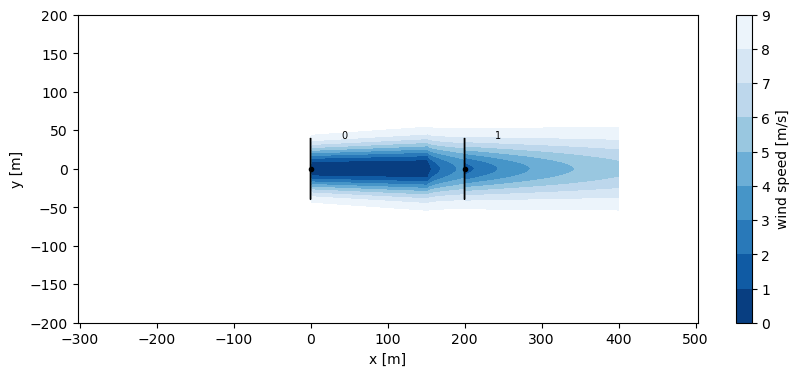

In [3]:
from py_wake.superposition_models import LinearSum

linear_sum = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555, superpositionModel=LinearSum(), use_effective_ws=True)
plt.figure(figsize=(10,4))
linear_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### SquaredSum

The SquaredSum model is often used in combination with wake deficit models where the downstream wakes are scaled with the ambient free-stream velocity to avoid negative wind speeds. It is, however, a method to compensate for an inconsistent formulation, see section 2.2 in https://backend.orbit.dtu.dk/ws/portalfiles/portal/151671395/Park2_Documentation_and_Validation.pdf

Text(0, 0.5, 'y [m]')

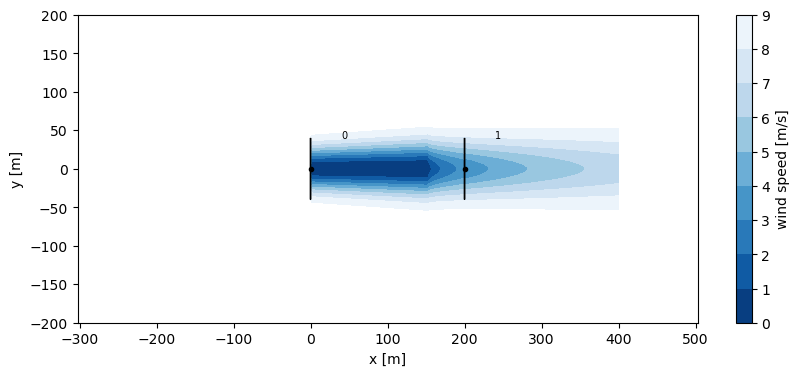

In [4]:
from py_wake.superposition_models import SquaredSum

squared_sum = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555, superpositionModel=SquaredSum())
plt.figure(figsize=(10,4))
squared_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### MaxSum

Text(0, 0.5, 'y [m]')

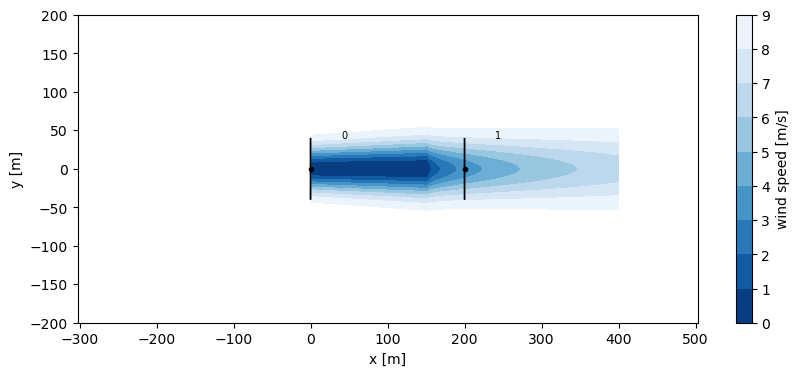

In [5]:
from py_wake.superposition_models import MaxSum

max_sum = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555, superpositionModel=MaxSum())
plt.figure(figsize=(10,4))
max_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### WeightedSum

Text(0, 0.5, 'y [m]')

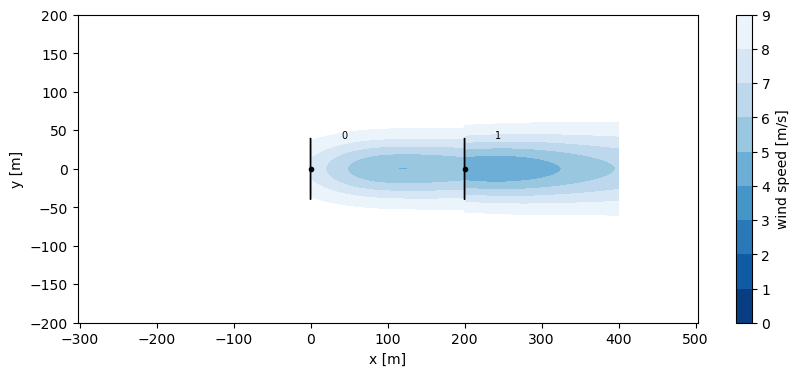

In [6]:
from py_wake.superposition_models import WeightedSum

weighted_sum = Zong_PorteAgel_2020(site, windTurbines, use_effective_ws=True, superpositionModel=WeightedSum())

plt.figure(figsize=(10,4))
weighted_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### SqrMaxSum

Text(0, 0.5, 'y [m]')

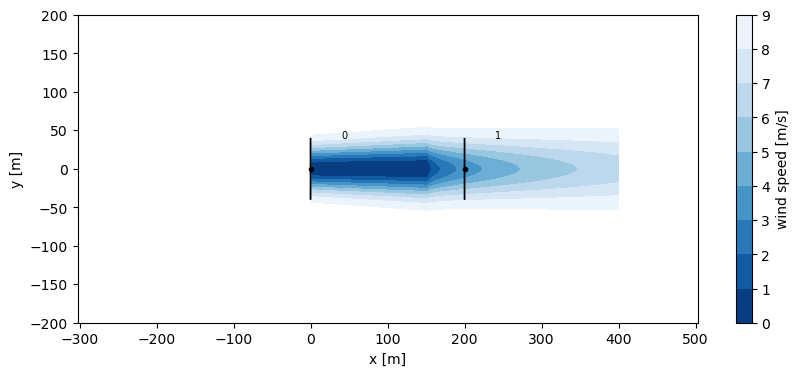

In [7]:
from py_wake.superposition_models import SqrMaxSum

sqr_max_sum = Zong_PorteAgel_2020(site, windTurbines, use_effective_ws=True, superpositionModel=WeightedSum(),
                                  turbulenceModel=CrespoHernandez(addedTurbulenceSuperpositionModel=SqrMaxSum()))
plt.figure(figsize=(10,4))
sqr_max_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# Turbulence Models

The turbulence models in PyWake are used to calculate the added turbulence in the wake from one wind turbine to downstream turbines or sites in the wind farm. These are important when the flow properties behind the rotor must be accurately represented, for example for calculation of fatigue loading of turbine components.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

First we create a simple function to plot the different turbulence models available in PyWake.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T
D = windTurbines.diameter()

In [3]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot
from py_wake.deficit_models import NOJDeficit

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_turb_map(model, cmap='Blues'):
    fm = get_flow_map(NOJDeficit(),turbulenceModel=model)
    fm.plot(fm.TI_eff, clabel="Added turbulence intensity [-]", levels=100, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel="Downwind distance [x/D]",
               xlim=[fm.x.min() / D, fm.x.max() / D], ylim=[fm.y.min() / D, fm.y.max() / D], axis='auto')

### STF2005TurbulenceModel

Steen Frandsen model implemented according to IEC61400-1, 2005 and weight according to Steen Frandsen's [thesis](https://orbit.dtu.dk/en/publications/turbulence-and-turbulence-generated-structural-loading-in-wind-tu).

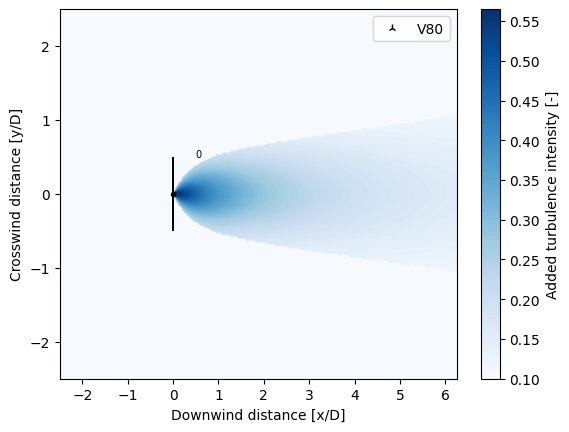

In [4]:
from py_wake.turbulence_models import STF2005TurbulenceModel
plot_turb_map(STF2005TurbulenceModel())

### STF2017TurbulenceModel

Steen Frandsen model implemented according to IEC61400-1, 2017 and weight according to Steen Frandsen's [thesis](https://orbit.dtu.dk/en/publications/turbulence-and-turbulence-generated-structural-loading-in-wind-tu).

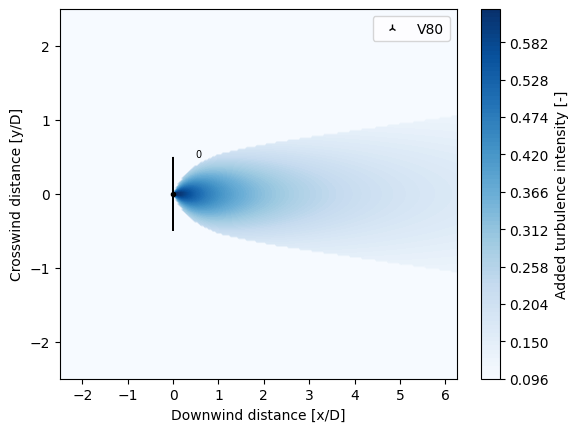

In [5]:
from py_wake.turbulence_models import STF2017TurbulenceModel
plot_turb_map(STF2017TurbulenceModel())

**STF20XXTurbulenceModel with IEC-based spread angle**

The `STF2005TurbulenceModel` and `STF2017TurbulenceModel` take a `weight_function` input which defaults to the bell-shaped `FrandsenWeight` defined in Steen Frandsen's thesis. As an alternative the `IECWeight` applies the full added turbulence in a 21.6$^\circ$ spread angle up to 10 diameter downstream. 

Note, this is a debatable interpretation of the IEC standard which includes a 6% contribution from neighbouring wind turbines when calculating the omni-directional effective turbulence intensity. These 6% maps to a spread angle of 360$^\circ\cdot$ 6% = 21.6$^\circ$.

Note, the IEC standard includes more concepts which is not implemented in PyWake.

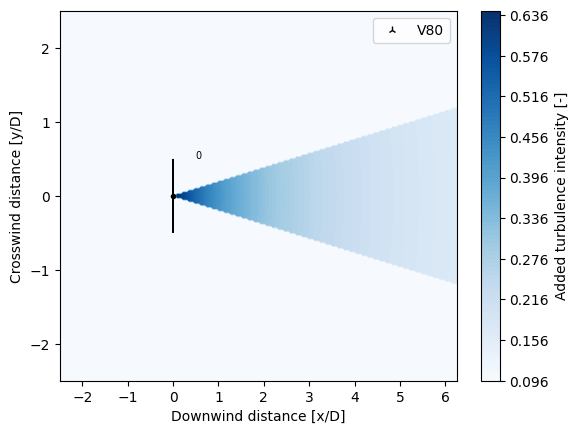

In [6]:
from py_wake.turbulence_models import STF2017TurbulenceModel, IECWeight
from py_wake.superposition_models import SqrMaxSum
plot_turb_map(STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=SqrMaxSum(), 
                                     weight_function=IECWeight(distance_limit=10)))

### GCLTurbulence

Gunner Chr. Larsen model implemented according to:
    
Pierik, J. T. G., Dekker, J. W. M., Braam, H., Bulder, B. H., Winkelaar, D., Larsen, G. C., Morfiadakis, E., Chaviaropoulos, P., Derrick, A., & Molly, J. P. (1999). European wind turbine standards II (EWTS-II). In E. L. Petersen, P. Hjuler Jensen, K. Rave, P. Helm, & H. Ehmann (Eds.), Wind energy for the next millennium. Proceedings (pp. 568-571). James and James Science Publishers.

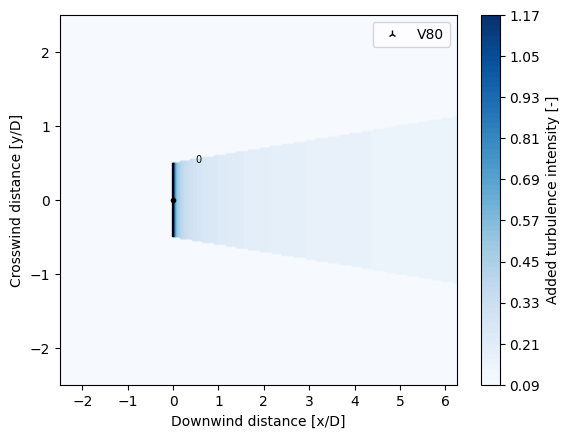

In [7]:
from py_wake.turbulence_models import GCLTurbulence
plot_turb_map(GCLTurbulence())

### CrespoHernandez

Implemented according to: A. Crespo and J. Hernández, Turbulence characteristics in wind-turbine wakes, J. of Wind Eng. and Industrial Aero. 61 (1996) 71-85.

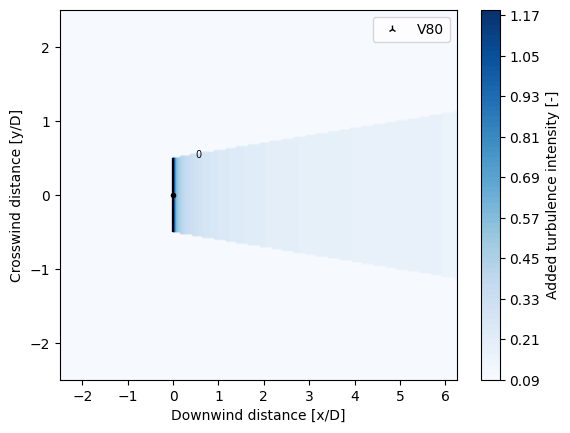

In [8]:
from py_wake.turbulence_models import CrespoHernandez
plot_turb_map(CrespoHernandez())

### Comparing turbulence models

In [9]:
#printing all available wake deficit models in PyWake
from py_wake.utils.model_utils import get_models
from py_wake.turbulence_models.turbulence_model import TurbulenceModel

turbulenceModels = get_models(TurbulenceModel, exclude_None=True)

for model in turbulenceModels:
    print (model.__name__)

CrespoHernandez
GCLTurbulence
STF2005TurbulenceModel
STF2017TurbulenceModel


**1) Turbulence intensity along center line**

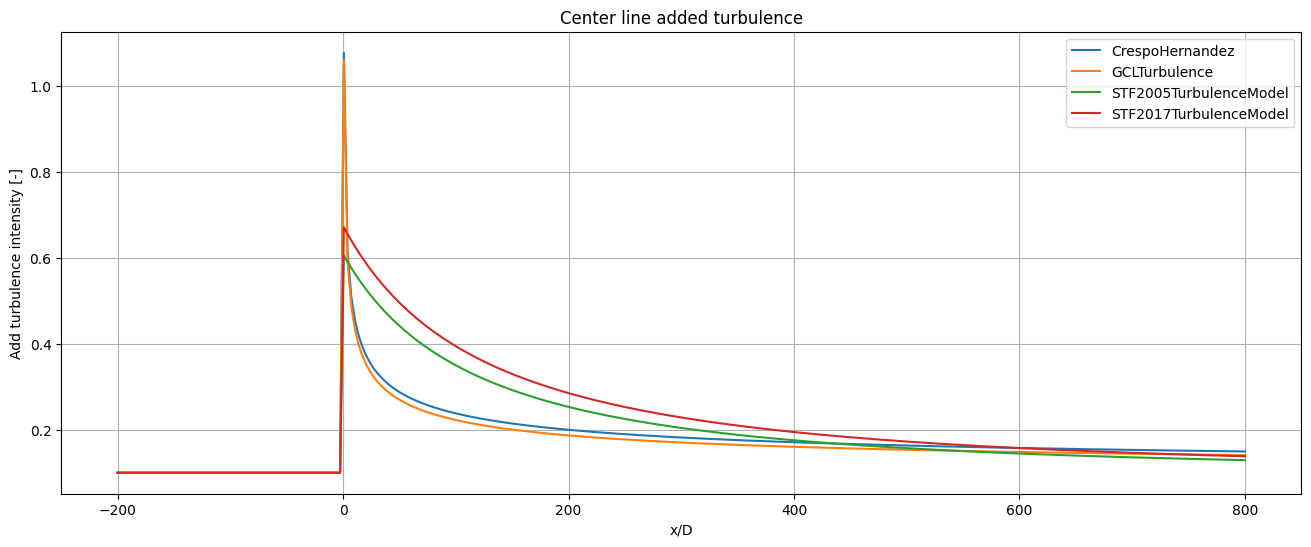

In [10]:
plt.figure(figsize=((16,6)))
for i, model in enumerate(turbulenceModels):
    fm = get_flow_map(NOJDeficit(), turbulenceModel=model(), grid=XYGrid(x=np.linspace(-200,800,300), y=0))
    plt.plot(fm.x, fm.TI_eff.squeeze(), ('-','--')[i//10], label=model.__name__)
setup_plot(title="Center line added turbulence", xlabel='x/D', ylabel='Add turbulence intensity [-]')

**2) Deficit profile 2D downstream**

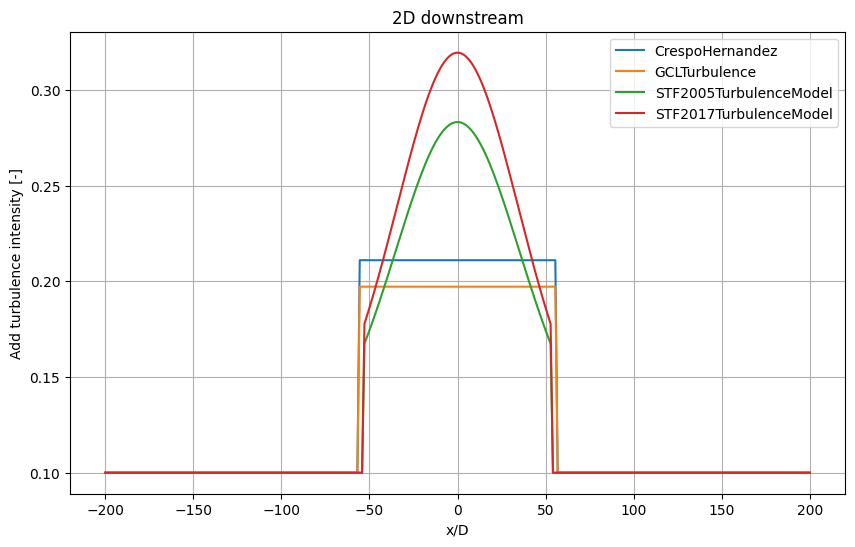

In [11]:
d = 2
plt.figure(figsize=((10,6)))
for i, model in enumerate(turbulenceModels):
    fm = get_flow_map(NOJDeficit(), turbulenceModel=model(), grid=XYGrid(x=d*D, y=np.linspace(-200,200,300)))
    plt.plot(fm.y, fm.TI_eff.squeeze(), ('-','--')[i//10], label=model.__name__)
setup_plot(title="%sD %sstream"%(abs(d),('down','up')[d<0]), xlabel='x/D', ylabel='Add turbulence intensity [-]')

# Wake Deficit Models

The wake deficit models compute the wake deficit caused by a single wind turbine. In PyWake, there are several wake deficit models, which include:

- [NOJDeficit](#NOJDeficit)
- [TurboNOJDeficit](#TurboNOJDeficit)
- [FugaDeficit](#FugaDeficit)
- [BastankhahGaussianDeficit](#BastankhahGaussianDeficit)
- [IEA37SimpleBastankhahGaussianDeficit](#IEA37SimpleBastankhahGaussianDeficit)
- [NiayifarGaussianDeficit](#NiayifarGaussianDeficit)
- [ZongGaussianDeficit](#ZongGaussianDeficit)
- [CarbajofuertesGaussianDeficit](#CarbajofuertesGaussianDeficit)
- [TurboGaussianDeficit](#TurboGaussianDeficit)
- [GCLDeficit](#GCLDeficit)
- [SuperGaussianDeficit](#SuperGaussianDeficit)

**Note**: The implementation of the deficit models is highly vectorized and therefore suffixes are used to indicate the dimension of variables. The suffixes used in this context are:

- i: source wind turbines
- j: destination wind turbines
- k: wind speeds
- l: wind directions

**This means that** `deficit_ijlk[0,1,2,3]` **holds the deficit caused by the first turbine on the second turbine for the third  wind direction and fourth wind speed**.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
#here we import all wake deficit models available in PyWake
import numpy as np
import matplotlib.pyplot as plt
import os
import py_wake

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()

from py_wake import NOJ
from py_wake import Fuga
from py_wake import FugaBlockage
from py_wake import BastankhahGaussian

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

models = {'NOJ': NOJ(site,windTurbines), 
          'Fuga': Fuga(lut_path,site,windTurbines),
          'FugaBlockage': FugaBlockage(lut_path,site,windTurbines), 
          'BGaus': BastankhahGaussian(site,windTurbines)
         }

In addition, these models can easily be combined with other models to better describe the wake behind the turbine, e.g. NOJ with linear sum superposition:

In [3]:
from py_wake.superposition_models import LinearSum

models['NOJLinear'] = NOJ(site,windTurbines,superpositionModel=LinearSum())

Or models can be combined in custom ways, e.g. `NOJDeficit` for the wake, `LinearSum` superposition and `SelfSimilarityDeficit` for the blockage:

In [4]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import NOJDeficit, SelfSimilarityDeficit

models['NOJ_ss'] = All2AllIterative(site,windTurbines,
                                          wake_deficitModel=NOJDeficit(),
                                          superpositionModel=LinearSum(), 
                                          blockage_deficitModel=SelfSimilarityDeficit())

##  Definition and configuration

First, we create some functions to visualize wake maps for different conditions and wake models.

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot

#turbine diameter
D = 80

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0, 10, 55)):
    fm = get_flow_map(model)
    fm.plot(fm.ws - fm.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[fm.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')

def plot_wake_deficit_map(model):
    cmap = np.r_[[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap))

**Below are the two models in PyWake that follow a top-hat shape, and are only valid in the far wake.**

## NOJDeficit

The NOJDeficit model is implemented according to Niels Otto Jensen, "A note on wind generator interaction." (1983), i.e. a top-hat wake.

According to Jensen, the velocity in the wake $V$ is defined as:

$$V = U\left(1 - 2a\left(\frac{r_o}{r_o + \alpha x}\right)^2\right)$$

where $U$ is the free stream velocity, $r_o$ the wake radius, $x$ the downstream distance and $\alpha$ the entraintment constant (with a value of 0.1).

Only valid in the far wake.

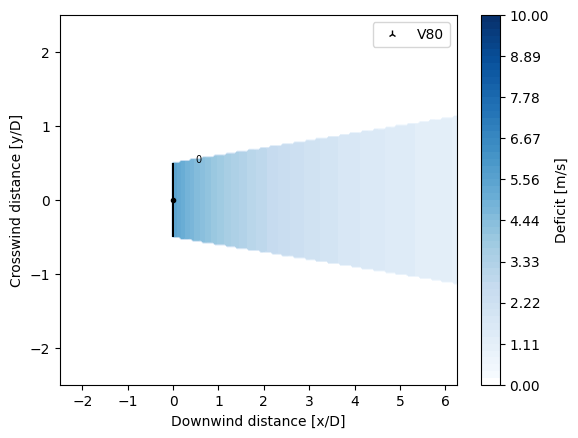

In [6]:
from py_wake.deficit_models import NOJDeficit
plot_wake_deficit_map(NOJDeficit())

## TurboNOJDeficit

Implemented according to Nygaard 2020 J. Phys.: Conf. Ser. 1618 062072 https://doi.org/10.1088/1742-6596/1618/6/062072 [1].

Modified definition of the wake expansion given by Nygaard [1], which assumes the wake expansion rate to be proportional to the local turbulence intensity in the wake. Here the local turbulence intensity is defined as the combination of ambient and wake added turbulence. Using the added wake turbulence model by Frandsen and integrating, an analytical expression for the wake radius can be obtained.

The definition in [1] of ambient turbulence is the free-stream TI and for this the model constant A has been tuned, however a fully consistent formulation of the model should probably use the locally effective TI, which includes the added turbulence from upstream turbines. 

The velocity deficit is calculated as in the `NOJDeficit` model, with a modification of the wake radius term $r_o$, given by:

$$
\begin{aligned}
D_w(x)=0.5 + & \frac{A I_0 D}{\beta} \\ & \times \left(\sqrt{(\alpha+\beta x / D)^2+1}-\sqrt{1+\alpha^2}-\ln \left[\frac{\left(\sqrt{(\alpha+\beta x / D)^2+1}+1\right) \alpha}{\left(\sqrt{1+\alpha^2}+1\right)(\alpha+\beta x / D)}\right]\right)
\end{aligned}
$$

where $A$ is the wake expansion parameter, set to a constant value of 0.6, $I_0$ is the free stream TI, $D$ is the rotor diameter, $x$ the downstream distance and $\alpha$ and $\beta$ are parameters that depend on the turbulence $I_0$ and the turbine's $C_T$.

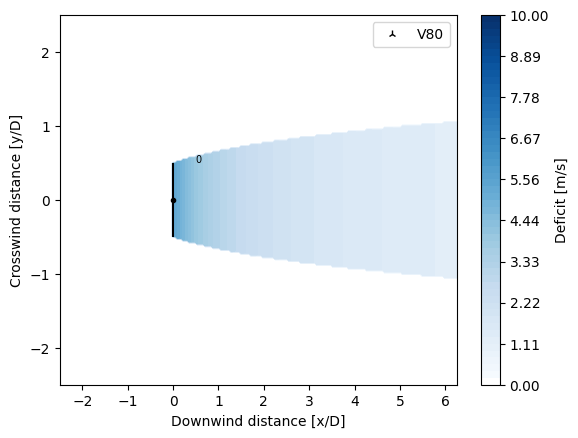

In [7]:
from py_wake.deficit_models import TurboNOJDeficit
plot_wake_deficit_map(TurboNOJDeficit())

**The rest of the models follow a Gaussian shape, with the advantage of having models for calculation of the near wake (Fuga, Zong Gaussian, Super Gaussian) as well as a model to simulate blockage (Fuga)**

## BastankhahGaussianDeficit

The Bastankhah Gaussian Deficit model is implemented according to Bastankhah M and Porté-Agel F. "A new analytical model for wind-turbine wakes" J. Renew. Energy. 2014;70:116-23.

By applying mass and momentum conservation and assuming a self-similar Gaussian profile for the wake, a general expression for the velocity deficit is derived:

$$
\frac{\Delta U}{U_{\infty}}=C(x) e^{-\frac{x^2}{2 \sigma^2}}
$$

The maximum velocity deficit at the center of the wake $C(x)$ is defined by:

$$
C(x)=1-\sqrt{1-\frac{C_{\mathrm{T}}}{8\left(\sigma / d_0\right)^2}}
$$

and the wake width ($\sigma$) is defined as:

$$\frac{\sigma}{d_0} = k^* x / d_0+\varepsilon$$

where $k$ represents the wake expansion parameter and $\varepsilon$ = 0.2 $\beta$, with $\beta$ being a parameter function of the turbine's $C_T$.

Thus, the normalized velocity deficit can be calculated as:

$$
\begin{aligned}
\frac{\Delta U}{U_{\infty}}= & \left(1-\sqrt{1-\frac{C_{\mathrm{T}}}{8\left(k^* x / d_0+\varepsilon\right)^2}}\right) \\
& \times \exp \left(-\frac{1}{2\left(k^* x / d_0+\varepsilon\right)^2}\left\{\left(\frac{z-z_{\mathrm{h}}}{d_0}\right)^2+\left(\frac{y}{d_0}\right)^2\right\}\right)
\end{aligned}
$$

where $C_T$ is the turbine's thrust coefficient, $x$ the downstream distance, $z_H$ the turbine's hub height, and $y$ and $z$ the spanwise and vertical coordinates, respectively.

The model is valid in the far wake only.

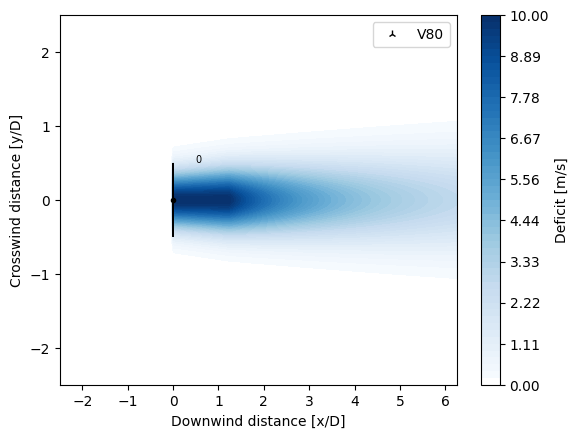

In [8]:
from py_wake.deficit_models import BastankhahGaussianDeficit
plot_wake_deficit_map(BastankhahGaussianDeficit())

## IEA37SimpleBastankhahGaussianDeficit

The IEA37 Simple Bastankhah Gaussian Deficit model is implemented according to the [IEA task 37 documentation](https://github.com/byuflowlab/iea37-wflo-casestudies/blob/master/cs1-2/iea37-wakemodel.pdf) and is equivalent to `BastankhahGaussianDeficit` for:

$$beta=1/\sqrt{8} \sim ct=0.9637188$$

The model is valid in the far wake only.

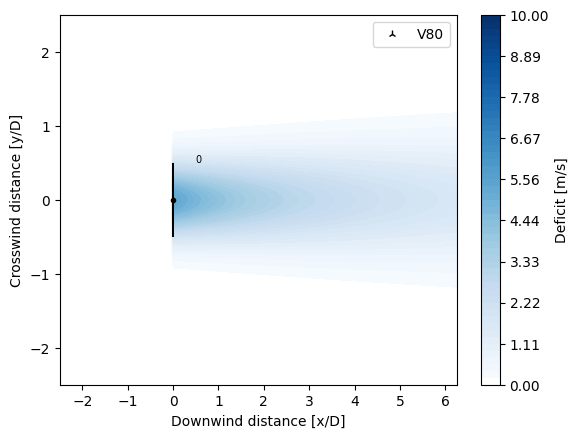

In [9]:
from py_wake.deficit_models import IEA37SimpleBastankhahGaussianDeficit
plot_wake_deficit_map(IEA37SimpleBastankhahGaussianDeficit())

## NiayifarGaussianDeficit

Implemented according to Amin Niayifar and Fernando Porté-Agel, "Analytical Modeling of Wind Farms: A New Approach for Power Prediction", Energies 2016, 9, 741; doi:10.3390/en9090741.

The calculation of the velocity deficit is made as in `BastankhahGaussianDeficit`, with the modification of the wake expansion parameter $k^*$.

This wake deficit model accounts for the local turbulence intensity when evaluating the wake expansion. The expansion rate $k^*$ varies linearly with local turbluence intensity:

$$k^* = a1 I + a2$$

The default constants are set according to publications by Porte-Agel's group, which are based on LES simulations, where $a1 = 0.3837$ and $a2 = 0.003678$. Lidar field measurements by Fuertes et al. (2018) indicate that a = [0.35, 0.0] is also a valid selection.

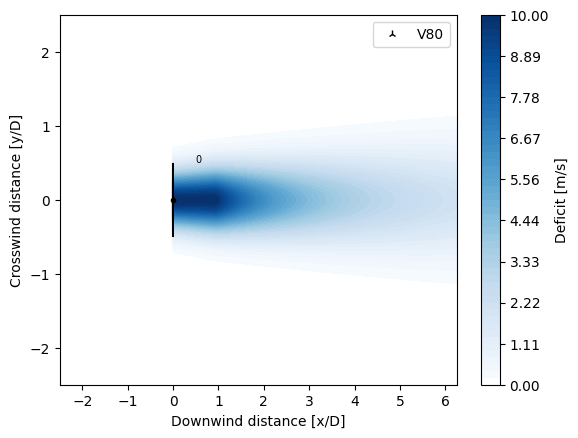

In [10]:
from py_wake.deficit_models import NiayifarGaussianDeficit
plot_wake_deficit_map(NiayifarGaussianDeficit(a=[0.38, 4e-3]))

## ZongGaussianDeficit

Implemented according to Haohua Zong and Fernando Porté-Agel, "A momentum-conserving wake superposition method for wind farm power prediction", J. Fluid Mech. (2020), vol. 889, A8; doi:10.1017/jfm.2020.77.

Based on the `NiayifarGaussianDeficit` model, the wake expansion is also function of the local turbulence intensity and the wake width expression now follows the approach by Shapiro et al. (2018). Additional to the model of Niayifar et al. is a new wake width ($\sigma$) expression, which uses the near-wake length estimation by Vermeulen (1980).

The near-wake length expression is defined as:

$$
x_n=\frac{\sqrt{0.214+0.144 m}(1-\sqrt{0.134+0.124 m})}{(1-\sqrt{0.214+0.144 m}) \sqrt{0.134+0.124 m}} \frac{r_0}{(d r / d x)}
$$

With the new expression for the wake width represented by:

$$
\sigma = \epsilon + k_w \ln \left[1+\exp \left(\frac{x-x_n}{D}\right)\right] * D
$$

where $\epsilon = (1 / \sqrt{8}) C_T$ and $k_w$ is the wake expansion rate.

The thrust coefficient used in the deficit calculation is now written as an error function of the streamwise coordinate due to the effect of the near-wake pressure gradient.

$$
C_t^i(x)= C_T (1+\operatorname{erf}(x / D)) / 2
$$

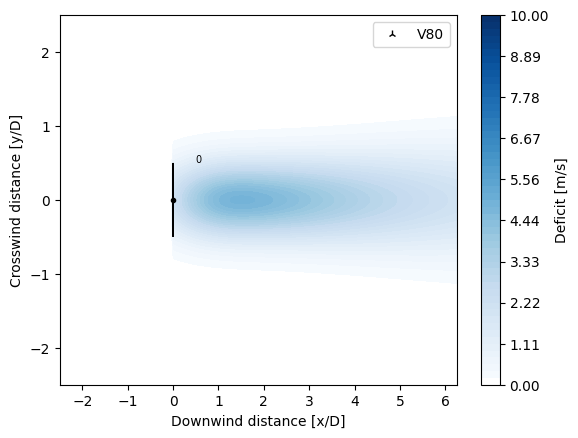

In [11]:
from py_wake.deficit_models import ZongGaussianDeficit
plot_wake_deficit_map(ZongGaussianDeficit(a=[0.38, 4e-3]))

## CarbajoFuertesGaussianDeficit

Modified version from the `ZongGaussianDeficit` model with Gaussian constants, as seen in: Fernando Carbajo Fuertes, Corey D. Markfor and Fernando Porté-Agel, "Wind TurbineWake Characterization with Nacelle-Mounted Wind Lidars for Analytical Wake Model Validation", Remote Sens. 2018, 10, 668; doi:10.3390/rs10050668.

Carbajo Fuertes et al. derived Gaussian wake model parameters from nacelle liadar measurements from a 2.5MW turbine and found a
variation of epsilon with wake expansion, this in fact identical to the formulation by Zong, only that the near-wake length is fixed for Carbajo Fuertes at $xth = 1.91 (x/D)$. We took the relationships found by them and incorporated them into the Zong formulation. This wake deficit model includes an empirical correlation for epsilon as well as new constants for the wake expansion factor equation.

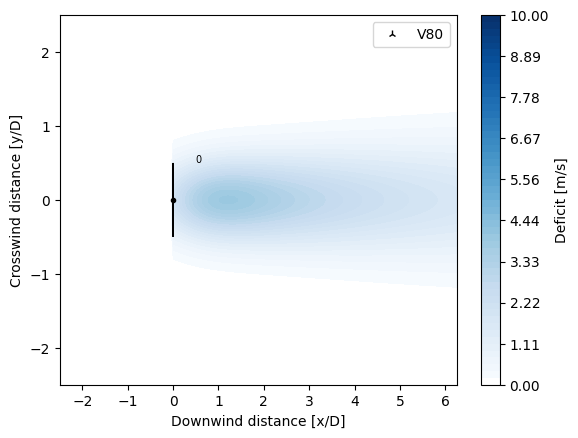

In [12]:
from py_wake.deficit_models import CarbajofuertesGaussianDeficit
plot_wake_deficit_map(CarbajofuertesGaussianDeficit())

## TurboGaussianDeficit

Implemented similar to Ørsted's TurbOPark model (https://github.com/OrstedRD/TurbOPark).

The calculation of the deficit is similar to that in `TurboNOJDeficit` with the distinction of assuming a Gaussian shape for the expansion of the wake using the wake width ($\sigma$) expression instead of the wake radius. The $\epsilon$ parameter is defined as in `BastahnkhahGaussianDeficit`, 0.2 $\beta$.

$$
\begin{aligned}
\frac{\sigma_{w, i}\left(\hat{x}_i\right)}{D_i}= \epsilon_i + & \frac{A I_0}{\beta} \\ & \times \left(\sqrt{\left(\alpha+\beta \hat{x}_i / D_i\right)^2+1}-\sqrt{1+\alpha^2}-\ln \left[\frac{\left(\sqrt{\left(\alpha+\beta \hat{x}_i / D_i\right)^2+1}+1\right) \alpha}{\left(\sqrt{1+\alpha^2}+1\right)\left(\alpha+\beta \hat{x}_i / D_i\right)}\right]\right)
\end{aligned}
$$

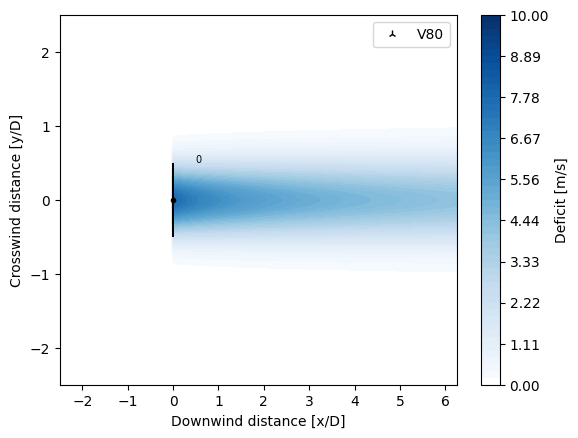

In [13]:
from py_wake.deficit_models import TurboGaussianDeficit
plot_wake_deficit_map(TurboGaussianDeficit())

## SuperGaussianDeficit

Implemented according to Blondel and Cathelain (2020), "An alternative form of the super-Gaussian wind turbine wake model" Wind Energ. Sci., 5, 1225–1236, 2020 https://doi.org/10.5194/wes-5-1225-2020 [1].

New calibrated parameters taken from Blondel (2023), "Brief communication: A momentum-conserving superposition method applied to the super-Gaussian wind turbine wake model", Wind Energ. Sci., 8, 141–147, 2023, 2023 https://doi.org/10.5194/wes-8-141-2023 [2].

The Super Gaussian deficit model is derived from the general equation for velocity deficit seen in `BastankhahGaussianDeficit` with the addition of the super gaussian order $n$, which describes the evolution of the wake. In this case, the wake profile transitions from top-hat to gaussian, with high values of $n$ representing the near wake and low values (approaching $n =2$) representing a purely Gaussian profile.

The velocity deficit is calculated as follows:

$$
\frac{U_{\infty}-U_{\mathrm{w}}}{U_{\infty}}=C(x) e^{-\bar{r}^n /\left(2 \sigma^2\right)}
$$

where the maximum velocity deficit $C(x)$ is defined as:

$$
C(x)=2^{2 / n-1}-\sqrt{2^{4 / n-2}-\frac{n C_T}{16 \Gamma(2 / n) \sigma^{4 / n}}} .
$$

The characteristic wake width ($\sigma$) is also a function of the TI as in the Bastankhah Gaussian model.

$$ \sigma = (a_s T_i + b_s)x + c_s \sqrt{\beta} $$

Lastly, the analytical super gaussian parameter $n$ is based on curve fitting and represented by:

$$ n = a_f e^{b_f x} + c_f $$

The parameters used for the model ($a_s, b_s, c_s, a_f, b_f, c_f$) are calibrated with two measurement campaings: particle velocimetry measurements and lidar measurements. Some of the parameters are dependent on the turbulence intensity and thrust coefficient, as seen in [1].

There are two classes defined:

- `BlondelSuperGaussianDeficit2020`: which uses the calibrated parameters in Table 2 and 3 in [1].
- `BlondelSuperGaussianDeficit2023`: which uses the latest calibrated parameters found in Table 1 in [2].

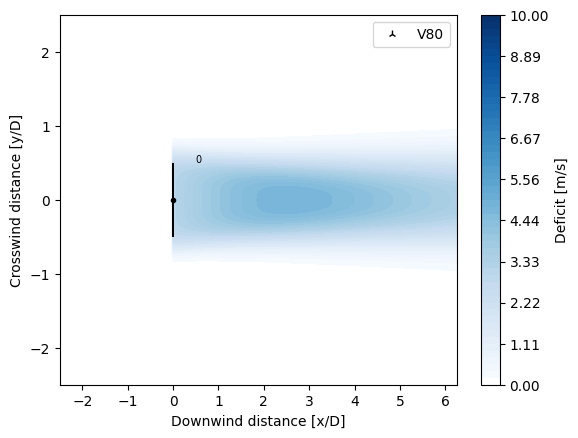

In [14]:
from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
plot_wake_deficit_map(BlondelSuperGaussianDeficit2020())

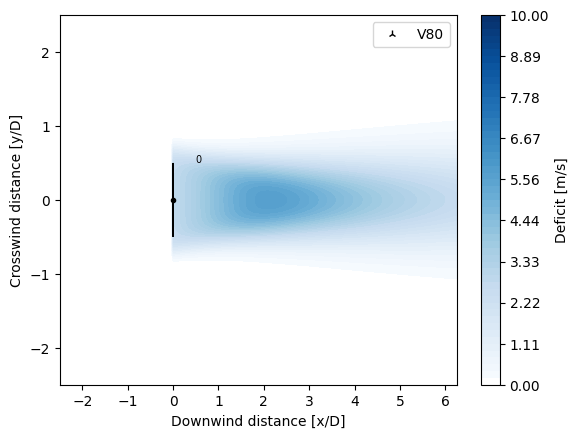

In [15]:
from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2023
plot_wake_deficit_map(BlondelSuperGaussianDeficit2023())

## FugaDeficit

The FugaDeficit model calculates the wake deficit based on a set of look-up tables computed by a linearized RANS solver. The look-up tables are created in advance using the [Fuga GUI](https://orbit.dtu.dk/en/publications/developments-of-the-offshore-wind-turbine-wake-model-fuga).

The most important parameters to create the look-up tables are:

- Wind turbine diameter
- Wind tubine hub height
- Terrain roughness length
- Lower and upper height of output domain (if, for example, the wake is to be studied around the rotor only or for a whole wind farm)

The FugaDeficit model can model the near wake, far wake and blockage deficit.

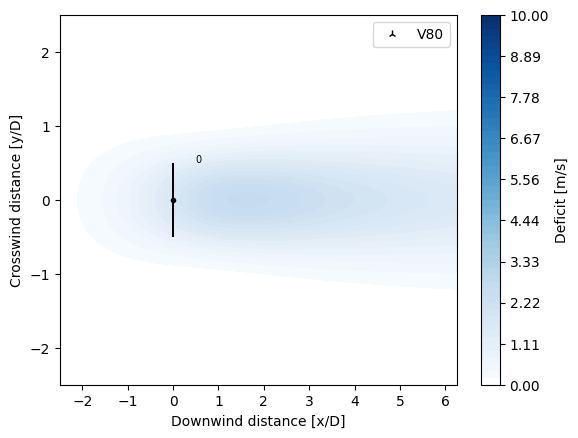

In [16]:
import py_wake
from py_wake.deficit_models import FugaDeficit

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

plot_wake_deficit_map(FugaDeficit(lut_path))

## GCLDeficit

Implemented according to Larsen, G. C. (2009), "A simple stationary semi-analytical wake model", Risø National Laboratory for Sustainable Energy,  Technical University of Denmark. Denmark. Forskningscenter Risoe. Risoe-R, No. 1713(EN).

It is based on an analytical solution of the thin shear layer approximation of the NS equations. The wake flow fields are assumed rotationally symmetric, and the rotor inflow fields are consistently assumed uniform. The effect of expansion is approximately accounted for by imposing suitable empirical downstream boundary conditions on the wake expansion that depend on the rotor thrust and the ambient turbulence conditions, respectively.

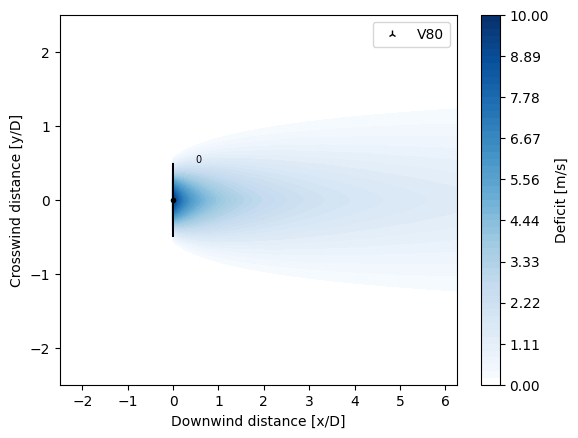

In [17]:
from py_wake.deficit_models import GCLDeficit
plot_wake_deficit_map(GCLDeficit())

## Comparing wake deficit models

In [20]:
#printing all available wake deficit models in PyWake
from py_wake.utils.model_utils import get_models
from py_wake.deficit_models.deficit_model import WakeDeficitModel

deficitModels = get_models(WakeDeficitModel)
for deficitModel in deficitModels:
    print (deficitModel.__name__)

NOJDeficit
FugaDeficit
FugaMultiLUTDeficit
FugaYawDeficit
BastankhahGaussianDeficit
BlondelSuperGaussianDeficit2020
BlondelSuperGaussianDeficit2023
CarbajofuertesGaussianDeficit
IEA37SimpleBastankhahGaussianDeficit
NiayifarGaussianDeficit
TurboGaussianDeficit
ZongGaussianDeficit
GCLDeficit
NoWakeDeficit
NOJLocalDeficit
TurboNOJDeficit


**1) Deficit along center line**

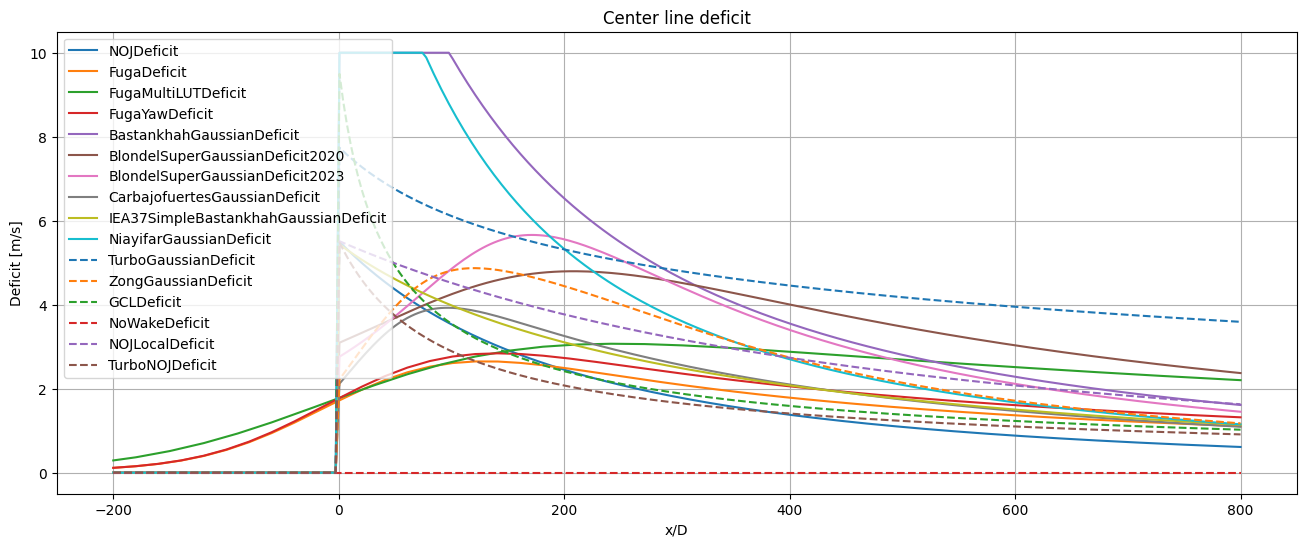

In [21]:
plt.figure(figsize=((16,6)))
for i, deficitModel in enumerate(deficitModels):
    fm = get_flow_map(deficitModel(), XYGrid(x=np.linspace(-200,800,300), y=0))
    plt.plot(fm.x, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
setup_plot(title="Center line deficit", xlabel='x/D', ylabel='Deficit [m/s]')

**2) Deficit profile downstream**

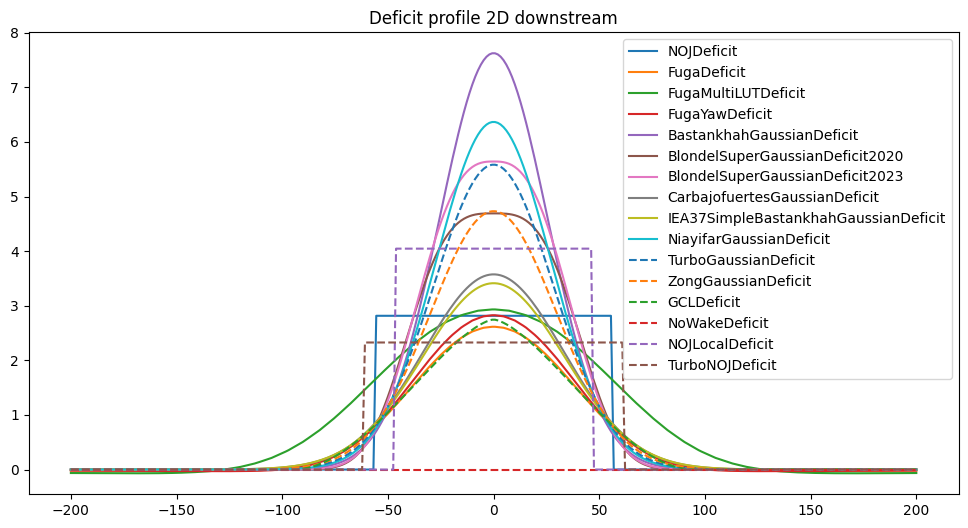

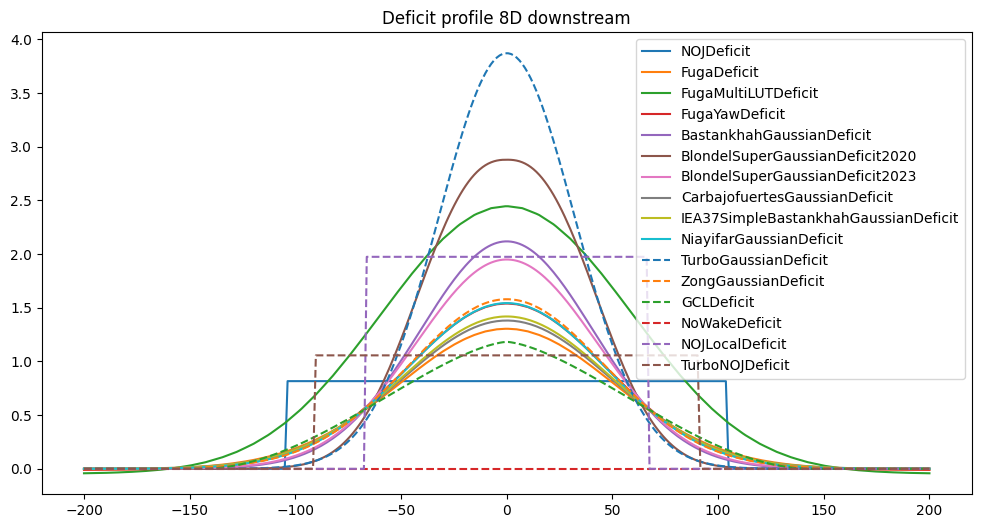

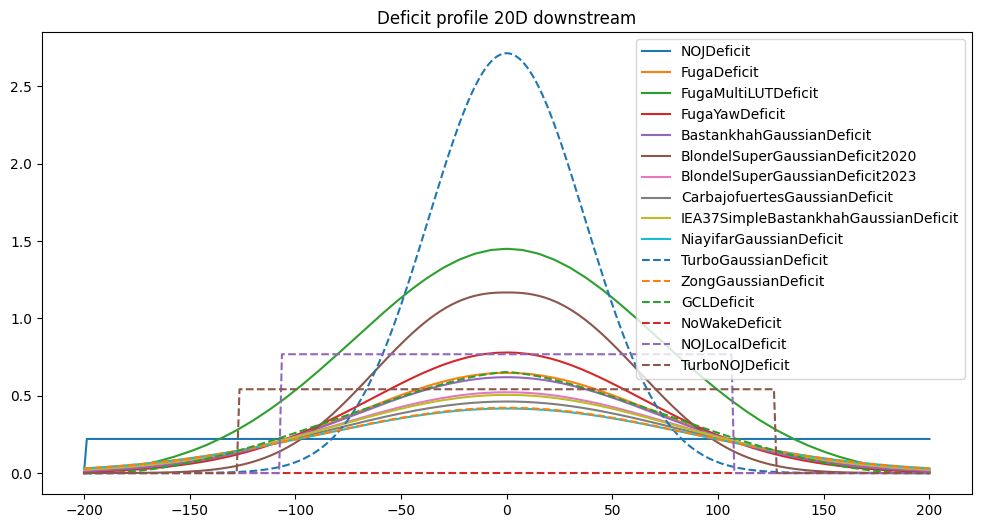

In [22]:
for d in 2,8,20:
    plt.figure(figsize=((12,6)))
    for i, deficitModel in enumerate(deficitModels):
        fm = get_flow_map(deficitModel(), XYGrid(x=d*D, y=np.linspace(-200,200,300)))
        plt.plot(fm.y, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
    plt.title(f'Deficit profile {d}D downstream')
    plt.legend()

## Implement your own deficit models

Deficit models must subclass `DeficitModel`and thus must implement the `calc_deficit` method and a class variable, `args4deficit` specifying the arguments required by its `calc_deficit` method

```python 
class DeficitModel(ABC):
    args4deficit = ['WS_ilk', 'dw_ijlk']

    @abstractmethod
    def calc_deficit(self):
        """Calculate wake deficit caused by the x'th most upstream wind turbines
        for all wind directions(l) and wind speeds(k) on a set of points(j)

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deficit

        See class documentation for examples and available arguments

        Returns
        -------
        deficit_ijlk : array_like
        """
```

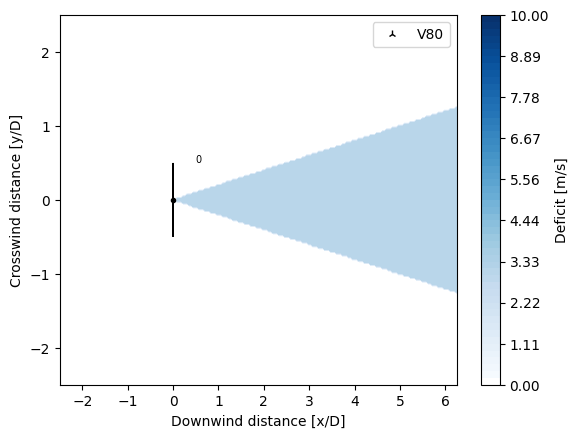

In [23]:
from py_wake.deficit_models.deficit_model import WakeDeficitModel
from numpy import newaxis as na
class MyDeficitModel(WakeDeficitModel):

    def calc_deficit(self, WS_ilk, dw_ijlk, cw_ijlk,**_):
        # 30% deficit in downstream triangle
        ws_10pct_ijlk = 0.3*WS_ilk[:,na]
        triangle_ijlk = (self.wake_radius(dw_ijlk=dw_ijlk)>cw_ijlk)
        return ws_10pct_ijlk *triangle_ijlk

    def wake_radius(self, dw_ijlk, **_):
        return (.2*dw_ijlk)

plot_wake_deficit_map(MyDeficitModel())

# Wind Turbine Object

For a given wind turbine type and effective wind speed (WS<sub>eff</sub>), the `WindTurbine` object provides the power and thrust coefficient (CT), as well as the wind turbine hub height (H) and diameter (D).

**Install PyWake if needed**

In [ ]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

### Setting up Windturbine objects

**Predefined WindTurbines example**

PyWake contains a few predefined turbines, e.g. the V80 from Hornsrev1, the 3.35MW from IEA task 37 and the DTU10MW reference turbine.

**First we import basic Python elements**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

**Now we import the wind turbines available in PyWake**

In [2]:
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.examples.data.hornsrev1 import V80
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.examples.data.dtu10mw import DTU10MW

v80 = V80()
iea37 = IEA37_WindTurbines()
dtu10mw = DTU10MW()

**You can also import wind turbine files from WAsP .wtg files**

In [3]:
from py_wake.examples.data import wtg_path

wtg_file = os.path.join(wtg_path, 'NEG-Micon-2750.wtg')
neg2750 = WindTurbine.from_WAsP_wtg(wtg_file)

**In addition, user-defined WindTurbine objects is also supported by PyWake**

Here it is necessary to specify the thrust coefficient (CT) and power curve of the wind turbine you want to create. The hub height and diameter are also parameters that must be specified.

In [4]:
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

u = [0,3,12,25,30]
ct = [0,8/9,8/9,.3, 0]
power = [0,0,2000,2000,0]

my_wt = WindTurbine(name='MyWT',
                    diameter=123,
                    hub_height=321,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))

PyWake has a `GenericWindTurbine` class which make a wind turbine where the power is computed by an analytical model based on diameter and nominal power.

The model takes a lot of optional inputs which default to empirical values, e.g.

- **air_density**= 1.225 kg/m$^3$
- **max_cp**= .49
- **constant_ct**= .8
- **gear_loss_const**= .01
- **gear_loss_var**= .014
- **generator_loss**= 0.03
- **converter_loss**= .03

In [5]:
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

#for a diameter of 178.3m and hub height of 119m
gen_wt = GenericWindTurbine('G10MW', 178.3, 119, power_norm=10000, turbulence_intensity=.1)

**Multi-type Wind Turbines**

You can collect a list of different turbine types into a single WindTurbines object

In [6]:
wts = WindTurbines.from_WindTurbine_lst([v80,iea37,dtu10mw,my_wt,gen_wt,neg2750])

In [8]:
types = wts.types()
print ("Name:\t\t%s" % "\t".join(wts.name(types)))
print('Diameter[m]\t%s' % "\t".join(map(str,wts.diameter(type=types))))
print('Hubheigt[m]\t%s' % "\t".join(map(str,wts.hub_height(type=types))))

Name:		V80	3.35MW	DTU10MW	MyWT	G10MW	NEG-Micon 2750/92 (2750 kW)
Diameter[m]	80.0	130.0	178.3	123.0	178.3	92.0
Hubheigt[m]	70.0	110.0	119.0	321.0	119.0	70.0


### Power curves and CT curves

**We plot first the power curve of the all turbines previously defined**

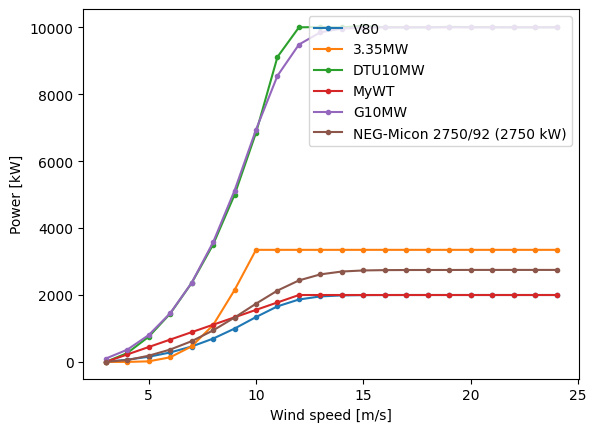

In [8]:
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')

for t in types:
    plt.plot(ws, wts.power(ws, type=t)*1e-3,'.-', label=wts.name(t))
plt.legend(loc=1)

**Now, we do the same for the CT curve of all turbines**

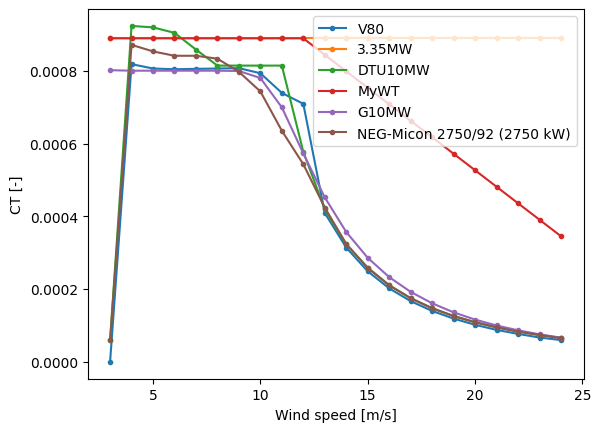

In [9]:
plt.xlabel('Wind speed [m/s]')
plt.ylabel('CT [-]')

for t in types:
    plt.plot(ws, wts.ct(ws, type=t),'.-', label=wts.name(t))
plt.legend(loc=1)

**You can also plot Multidimensional Power/CT curves**

Some WAsP wtg files define multiple wind turbine modes. E.g. the `Vestas V112-3.0 MW.wtg` which has 12 modes representing different levels of air density. In this case, the mode defaults to 0.

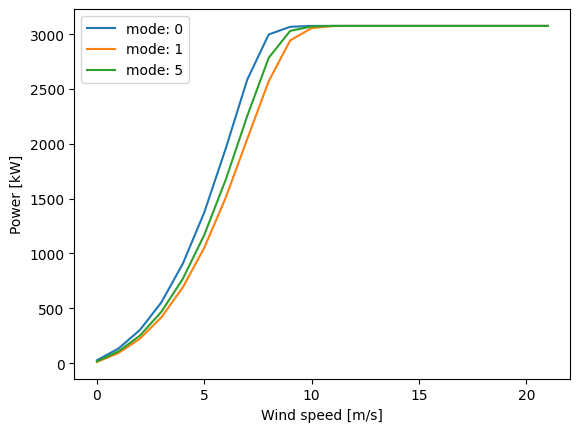

In [10]:
wtg_file = os.path.join(wtg_path, 'Vestas V112-3.0 MW.wtg')
v112 = WindTurbine.from_WAsP_wtg(wtg_file)
required_inputs, optional_inputs = v112.function_inputs
upct = {}

#selecting the modes to plot
for m in [0,1,5]:
    plt.plot(v112.power(ws, mode=m)/1000, label=f'mode: {m}')

p0,ct0 = v112.power_ct(ws, mode=0)
p1,ct1 = v112.power_ct(ws, mode=1)

plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**Discrete dimensions (e.g. operational mode)**

WindTurbines can be defined using a `PowerCtFunctionList`. In fact this is the approach used by multi-mode WAsP wind turbines and also when creating multi-type wind turbine (in which case the key is `type`).

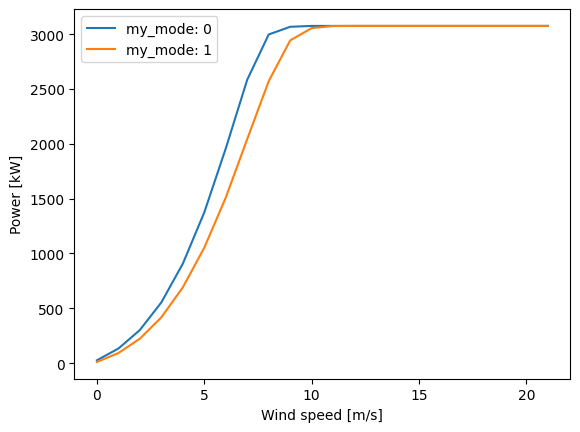

In [11]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList

mode0_power_ct=PowerCtTabular(ws, p0, 'w', ct0)
mode1_power_ct=PowerCtTabular(ws, p1, 'w', ct1)

multimode_power_ct = PowerCtFunctionList(key='my_mode', 
                                         powerCtFunction_lst=[mode0_power_ct, mode1_power_ct], 
                                         default_value=None)

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('MultimodeWT', 112, 84, powerCtFunction=multimode_power_ct)

for m in [0,1]:
    plt.plot(wt.power(ws, my_mode=m)/1000, label=f'my_mode: {m}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**It is also possible to setup a wind turbine using a multidimensional power and CT tabular array.**

In this case, the power and CT values will be calculated using multidimensional linear interpolation.

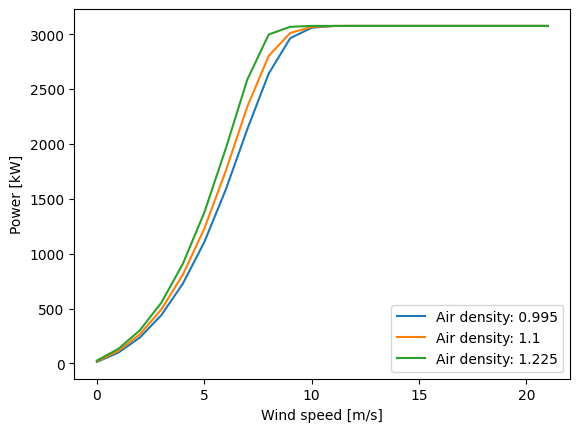

In [12]:
from py_wake.wind_turbines.power_ct_functions import PowerCtNDTabular

# setup multidimensional power and ct tabulars
# p0,ct0 ~ rho=0.95
# p1,ct1 ~ rho=1.225

power_array = np.array([p1,p0]).T
ct_array = np.array([ct1,ct0]).T
density = [0.95,1.225]

powerCtFunction = PowerCtNDTabular(input_keys=['ws','rho'], 
                 value_lst=[ws,density], 
                 power_arr=power_array, power_unit='w',
                 ct_arr=ct_array)

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

#looping through different values for air density
for r in [0.995, 1.1, 1.225]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**Alternatively, the data can be passed as an xarray dataset.**

The dataset must have the data variables, `power` and `ct`, and the coordinate, `ws`.

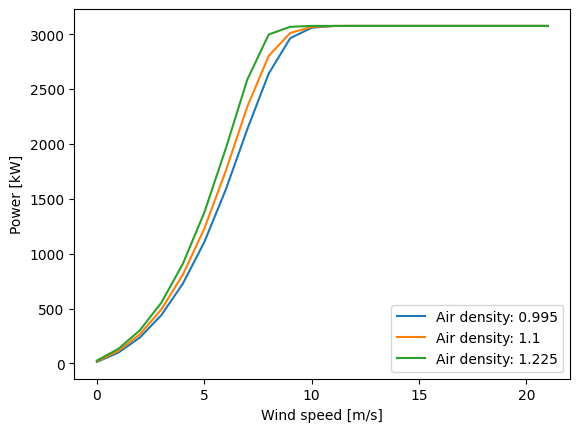

In [13]:
import xarray as xr
from py_wake.wind_turbines.power_ct_functions import PowerCtXr

ds = xr.Dataset(
        data_vars={'power': (['ws', 'rho'], np.array([p1,p0]).T),
                   'ct': (['ws', 'boost'], np.array([ct1, ct0]).T)},
        coords={'rho': [0.95,1.225], 'ws': ws})

curve = PowerCtXr(ds, 'w')

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

#looping through different values of air density
for r in [0.995, 1.1, 1.225]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**Finally, the Power and CT values can be calculated using a function which may take multiple input variables.**

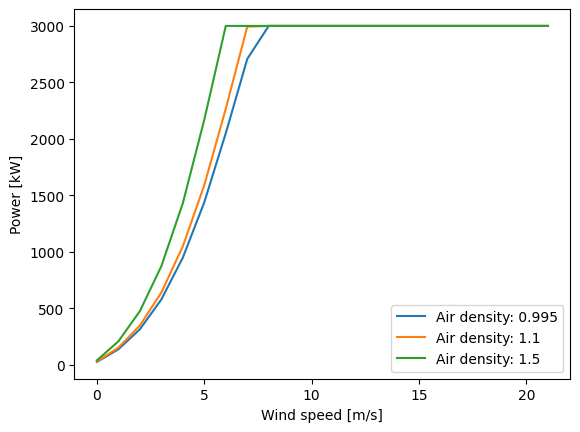

In [14]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunction

def density_scaled_power_ct(u, run_only, rho=1.225):
    # function to calculate power and ct
    if run_only==0: # power
        rated_power = 3e6
        density_scale=rho/.95
        return np.minimum(np.interp(u,ws, p0) * density_scale, rated_power) # density scaled power, limited by rated power
    elif run_only==1: #ct
        return 0*u # dummy ct, not used in this example
               
powerCtFunction = PowerCtFunction(
    input_keys=['ws','rho'], 
    power_ct_func=density_scaled_power_ct,
    power_unit='w', 
    optional_inputs=['rho'], # allowed to be optional as a default value is speficifyed in density_scaled_power_ct
)

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

#looping through different values for air density
for r in [0.995, 1.1, 1.5]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

You can also use the `GenericTIRhoWindTurbine` class, which extends the `GenericWindTurbine` with multidimensional power/CT curves that depend on turbulence intensity (`TI_eff`) and the air density (`Air_density`).

Text(0.5, 0, 'Wind speed [m/s]')

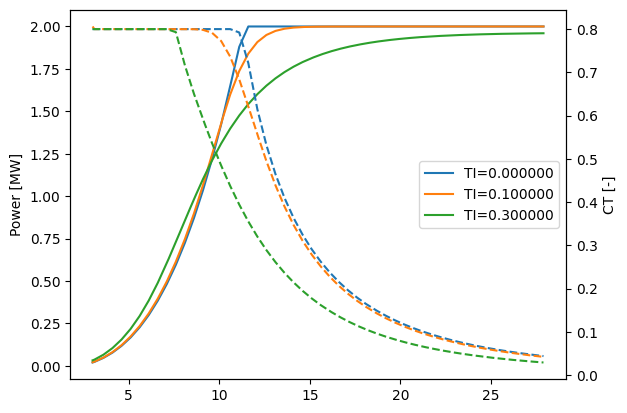

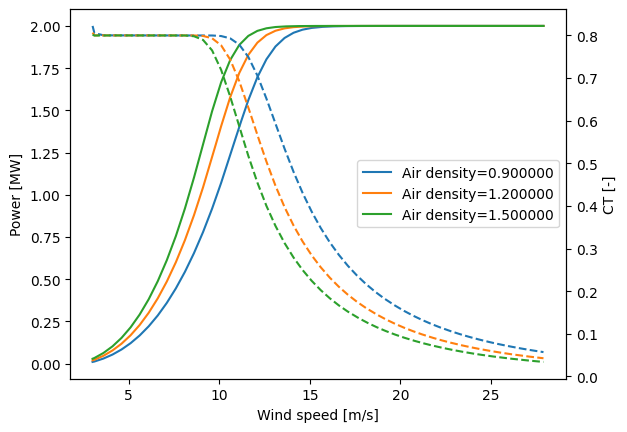

In [15]:
from py_wake.wind_turbines.generic_wind_turbines import GenericTIRhoWindTurbine

#specifying a diameter of 80m and hub height of 70m for different turbulence intensities
wt = GenericTIRhoWindTurbine('2MW', 80, 70, power_norm=2000,
                             TI_eff_lst=np.linspace(0, .5, 6), default_TI_eff=.1,
                             Air_density_lst=np.linspace(.9, 1.5, 5), default_Air_density=1.225)

u = np.arange(3, 28, .1)
ax1 = plt.gca()
ax2 = plt.twinx()

#looping through different values of turbulence intensity
for ti in [0, .1, .3]:
    p, ct = wt.power_ct(u, TI_eff=ti)
    ax1.plot(u, p / 1e6, label='TI=%f' % ti)
    ax2.plot(u, ct, '--')
ax1.legend(loc='center right')
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('CT [-]')

plt.figure()
u = np.arange(3, 28, .1)
ax1 = plt.gca()
ax2 = plt.twinx()

#looping through different values of air density
for rho in [.9,1.2,1.5]:
    p, ct = wt.power_ct(u, Air_density=rho)
    ax1.plot(u, p / 1e6, label='Air density=%f' % rho)
    ax2.plot(u, ct, '--')
ax1.legend(loc='center right')
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('CT [-]')
ax1.set_xlabel('Wind speed [m/s]')

### Power/CT input arguments
The input arguments for the Power and CT curves can be obtained from:

- Arguments passed when calling the `WindFarmModel`
- Data present in the `Site`- object
- Values computed in the simulation, i.e. `WS_eff` and `TI_eff`. Note that `WS_eff` is passed as `ws`

**1) Arguments passed to** `WindFarmModel` **call**

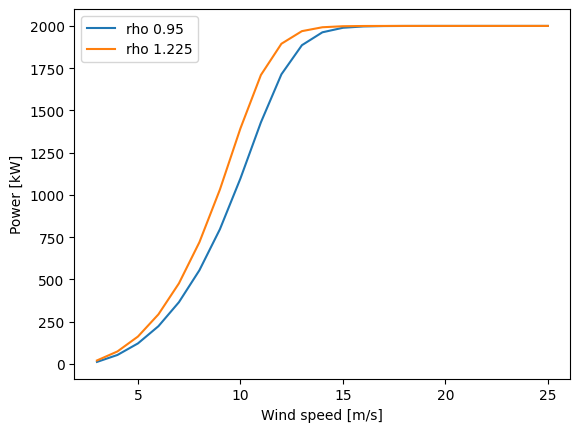

In [16]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.deficit_models.noj import NOJ

wfm = NOJ(site=Hornsrev1Site(), windTurbines=wt)

for rho in [0.95,1.225]:
    sim_res = wfm([0], [0], wd=0, Air_density=rho) # rho passed to WindFarmModel call
    power = sim_res.Power.squeeze() / 1000
    plt.plot(power.ws, power, label=f'rho {rho}')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.legend()

**2) Data present in** `Site`

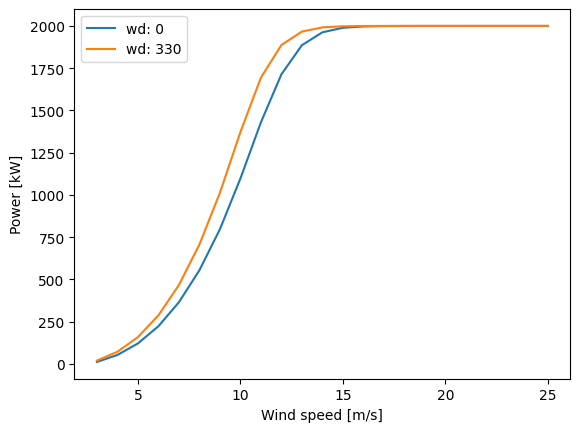

In [17]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.deficit_models.noj import NOJ

site = Hornsrev1Site()
site.ds['Air_density'] = ('wd',np.linspace(.95,1.225,13)) # wd-dependent rho added to site

wfm = NOJ(site=site, windTurbines=wt)

for wd in [0,330]:
    sim_res = wfm([0], [0], wd=wd)
    power = sim_res.Power.squeeze() / 1000
    plt.plot(power.ws, power, label=f'wd: {wd}')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.legend()

### Interpolation method

`PowerCtTabular` **which is used by most predefined wind turbines takes a** `method` **argument which can be:**

- `linear`: Linear interpolation (default)
- `pchip`: Piecewise Cubic Hermite Interpolating Polynomial. Smooth interpolation with continous first order derivatives and not overshoots
- `spline`: Smooth interpolation with continous first and second order derivatives. Closer to original piecewise linear curve, but may have overshoots

When using the N-dimensional `PowerCtNDTabular`, only linear interpolation is supported.

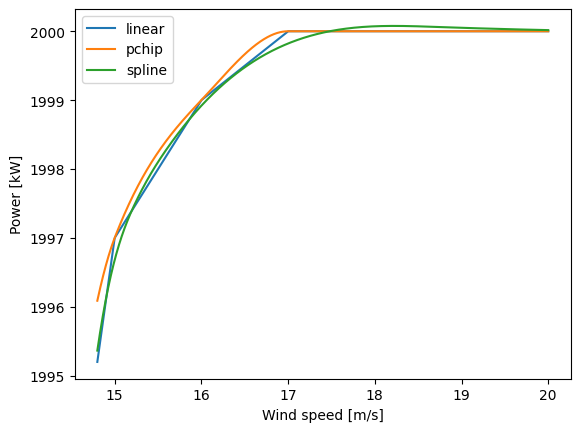

In [18]:
wt_lst = [(m, V80(method=m)) for m in ['linear','pchip','spline']]

_ws = np.linspace(14.8,20,1000)

for n, _wt in wt_lst:
    plt.plot(_ws, _wt.power(_ws)/1e3, label=n)
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

### Plotting the wind turbines

**Top-view plot**

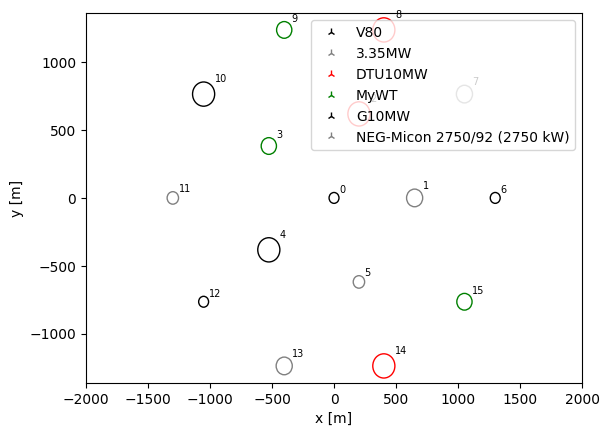

In [25]:
s = IEA37Site(16)
x,y = s.initial_position.T

plt.figure()
wts.plot_xy(x,y,types=np.arange(len(x))%len(types))
plt.xlim(-2000,2000)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()

**Side-view plot**

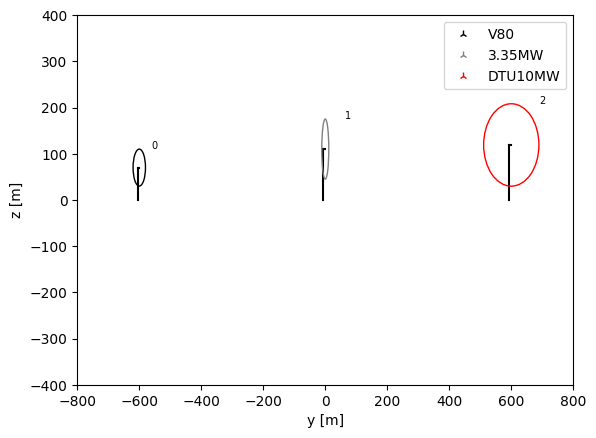

In [28]:
#here you can also specify yaw angles for the turbines
plt.figure()
wts.plot_yz(np.array([-600,0,600]), wd=0, types=[0,1,2], yaw=[-30, 10, 90])
plt.ylim(-400,400)
plt.xlim(-800,800)
plt.xlabel('y [m]')
plt.ylabel('z [m]')
plt.legend()

# Wind Turbine under Yaw Misalignment

In case the wind turbine rotor is not perpendicular to the inflow, its operation and effects on the flow field will be different. In general, it is a quite complicated process. In PyWake, the effects are divided into four sub-effects that are handled invididually:

1. Change of operation due to reduced inflow wind speed
2. Reduced deficit, <font style="color:red">$deficit_{normal}$</font>, due to reduced inflow wind speed, ($C_{T,n} \rightarrow C_{T,x}$)
3. Reduced deficit, <font style="color:#CCCC00">$deficit_{downwind}$</font>, due to misalignment between thrust and downwind direction
4. Deflection of wake deficit, <font style="color:green">$deficit_{deflected}$</font>, due to transversal thrust component reaction

<img src="../_static/wt_in_yaw.svg" alt="drawing" width="700"/>


**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

**First we import some basic Python elements**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import IntSlider

**We also import the site, wind turbines, and engineering wake models necessary for the simulation**

In [3]:
from py_wake.examples.data.hornsrev1 import V80
from py_wake.flow_map import HorizontalGrid
from py_wake.tests.test_files import tfp
from py_wake.wind_farm_models import PropagateDownwind, All2AllIterative
from py_wake.deficit_models import FugaYawDeficit
from py_wake.deflection_models import FugaDeflection
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.flow_map import XYGrid
from py_wake.utils import fuga_utils
from py_wake.utils.plotting import setup_plot

wt = V80()
site = Hornsrev1Site()
D = wt.diameter()
R = D/2
xi0,xi1,yi = 508, 553, 33 #upstream, downstream and crosswind regions to load

## Effect 1 - Change of operation due to reduced inflow wind speed

The inflow perpendicular to the rotor is reduced by $cos\theta$.

This means that the pitch and rotor speed setting of the WT will be different. In PyWake, the WT operation (pitch and rotor speed settings) is modeled in terms of the **Power and CT curves**. If these curves are specified in terms of the wind speed normal to the rotor, then the wind speed must be multiplied by $cos\theta$ before looking up the power and CT.

This is one of two effects modeled by the `SimpleYawModel`, which is an additional model that is applied as default to most PowerCtFunctions, see [here](#SimpleYawModel) for more details.

Note, that below rated rotor speed, the CT curve is typically rather flat and reducing the wind speed has therefore limited effect on the CT value in this region. The power, on the other hand, is limited by the maximum power and therefore only affected in the region below rated wind speed (rated wind speed will increase with yaw misalignment).

Furthermore, misalignment between the thrust force (axial induction) and the inflow leads to higher wind speed at the rotor plane, which also affects the WT operation. This effect, however, is not considered in PyWake.

Text(0, 0.5, 'Power [W]')

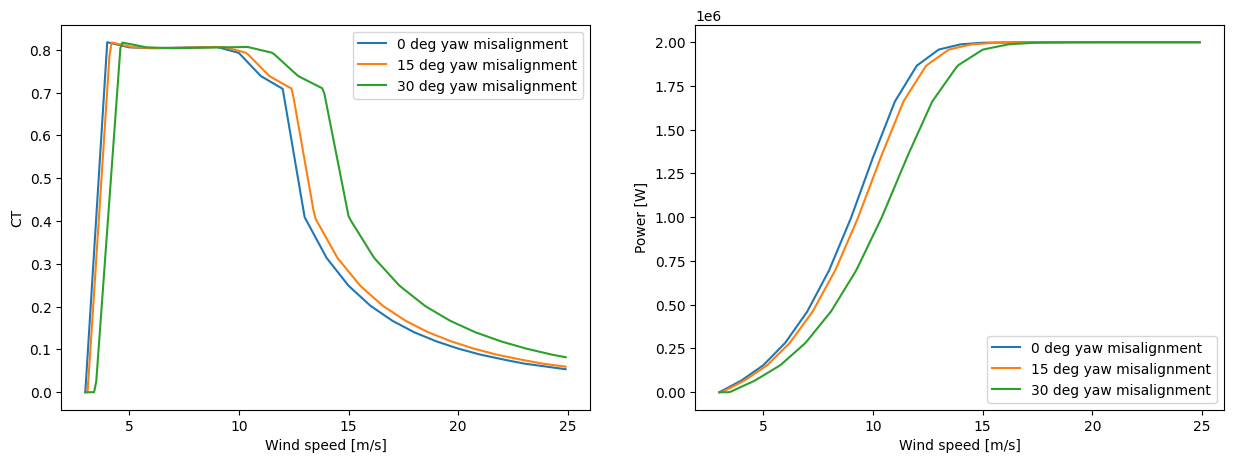

In [4]:
#here we can see an example of the thrust and power curves for different yaw misalignment angles
u = np.arange(3,25,.1)
ax1,ax2 = plt.subplots(1,2, figsize=(15,5))[1]

#looping through different values for yaw angles
for yaw in [0,15,30]:
    ax1.plot(u,wt.ct(u*np.cos(np.deg2rad(yaw))), label='%d deg yaw misalignment'%yaw)
    ax2.plot(u,wt.power(u*np.cos(np.deg2rad(yaw))), label='%d deg yaw misalignment'%yaw)
    
for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('Wind speed [m/s]')
ax1.set_ylabel('CT')
ax2.set_ylabel('Power [W]')

## Effect 2 - Reduced deficit due to reduced inflow wind speed ($C_{T,n} \rightarrow C_{T,x}$)

The wake deficit is caused by a reaction to the thrust force, which slows down the inflow.

The thrust force normal to the rotor plane is

\begin{align}
T_n & =\frac{1}{2}\rho C_{T,n} A (U cos\theta)^2
\end{align}

In non-aligned inflow, the thrust force that slows down the flow, i.e. in the mean wind direction is

\begin{align}
T_x & =\frac{1}{2}\rho C_ {T,x} \left(A cos\theta \right) U^2
\end{align}

From these two equations we can find the relationship between the thrust coefficient in the rotor-normal direction, $C_{T,n}$, and the thrust coefficient in the down-wind direction, $C_{T,x}$.

\begin{align}
T_x & = T_n cos\theta \\
\frac{1}{2} \rho C_{T,x} \left(A cos\theta \right) U^2 & = \frac{1}{2}\rho C_{T,n} A (U cos\theta)^2 cos\theta\\
C_ {T,x}  & = C_{T,n}  \cos^2\theta
\end{align}

This is the second effect modeled by the `SimpleYawModel`, which is an additional model that is applied as default to most PowerCtFunctions and is shown below.

**SimpleYawModel**

The `SimpleYawModel` is an additional model, which as default is applied by 

- `PowerCtFunction`
- `PowerCtTabular`
- `PowerCtNDTabular`
- `PowerCtXr`
- `CubePowerSimpleCt`

It handles effects 1. and 2. by:

1. Compute/look up $C_{T,n}$ based on wind speed $U\cos\theta$
2. Returns $C_{T,x} = C_{T,n} \cos^2\theta$

One can also specify a custom exponent for the cosine thrust scaling using `SimpleYawModel`'s `exp` argument.

## Effect 3 - Reduced deficit due to misalignment between thrust and downwind direction

Most engineering models calculate the deficit normal to the rotor plane, while the deficit impacting downstream WT is the deficit in the downstream direction.

In case of yaw misalignment, the deficit is therefore mapped to downstream direction by

$deficit_{downwind} = deficit_{normal} cos \theta$


**To model this effect, PyWake uses the** `FugaYawDeficit` **model.**

This model requires two sets of look-up tabels, namely `UL` and `UT`. These tables describes the normalized deficit in the downwind, `U` direction caused by a unit forcing in the longitudinal, L, and transveral, T, directions.

In [5]:
fuga = FugaYawDeficit(tfp + 'fuga/2MW/Z0=0.00001000Zi=00400Zeta0=0.00E+00.nc')
UL, UT = [fuga_utils.mirror(v,anti_symmetric=a) for v, a in zip(fuga.da[:,:yi, xi0:xi1], (False,True))]

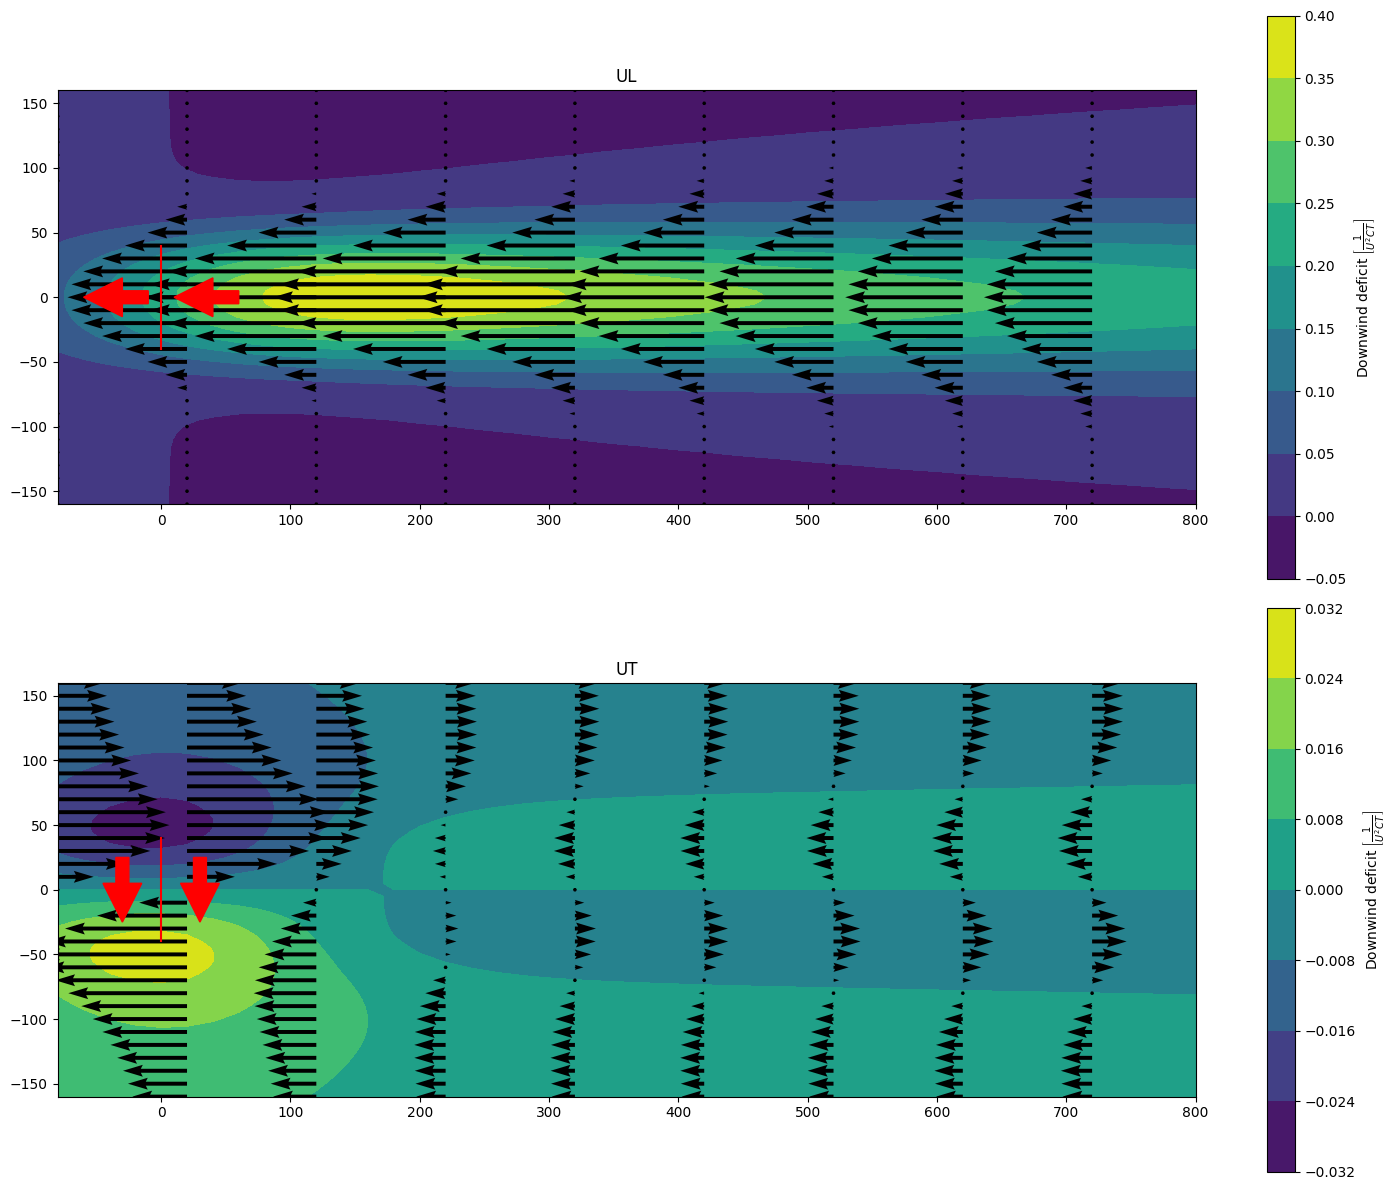

In [6]:
axes = plt.subplots(2,1, figsize=(15,12))[1]
X, Y = np.meshgrid(fuga.x[xi0:xi1], fuga_utils.mirror(fuga.y[:yi], anti_symmetric=True))
wtL = np.array([[0,0],[-D/2,D/2]])
for ax, v, l in zip(axes.flatten(), [UL, -UT], ['UL','UT']):
    c = ax.contourf(X, Y, v)
    plt.colorbar(c, ax=ax, label=r'Downwind deficit $\left[\frac{1}{U^2 CT}\right]$')
    s = (slice(None,None,2),slice(None,None,5))
    ax.quiver(X[s], Y[s], -v[s]*(l[0]=='U'), v[s]*(l[0]=='V'))
    ax.plot([0,0],[-D/2,D/2],'r')
    if l[1]=='L':
        ax.arrow(-10,0,-20,0,color='r', width=10,head_length=30)
        ax.arrow(60,0,-20,0,color='r', width=10,head_length=30)
    else:
        ax.arrow(-30,25,0,-20,color='r', width=10,head_length=30)
        ax.arrow(30,25,0,-20,color='r', width=10,head_length=30)
    setup_plot(ax=ax, axis='scaled', title=l,grid=False,xlim=[-D,10*D])    

**As Fuga is a linear model, the deficit in the downstream direction can simply be calculated by the linear superposition of** `UL` **and** `UT`:

$deficit = (UL \cdot cos\theta + UT \cdot sin\theta) \cdot U \cdot CT$

**You can move the slider below to see the deficit fields for different yaw-misalignment angles**

In [7]:
def plot(yaw):
    plt.figure(figsize=(18,5))
    theta = np.deg2rad(yaw)
    co, si = np.cos(theta), np.sin(theta)
    deficit = co**2*(UL*co - UT*si)
    c = plt.contourf(X, Y, deficit,20)#, levels=np.arange(-.4,.1,.05))
    plt.colorbar(c, label=r'Downwind deficit $\left[\frac{1}{U^2 CT}\right]$')
    s = (slice(None,None,2),slice(5,None,5))
    plt.quiver(X[s], Y[s], -deficit[s], deficit[s]*0, width=.002, scale=2)
    plt.plot([si*R, -si*R],[-co*R,co*R],'w',label='Rotor',lw=3)
    plt.arrow(-0,0,-100*co,0,color='r', width=5,head_length=10,length_includes_head=True)
    plt.arrow(-0,-0,0,-100*si,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    setup_plot(ax=ax, axis='scaled', title=l,grid=False,xlim=[-D,10*D])    
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

## Effect 4 - Wake deflection due to traversal thrust component reaction

Wake deflection is modeled by a `DeflectionModel`, which modifies the downwind, horizontal crosswind and vertical distance between wind turbines.

**The** `FugaDeflection` **is capable of modeling the wake deflection if** `VL` **and** `VT` **is known.**

These tables describes the normalized deficit in the crosswind, `V` direction caused by a unit forcing in the longitudinal, L, and transveral, T, directions.

In [8]:
fugaDeflection = FugaDeflection(tfp + 'fuga/2MW/Z0=0.00001000Zi=00400Zeta0=0.00E+00.nc')
# VL is antisymmetric, VT is symmetric
VL, VT = [fugaDeflection.mirror(v,anti_symmetric=a) for v, a in zip(fugaDeflection.load_luts()[2:4,0,:yi, xi0:xi1], (True, False))]

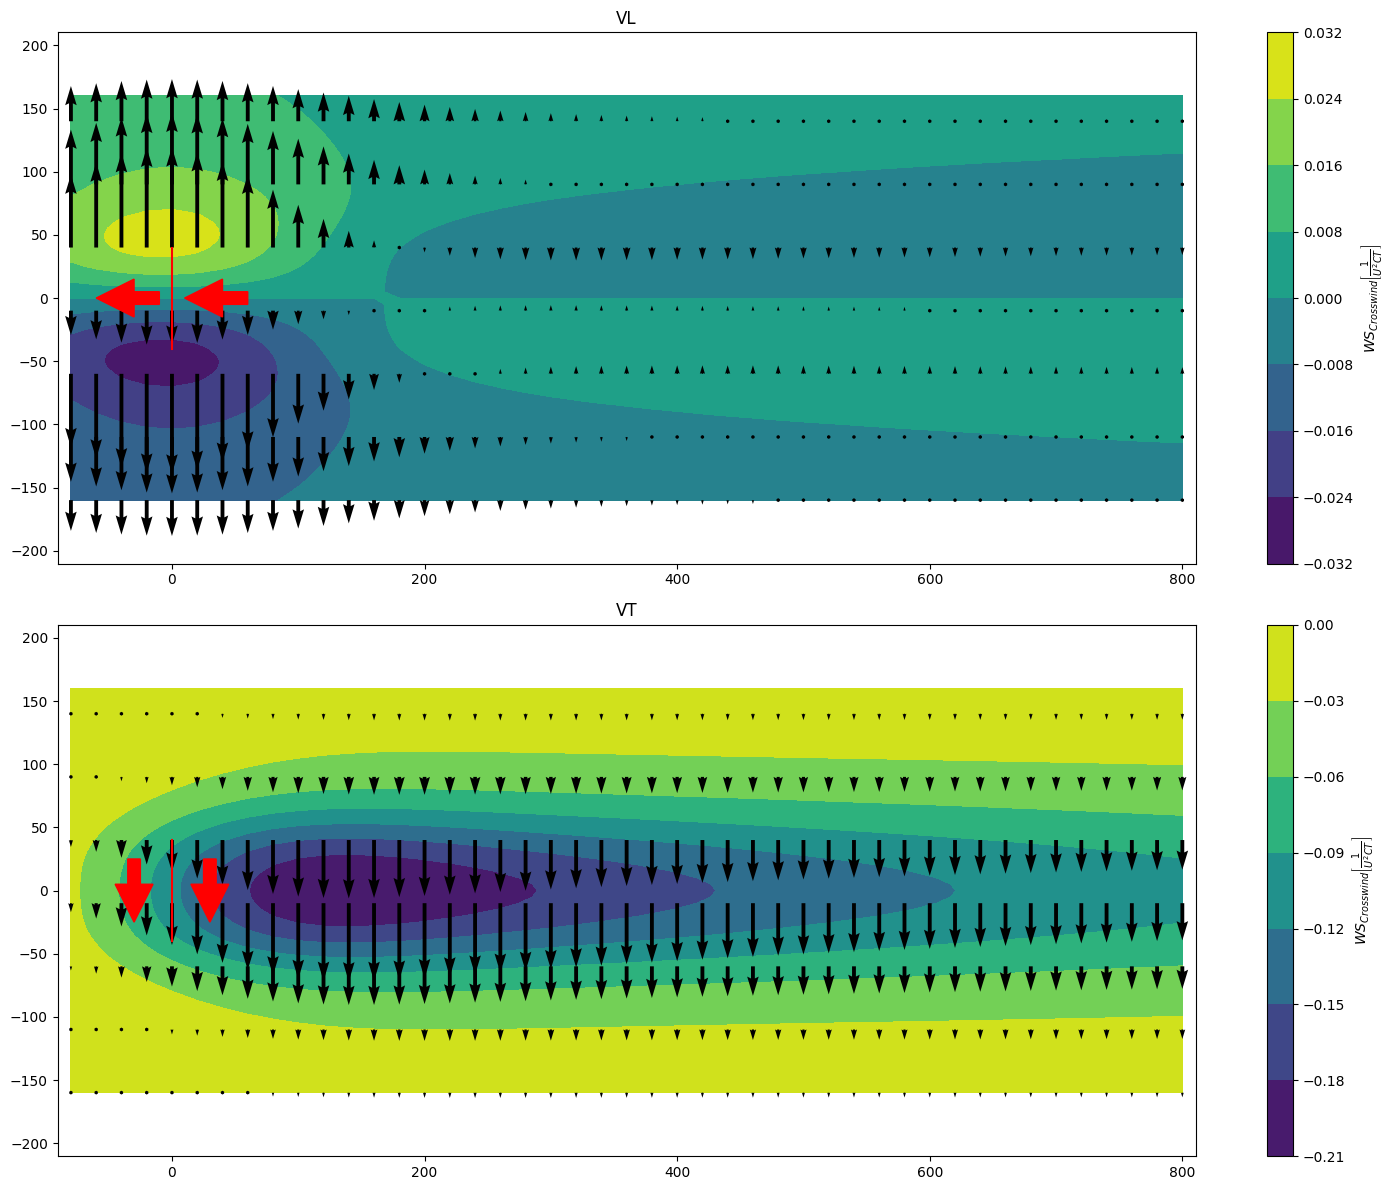

In [9]:
axes = plt.subplots(2,1, figsize=(15,12))[1]
X, Y = np.meshgrid(fugaDeflection.x[xi0:xi1], fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True))
for ax, v, l in zip(axes.flatten(), [-VL, VT], ['VL','VT']):
    c = ax.contourf(X, Y, v)
    plt.colorbar(c, ax=ax, label=r'$WS_{Crosswind} \left[\frac{1}{U^2 CT}\right]$')
    s = (slice(None,None,10),slice(None,None,1))
    ax.quiver(X[s], Y[s], 0, v[s], scale=(.3,3)[l[1]=='T'])
    ax.plot([0,0],[-D/2,D/2],'r')
    if l[1]=='L':
        ax.arrow(-10,0,-20,0,color='r', width=10,head_length=30)
        ax.arrow(60,0,-20,0,color='r', width=10,head_length=30)
    else:
        ax.arrow(-30,25,0,-20,color='r', width=10,head_length=30)
        ax.arrow(30,25,0,-20,color='r', width=10,head_length=30)
    setup_plot(ax=ax, axis='equal', title=l,grid=False)    

**As Fuga is a linear model, the effects in the crosswind direction can simply be calculated by linear superposition of** `VL` **and** `VT`:

$WS_{crosswind} = (VL \cdot cos\theta + VT \cdot sin\theta) \cdot U \cdot CT$

**You can move the slider below to see the crosswind wind speed field for different yaw-misalignment angles. Furthermore, the integrated deflection is shown with solid lines**

In [10]:
def plot(yaw):
    plt.figure(figsize=(18,5))
    theta = np.deg2rad(yaw)
    co, si = np.cos(theta), np.sin(theta)
    V = co**2*(-VL*co + VT*si)
    X, Y = np.meshgrid(fugaDeflection.x[xi0:xi1], fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True))
    c = plt.contourf(X, Y, V)#, levels=np.arange(-.09,.1,.01))
    plt.colorbar(c, label=r'$WS_{crosswind} \left[\frac{1}{U CT}\right]$')
    s = (slice(None,None,6),slice(None,None,1))
    plt.quiver(X[s], Y[s], V[s]*0, V[s], width=.002, scale=2)
    
    # plot deflection lines
    fL, fT = fugaDeflection.fLT.V.T[:,256-yi:255+yi, xi0:xi1]
    lambda2p = co**2 * (fL * co + fT * si)
    y = fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True)
   
    lambda2 = np.array([np.interp(y, y + l2p, l2p) for l2p in lambda2p.T])
    Yp = Y + lambda2.T
    plt.plot(X[yi, :], Y[yi, :], 'grey', lw=3)
    for x, y, yp in zip(X[1::4], Y[1::4], Yp[1::4]):
        plt.plot(x, y, 'grey', lw=1, zorder=-32)
        plt.plot(x, yp, 'k', lw=1)
    plt.plot(X[yi, :], Yp[yi, :], 'k', lw=3)
    
    plt.plot([si*R, -si*R],[-co*R,co*R],'w',label='Rotor',lw=3)
    plt.arrow(-0,0,-50*co,0,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    plt.arrow(-0,-0,0,-50*si,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    setup_plot(ax=ax, axis='equal', title=l,grid=False)    
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

Note, the plot above shows the wind speed in cross-wind direction (up), i.e. yellow colors corresponds to a flow towards the top of the figure, while blue corresponds to a flow towards the bottom.

**Finally, all effects are put together. You can move the slider below to see the effects on the deficit behind a WT.**

In [11]:
path = tfp + 'fuga/2MW/Z0=0.00001000Zi=00400Zeta0=0.00E+00.nc'
fugaDeficit = FugaYawDeficit(path)
wfm = All2AllIterative(site,wt,fugaDeficit,blockage_deficitModel=fugaDeficit,                       
                       deflectionModel=FugaDeflection(path)
                       )
def plot(yaw):
    plt.figure(figsize=(18,5))
    fm = wfm([0],[0],ws=10,wd=270, yaw=[[[yaw]]]).flow_map(XYGrid(x=np.arange(-100,800,10), y=np.arange(-250,250,10)))
    X,Y = np.meshgrid(fm.x, fm.y)
    c1 = plt.contourf(X,Y,fm.WS_eff.squeeze(),np.arange(6.5,10.1,0.1), cmap='Blues_r')
    c2 = plt.contourf(X,Y,fm.WS_eff.squeeze(),np.arange(10,10.2,.005), cmap='Reds')
    plt.colorbar(c2, label='Wind speed (deficit regions) [m/s]')
    plt.colorbar(c1, label='Wind speed (speed-up regions) [m/s]')
    wt.plot([0],[0],wd=270,yaw=yaw)
    max_deficit_line = fm.min_WS_eff(x=np.arange(-100,800,10))
    max_deficit_line.plot(color='k', label='Max deficit line')
    plt.axhline(0, label='Center line')
    plt.legend()
    
    
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))    

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

Note, the scaling of wake deficit(blue) and speedup(red) does not match